# Music Video Engagement Predictor - Preprocessing & Modeling
# ## Section 1: Imports
# Import necessary libraries for data manipulation, visualization, and machine learning.


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import math
import json
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor # Added KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is imported if not already global
import matplotlib.pyplot as plt # Ensure plt is imported if not already global
import os # Ensure os is imported

# --- New Imports ---
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# import tensorflow as tf # Optional: Uncomment if using TensorFlow
# --- Keras/TensorFlow Imports ---
from tensorflow import keras # Use tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
# --- Gradient Boosting Import ---
from sklearn.ensemble import GradientBoostingRegressor
# --- Stacking/SVM Imports ---
from sklearn.ensemble import StackingRegressor, StackingClassifier # Added StackingRegressor, StackingClassifier already there
from sklearn.linear_model import Ridge # Added Ridge
from sklearn import svm # svm already imported, added SVR below
from sklearn.svm import SVR # Added SVR
from sklearn.ensemble import RandomForestClassifier # Already imported but ensure it's available
from sklearn.linear_model import LogisticRegression # Already imported
# --- End New Imports ---

# Configure plotting styles for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# ## Section 2: Configuration & Setup
# Define constants, file paths, and create the results directory if it doesn't exist.

In [38]:
# Configuration
FILEPATH = 'Spotify_Youtube.csv'
TARGET_COLUMN = 'Views' # Target for regression task
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Create results directory
RESULTS_DIR = 'results'
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    print(f"Created results directory: {RESULTS_DIR}")
else:
    print(f"Results will be saved to existing directory: {RESULTS_DIR}")

Results will be saved to existing directory: results


# ## Section 3: Load Data
# Load the dataset from the specified CSV file and display initial information and a preview.


In [39]:
print(f"--- 3: Loading Data from {FILEPATH} ---")
try:
    df = pd.read_csv(FILEPATH)
    print(f"Data loaded successfully. Shape: {df.shape}")

    print("\n--- Initial Data Info ---")
    df.info() # Use print(df.info()) if output doesn't show in notebook

    print("\n--- Data Head ---")
    print(df.head()) # Use display() for better notebook formatting

    print("\n--- Data Description ---")
    print(df.describe())

except FileNotFoundError:
    print(f"Error: File not found at {FILEPATH}. Please ensure the file exists in the correct directory.")
    # Optionally exit or raise an error if the file is critical
    # sys.exit(1)
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    # sys.exit(1)

--- 3: Loading Data from Spotify_Youtube.csv ---
Data loaded successfully. Shape: (20718, 28)

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20718 entries, 0 to 20717
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        20718 non-null  int64  
 1   Artist            20718 non-null  object 
 2   Url_spotify       20718 non-null  object 
 3   Track             20718 non-null  object 
 4   Album             20718 non-null  object 
 5   Album_type        20718 non-null  object 
 6   Uri               20718 non-null  object 
 7   Danceability      20716 non-null  float64
 8   Energy            20716 non-null  float64
 9   Key               20716 non-null  float64
 10  Loudness          20716 non-null  float64
 11  Speechiness       20716 non-null  float64
 12  Acousticness      20716 non-null  float64
 13  Instrumentalness  20716 non-null  float64
 14  Liveness     

# ## Section 4: Initial Cleaning
# Perform basic data cleaning steps:
# - **4a:** Remove the leading unnamed index column if present.
# - **4b:** Handle missing values by dropping rows with any NaNs.
# - **4c:** Remove significant outliers defined as videos with over 1 billion views.
# - **4d/4e:** Placeholders for potential future outlier/labeling corrections.

In [40]:
print("\n--- 4: Cleaning Data ---")

if 'df' in locals(): # Check if df was loaded successfully
    # --- 4a: Drop Unnamed Column ---
    if df.columns[0].startswith('Unnamed:'):
        print(f"Dropping the first unnamed column: {df.columns[0]}")
        df = df.iloc[:, 1:]
    else:
        print("First column is not unnamed, not dropping.")

    # --- 4b: Handle Missing Values ---
    initial_rows = len(df)
    missing_before = df.isnull().sum().sum()
    print(f"Missing values before dropping NaNs: {missing_before}")
    df.dropna(inplace=True)
    rows_dropped = initial_rows - len(df)
    if rows_dropped > 0:
        print(f"Dropped {rows_dropped} rows with missing values.")
    else:
        print("No rows with missing values found or dropped.")
    print(f"Missing values after dropping NaNs: {df.isnull().sum().sum()}")


    # --- 4c: Remove Outliers (Videos with > 1 billion views) ---
    initial_rows = len(df)
    outlier_threshold = 1_000_000_000  # 1 billion views
    outliers = df[df['Views'] > outlier_threshold]
    df = df[df['Views'] <= outlier_threshold]
    outliers_dropped = initial_rows - len(df)
    if outliers_dropped > 0:
        print(f"Dropped {outliers_dropped} rows with more than {outlier_threshold:,} views (outliers).")
    else:
        print("No rows found with views > 1 billion.")


    print(f"DataFrame shape after cleaning: {df.shape}")

    # --- 4d: Placeholder for other outlier handling ---
    print("\nPlaceholder: Additional outlier detection and handling could be added here (e.g., using IQR).")

    # --- 4e: Placeholder for Incorrectly Labeled Points ---
    print("Placeholder: Handling of potentially incorrectly labeled points could be added here.")

else:
    print("DataFrame 'df' not loaded. Skipping cleaning steps.")


--- 4: Cleaning Data ---
Dropping the first unnamed column: Unnamed: 0
Missing values before dropping NaNs: 5404
Dropped 1548 rows with missing values.
Missing values after dropping NaNs: 0
Dropped 297 rows with more than 1,000,000,000 views (outliers).
DataFrame shape after cleaning: (18873, 27)

Placeholder: Additional outlier detection and handling could be added here (e.g., using IQR).
Placeholder: Handling of potentially incorrectly labeled points could be added here.


# ## Section 5: Encode Categorical Features
# Identify object-type columns (likely strings) and convert them into numerical representations using `LabelEncoder`. Store the encoders in case the mapping is needed later.

In [41]:
print("\n--- 5: Encoding Categorical Features ---")
label_encoders = {}

if 'df' in locals():
    # Get all object columns that need encoding
    object_columns = df.select_dtypes(include=['object']).columns
    print(f"Found {len(object_columns)} object columns to encode: {list(object_columns)}")

    # Encode all object/categorical columns
    for col in object_columns:
        if col in df.columns:
            print(f"Encoding categorical column: {col}")
            # Check for missing values again before encoding (should be handled, but good practice)
            if df[col].isnull().any():
                 print(f"Warning: Column '{col}' contains NaNs before encoding. Filling with a placeholder.")
                 df[col].fillna('Missing', inplace=True) # Or use a different strategy

            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le # Store encoder if needed later
            print(f"Column '{col}' encoded. Unique values: {len(le.classes_)}")
        else:
            print(f"Warning: Column '{col}' not found for encoding (might have been dropped).")

    print(f"\nDataFrame shape after encoding: {df.shape}")
    print("Object columns encoded to numeric values.")
    print("\n--- Data Head After Encoding ---")
    print(df.head())
else:
    print("DataFrame 'df' not loaded. Skipping encoding.")



--- 5: Encoding Categorical Features ---
Found 12 object columns to encode: ['Artist', 'Url_spotify', 'Track', 'Album', 'Album_type', 'Uri', 'Url_youtube', 'Title', 'Channel', 'Description', 'Licensed', 'official_video']
Encoding categorical column: Artist
Column 'Artist' encoded. Unique values: 2039
Encoding categorical column: Url_spotify
Column 'Url_spotify' encoded. Unique values: 2039
Encoding categorical column: Track
Column 'Track' encoded. Unique values: 16354
Encoding categorical column: Album
Column 'Album' encoded. Unique values: 11118
Encoding categorical column: Album_type
Column 'Album_type' encoded. Unique values: 3
Encoding categorical column: Uri
Column 'Uri' encoded. Unique values: 17234
Encoding categorical column: Url_youtube
Column 'Url_youtube' encoded. Unique values: 16941
Encoding categorical column: Title
Column 'Title' encoded. Unique values: 16935
Encoding categorical column: Channel
Column 'Channel' encoded. Unique values: 6197
Encoding categorical column: 

# ## Section 6: Feature Selection & Multicollinearity
# - Drop columns deemed irrelevant for modeling (URLs, IDs, free text, etc.).
# - Calculate the correlation matrix for the remaining features.
# - Identify pairs of features with high correlation (absolute value > 0.8) to address multicollinearity.
# - Drop one feature from each highly correlated pair, prioritizing keeping the target variable (`Views`).



In [42]:
print("\n--- 6: Feature Selection & Multicollinearity ---")

if 'df' in locals():
    # Columns identified as not adding value for ML predictions or redundant
    columns_to_drop = [
        'Url_spotify',
        'Uri',
        'Url_youtube',
        'Description',
        'Licensed',         # Often boolean/categorical with low variance or captured elsewhere
        'official_video',   # Often boolean/categorical with low variance or captured elsewhere
        'Track',            # Assumed to be high cardinality identifier, potentially redundant with Artist/Album
        'Comments'          # Dropping Comments as it's a direct measure of engagement we might predict *from*, not predict *with*
    ]

    # Drop the specified columns only if they exist
    existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    if existing_cols_to_drop:
        df = df.drop(columns=existing_cols_to_drop)
        print(f"Dropped columns: {existing_cols_to_drop}")
    else:
        print("No specified columns to drop were found.")
    print(f"DataFrame shape after initial feature selection: {df.shape}")

    # Verify that Views exists in the DataFrame
    if TARGET_COLUMN not in df.columns:
        print(f"CRITICAL WARNING: Target column '{TARGET_COLUMN}' not found in DataFrame after dropping columns.")
        # Consider stopping execution if target is missing
        # sys.exit(1)
    else:
        print(f"Target column '{TARGET_COLUMN}' is present.")

        # Check for multicollinearity (features with high correlation > 0.8)
        print("\nChecking for multicollinearity (corr > 0.8):")
        # Ensure we only calculate correlation on numeric types
        numeric_df_corr = df.select_dtypes(include=np.number)
        corr_matrix = numeric_df_corr.corr()
        high_corr_pairs = []
        columns_dropped_for_corr = set()

        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]
                corr_value = corr_matrix.iloc[i, j]

                if abs(corr_value) > 0.8:
                    # Avoid dropping already dropped columns or the target
                    if col_i not in columns_dropped_for_corr and col_j not in columns_dropped_for_corr:
                        print(f"  High correlation detected: {col_i} & {col_j}: {corr_value:.2f}")
                        high_corr_pairs.append((col_i, col_j, corr_value))
                        # Decide which one to drop - simplistic approach: drop the second one unless it's the target
                        if col_j == TARGET_COLUMN:
                            print(f"  Keeping target '{col_j}', considering dropping '{col_i}'.")
                            if col_i != TARGET_COLUMN: # Ensure we don't drop target if both are somehow target
                                columns_dropped_for_corr.add(col_i)
                                print(f"  Marked '{col_i}' for dropping.")
                        else:
                             print(f"  Considering dropping '{col_j}'.")
                             columns_dropped_for_corr.add(col_j)
                             print(f"  Marked '{col_j}' for dropping.")


        # Drop the marked columns
        if columns_dropped_for_corr:
            print(f"\nDropping columns due to multicollinearity: {list(columns_dropped_for_corr)}")
            df = df.drop(columns=list(columns_dropped_for_corr))
            print(f"DataFrame shape after multicollinearity handling: {df.shape}")
        else:
            print("No features dropped due to high correlation.")

        # Verify again that Views is still in the DataFrame
        if TARGET_COLUMN not in df.columns:
            print(f"ERROR: Target column '{TARGET_COLUMN}' was dropped during multicollinearity handling!")
            # sys.exit(1)
        else:
            print(f"Target column '{TARGET_COLUMN}' is still present.")

        # Display remaining columns
        print("\nRemaining columns after feature selection and multicollinearity check:")
        print(df.columns.tolist())
else:
    print("DataFrame 'df' not loaded. Skipping feature selection.")



--- 6: Feature Selection & Multicollinearity ---
Dropped columns: ['Url_spotify', 'Uri', 'Url_youtube', 'Description', 'Licensed', 'official_video', 'Track', 'Comments']
DataFrame shape after initial feature selection: (18873, 19)
Target column 'Views' is present.

Checking for multicollinearity (corr > 0.8):
  High correlation detected: Likes & Views: 0.84
  Keeping target 'Views', considering dropping 'Likes'.
  Marked 'Likes' for dropping.

Dropping columns due to multicollinearity: ['Likes']
DataFrame shape after multicollinearity handling: (18873, 18)
Target column 'Views' is still present.

Remaining columns after feature selection and multicollinearity check:
['Artist', 'Album', 'Album_type', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Title', 'Channel', 'Views', 'Stream']


# ## Section 6.5: Feature Correlation Analysis
# Visualize the correlation matrix of the final set of numerical features using a heatmap. Display the features most correlated with the target variable (`Views`).



--- 6.5: Feature Correlation Analysis ---
Correlation heatmap saved to results/correlation_heatmap_final.png


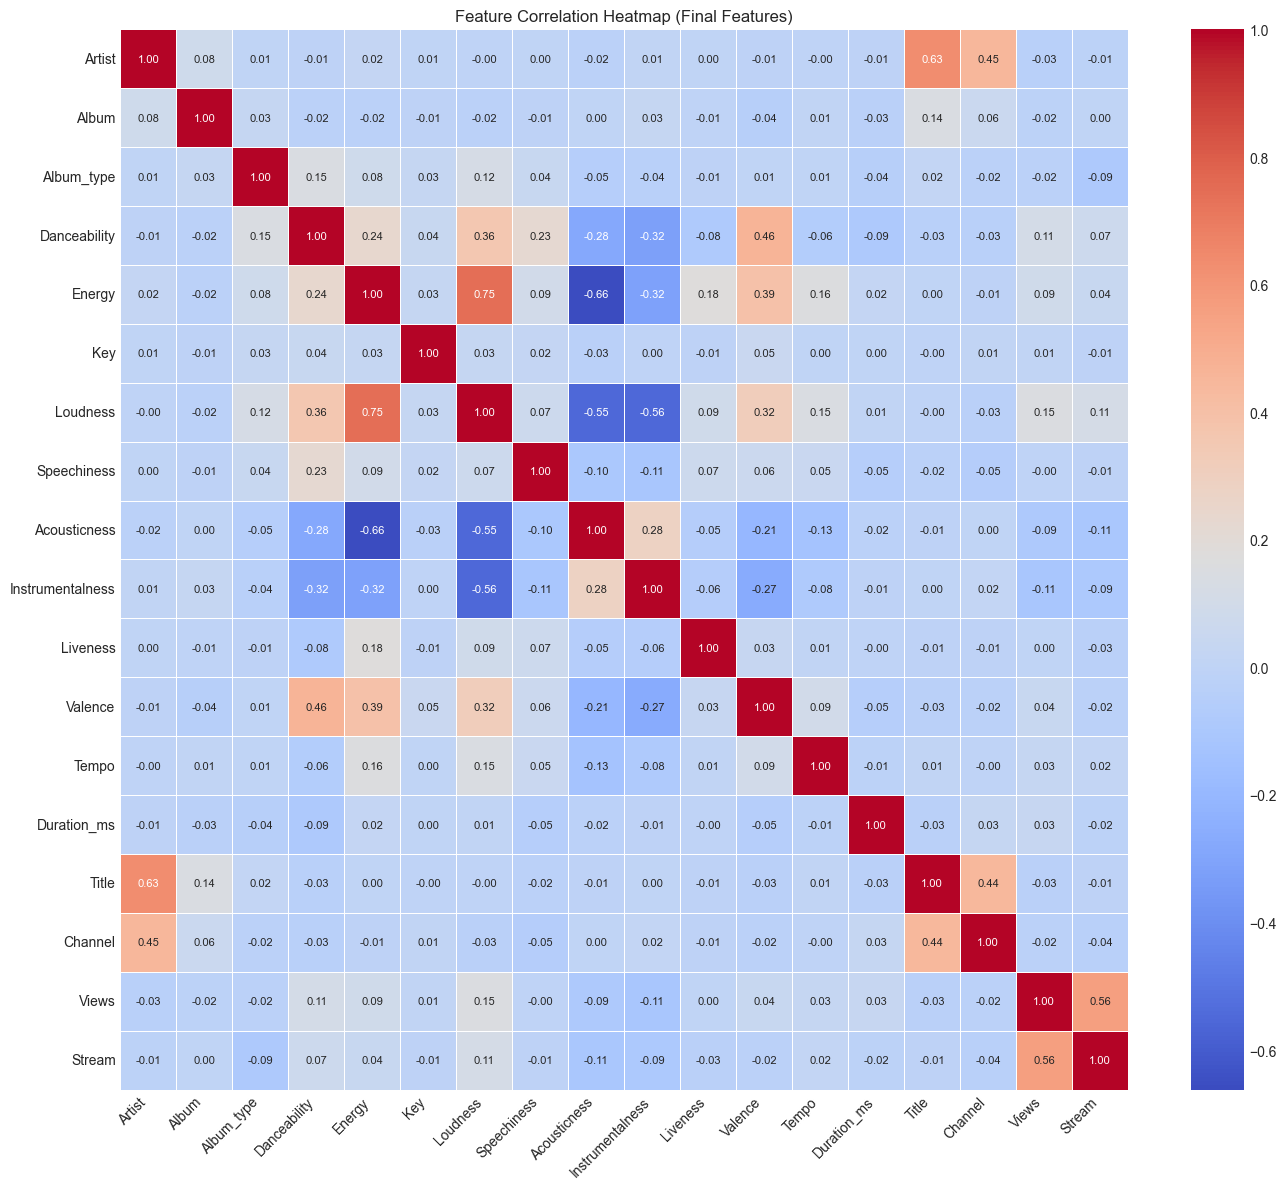


Correlations with target variable 'Views':
Views               1.000000
Stream              0.564755
Loudness            0.152346
Danceability        0.106146
Energy              0.087595
Valence             0.041823
Duration_ms         0.034889
Tempo               0.027443
Key                 0.009033
Liveness            0.002690
Speechiness        -0.004987
Album              -0.017796
Album_type         -0.019435
Channel            -0.019809
Title              -0.028570
Artist             -0.033015
Acousticness       -0.088683
Instrumentalness   -0.112911
Name: Views, dtype: float64

Final check for multicollinearity (corr > 0.8):
No high correlation (> 0.8) detected between remaining features.


In [43]:
print("\n--- 6.5: Feature Correlation Analysis ---")

if 'df' in locals() and TARGET_COLUMN in df.columns:
    # Select only numeric columns for correlation analysis
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix_final = numeric_df.corr()

    # Create the heatmap
    plt.figure(figsize=(14, 12)) # Adjusted size
    sns.heatmap(corr_matrix_final, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", annot_kws={"size": 8}) # Smaller annotations
    plt.title('Feature Correlation Heatmap (Final Features)')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'correlation_heatmap_final.png'))
    print(f"Correlation heatmap saved to {RESULTS_DIR}/correlation_heatmap_final.png")
    plt.show() # Display the plot in the notebook

    # Display top correlations with the target variable
    if TARGET_COLUMN in corr_matrix_final.columns:
        target_correlations = corr_matrix_final[TARGET_COLUMN].sort_values(ascending=False)
        print(f"\nCorrelations with target variable '{TARGET_COLUMN}':")
        print(target_correlations)
    else:
        print(f"\nTarget column {TARGET_COLUMN} not found in numeric columns for final correlation analysis.")

    # Final check for multicollinearity (should be resolved, but good to verify)
    print("\nFinal check for multicollinearity (corr > 0.8):")
    high_corr_final = []
    for i in range(len(corr_matrix_final.columns)):
        for j in range(i):
             col_i = corr_matrix_final.columns[i]
             col_j = corr_matrix_final.columns[j]
             corr_value = corr_matrix_final.iloc[i, j]
             if abs(corr_value) > 0.8:
                 high_corr_final.append((col_i, col_j, corr_value))

    if high_corr_final:
        print("Warning: Features with high correlation potentially remain:")
        for feat1, feat2, corr in high_corr_final:
            print(f"  {feat1} & {feat2}: {corr:.2f}")
    else:
        print("No high correlation (> 0.8) detected between remaining features.")
else:
     print("DataFrame 'df' or target column not available. Skipping correlation analysis.")


# ## Section 6.6: PCA (Principal Component Analysis) for Visualization
# Perform Principal Component Analysis (PCA) on the *standardized* numerical features (excluding the target) to explore dimensionality reduction and visualize the data structure.
# - Standardize features *locally* for PCA (scaling is done within pipelines for modeling).
# - Apply PCA to reduce to 2 and 3 components.
# - Visualize the data points in 2D and 3D, colored by the log-transformed target variable (`Views`) to understand separation.
# - Analyze the explained variance and feature loadings (contributions) for the first two components.
# - Plot the relationship between the first two principal components and the original target variable.



--- 6.6: PCA Analysis for Visualization ---
Features standardized locally for PCA, shape: (18873, 17)
PCA applied, reduced to 2 dimensions
Added log-transformed 'Views' for visualization
Explained variance ratio (2D): PC1 = 0.1854, PC2 = 0.1210
Total variance explained (2D): 0.3064
2D PCA visualization saved to results/pca_2d_visualization_views.png


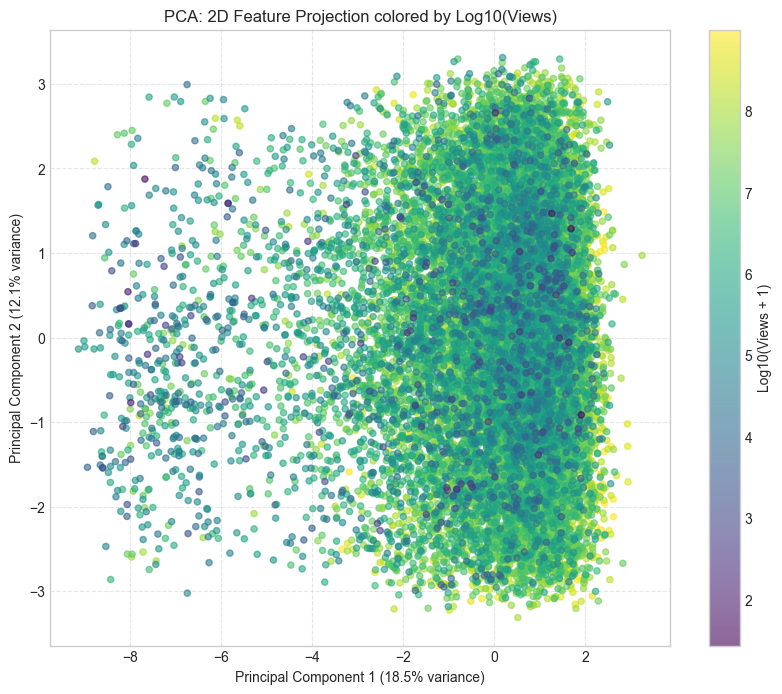


--- Creating 3D PCA Visualization ---
PCA 3D applied, reduced to 3 dimensions
Explained variance ratio (3D): PC1=0.1854, PC2=0.1210, PC3=0.0748
Total variance explained by 3 components: 0.3812
3D PCA visualization saved to results/pca_3d_visualization.png


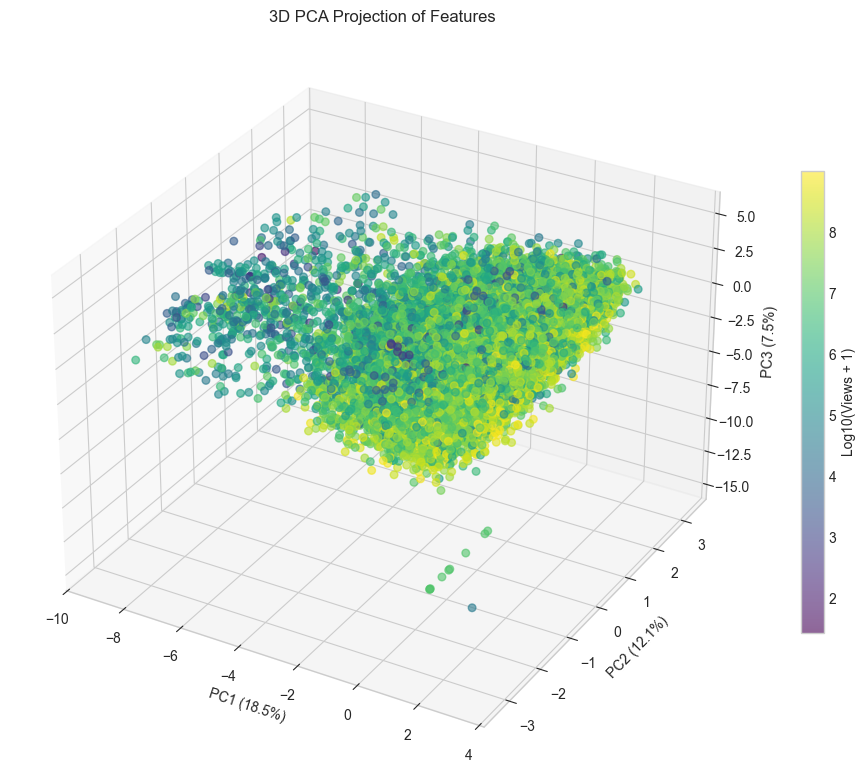


Feature contributions (loadings) to first two principal components:
PCA loadings heatmap saved to results/pca_loadings_2d.png


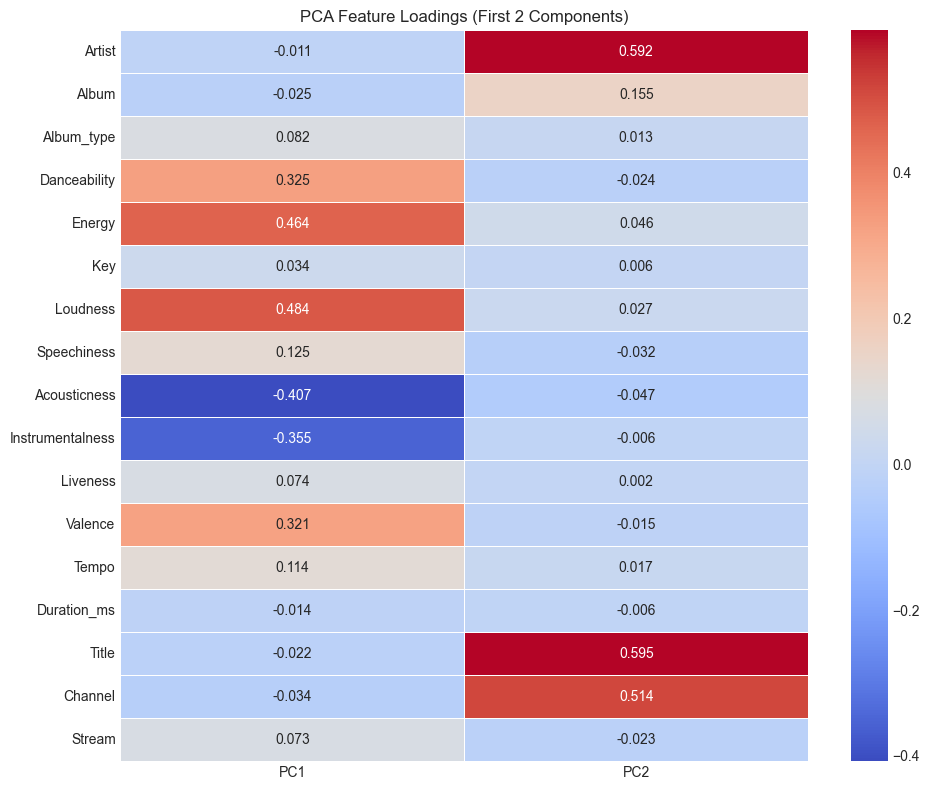

PCA components vs Views visualization saved to results/pca_vs_views.png


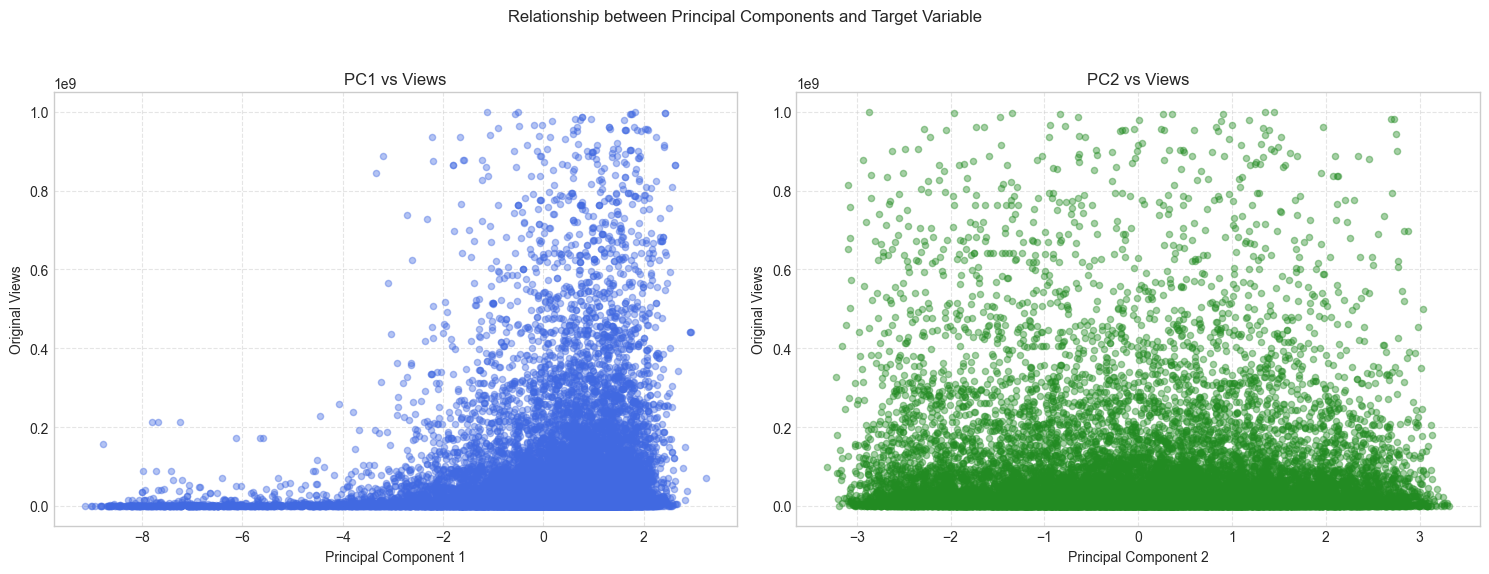

In [44]:
print("\n--- 6.6: PCA Analysis for Visualization ---")

if 'df' in locals() and TARGET_COLUMN in df.columns:
    # Prepare data for PCA: numeric features excluding the target
    numeric_features_pca = df.select_dtypes(include=np.number).drop(columns=[TARGET_COLUMN])
    target_views_pca = df[TARGET_COLUMN]

    if not numeric_features_pca.empty:
        # --- Scale features locally ONLY for PCA visualization ---
        scaler_pca = StandardScaler()
        scaled_features_pca = scaler_pca.fit_transform(numeric_features_pca)
        print(f"Features standardized locally for PCA, shape: {scaled_features_pca.shape}")

        # Apply PCA with 2 components for visualization
        pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
        pca_result_2d = pca_2d.fit_transform(scaled_features_pca)
        print(f"PCA applied, reduced to 2 dimensions")

        # Create a DataFrame for the 2D PCA results
        pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'], index=numeric_features_pca.index)

        # Add the log-transformed target variable for coloring
        # Add 1 to avoid log(0) issues
        log_views_pca = np.log10(target_views_pca.loc[pca_df_2d.index] + 1)
        pca_df_2d['Log_Views'] = log_views_pca
        print(f"Added log-transformed '{TARGET_COLUMN}' for visualization")

        # Explained variance ratio for 2D PCA
        explained_variance_2d = pca_2d.explained_variance_ratio_
        print(f"Explained variance ratio (2D): PC1 = {explained_variance_2d[0]:.4f}, PC2 = {explained_variance_2d[1]:.4f}")
        print(f"Total variance explained (2D): {sum(explained_variance_2d):.4f}")

        # --- Create a scatter plot of 2D PCA results ---
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_df_2d['PC1'], pca_df_2d['PC2'],
                           c=pca_df_2d['Log_Views'],
                           cmap='viridis',
                           alpha=0.6, s=20) # Smaller points
        plt.colorbar(scatter, label=f'Log10({TARGET_COLUMN} + 1)')
        plt.title(f'PCA: 2D Feature Projection colored by Log10({TARGET_COLUMN})')
        plt.xlabel(f'Principal Component 1 ({explained_variance_2d[0]:.1%} variance)')
        plt.ylabel(f'Principal Component 2 ({explained_variance_2d[1]:.1%} variance)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.savefig(os.path.join(RESULTS_DIR, 'pca_2d_visualization_views.png'))
        print(f"2D PCA visualization saved to {RESULTS_DIR}/pca_2d_visualization_views.png")
        plt.show()

        # --- 3D PCA Visualization ---
        print("\n--- Creating 3D PCA Visualization ---")
        pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)
        pca_result_3d = pca_3d.fit_transform(scaled_features_pca)
        explained_variance_3d = pca_3d.explained_variance_ratio_
        print(f"PCA 3D applied, reduced to 3 dimensions")
        print(f"Explained variance ratio (3D): PC1={explained_variance_3d[0]:.4f}, PC2={explained_variance_3d[1]:.4f}, PC3={explained_variance_3d[2]:.4f}")
        print(f"Total variance explained by 3 components: {sum(explained_variance_3d):.4f}")

        # Create a 3D scatter plot
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        scatter_3d = ax.scatter(
            pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2],
            c=log_views_pca, # Use the log_views calculated earlier
            cmap='viridis', alpha=0.6, s=30
        )
        fig.colorbar(scatter_3d, ax=ax, label=f'Log10({TARGET_COLUMN} + 1)', shrink=0.6) # Adjust colorbar size
        ax.set_xlabel(f'PC1 ({explained_variance_3d[0]:.1%})')
        ax.set_ylabel(f'PC2 ({explained_variance_3d[1]:.1%})')
        ax.set_zlabel(f'PC3 ({explained_variance_3d[2]:.1%})')
        ax.set_title('3D PCA Projection of Features')
        ax.grid(True, linestyle='--', alpha=0.3)
        plt.savefig(os.path.join(RESULTS_DIR, 'pca_3d_visualization.png'))
        print(f"3D PCA visualization saved to {RESULTS_DIR}/pca_3d_visualization.png")
        plt.show()

        # --- Feature importance in 2D PCA (Loadings) ---
        loadings_2d = pd.DataFrame(
            pca_2d.components_.T,
            columns=['PC1', 'PC2'],
            index=numeric_features_pca.columns
        )
        print("\nFeature contributions (loadings) to first two principal components:")
        print(loadings_2d.style.background_gradient(cmap='coolwarm', axis=None)) # Nicer display

        # Plot the feature loadings for 2D PCA
        plt.figure(figsize=(10, 8))
        sns.heatmap(loadings_2d, cmap='coolwarm', annot=True, fmt=".3f", linewidths=.5)
        plt.title('PCA Feature Loadings (First 2 Components)')
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'pca_loadings_2d.png'))
        print(f"PCA loadings heatmap saved to {RESULTS_DIR}/pca_loadings_2d.png")
        plt.show()

        # --- Visualize how PC1 and PC2 correlate with original Views ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # PC1 vs Views (using original Views)
        ax1.scatter(pca_df_2d['PC1'], target_views_pca.loc[pca_df_2d.index], alpha=0.4, c='royalblue', s=20)
        ax1.set_xlabel('Principal Component 1')
        ax1.set_ylabel(f'Original {TARGET_COLUMN}')
        ax1.set_title(f'PC1 vs {TARGET_COLUMN}')
        ax1.grid(True, linestyle='--', alpha=0.5)
        # Consider log scale for y-axis if views are skewed
        # ax1.set_yscale('log')

        # PC2 vs Views (using original Views)
        ax2.scatter(pca_df_2d['PC2'], target_views_pca.loc[pca_df_2d.index], alpha=0.4, c='forestgreen', s=20)
        ax2.set_xlabel('Principal Component 2')
        ax2.set_ylabel(f'Original {TARGET_COLUMN}')
        ax2.set_title(f'PC2 vs {TARGET_COLUMN}')
        ax2.grid(True, linestyle='--', alpha=0.5)
        # ax2.set_yscale('log')

        plt.suptitle('Relationship between Principal Components and Target Variable')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
        plt.savefig(os.path.join(RESULTS_DIR, 'pca_vs_views.png'))
        print(f"PCA components vs Views visualization saved to {RESULTS_DIR}/pca_vs_views.png")
        plt.show()

    else:
        print("No numeric features available for PCA after removing the target variable.")
else:
     print("DataFrame 'df' or target column not available. Skipping PCA.")



# ## Section 6.7: Data Visualization
# Generate various plots to understand the distribution of individual features and relationships between features in the final preprocessed dataset.
# Plots are saved to the `data_visualizations` directory.


In [45]:
print("\n--- 6.7: Generating Data Visualizations ---")

if 'df' in locals() and isinstance(df, pd.DataFrame) and not df.empty:
    # Create folder for visualizations
    VISUAL_DIR = "data_visualizations"
    os.makedirs(VISUAL_DIR, exist_ok=True)
    print(f"Visualizations will be saved to: {VISUAL_DIR}")

    # Define columns available in df at this stage for visualization
    # Based on columns remaining after Section 6:
    available_cols = df.columns.tolist()
    print(f"Columns available for visualization: {available_cols}")

    # --- Univariate Visualizations --- 
    print("\nGenerating univariate visualizations...")
    # Select numeric columns suitable for histograms/boxplots from the available ones
    # Exclude high-cardinality encoded columns like Artist, Album, Title, Channel if desired
    univariate_numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    cols_to_visualize_uni = [
        'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
        'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
        'Duration_ms', 'Views', 'Stream'
        # Add others like 'Artist', 'Album', 'Title', 'Channel' counts if meaningful
    ]
    # Filter based on actual columns present
    cols_to_visualize_uni = [col for col in cols_to_visualize_uni if col in available_cols and col in univariate_numeric_cols]
    print(f"Columns selected for univariate plots: {cols_to_visualize_uni}")

    for col in cols_to_visualize_uni:
        print(f"  Plotting {col}...")
        # Histogram
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col], kde=True, bins=40)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        try:
            plt.savefig(os.path.join(VISUAL_DIR, f"univariate_hist_{col.lower()}.png"))
        except Exception as e:
            print(f"    Could not save histplot for {col}: {e}")
        plt.close()

        # Boxplot
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.tight_layout()
        try:
            plt.savefig(os.path.join(VISUAL_DIR, f"univariate_boxplot_{col.lower()}.png"))
        except Exception as e:
            print(f"    Could not save boxplot for {col}: {e}")
        plt.close()

    # --- Multivariate Visualizations (Scatterplots) --- 
    print("\nGenerating multivariate scatterplots...")
    # Define pairs using available columns
    multivariate_pairs = [
        ('Danceability', 'Views'), ('Energy', 'Views'), ('Valence', 'Loudness'),
        ('Tempo', 'Energy'), ('Loudness', 'Energy'), ('Views', 'Stream'),
        ('Speechiness', 'Acousticness'), ('Instrumentalness', 'Acousticness'),
        ('Valence', 'Views'), ('Duration_ms', 'Views'), ('Danceability', 'Valence'),
        ('Speechiness', 'Instrumentalness')
        # Add others if desired, e.g., ('Channel', 'Views') - maybe aggregate first
    ]
    # Filter pairs based on columns existing in df
    valid_pairs = [(x, y) for x, y in multivariate_pairs if x in available_cols and y in available_cols]
    print(f"Pairs selected for scatterplots: {valid_pairs}")

    for x, y in valid_pairs:
        print(f"  Plotting {y} vs {x}...")
        plt.figure(figsize=(10, 6))
        # Check if columns are numeric before plotting
        if pd.api.types.is_numeric_dtype(df[x]) and pd.api.types.is_numeric_dtype(df[y]):
            sns.scatterplot(data=df, x=x, y=y, alpha=0.5, s=15)
            plt.title(f"{y} vs {x}")
            plt.xlabel(x)
            plt.ylabel(y)
            # Consider log scale for skewed axes like Views/Stream
            if y in ['Views', 'Stream']:
                 plt.yscale('log')
            if x in ['Views', 'Stream']:
                 plt.xscale('log')
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            try:
                plt.savefig(os.path.join(VISUAL_DIR, f"multivariate_{x.lower()}_vs_{y.lower()}.png"))
            except Exception as e:
                print(f"    Could not save scatterplot for {y} vs {x}: {e}")
        else:
            print(f"    Skipping scatterplot for {y} vs {x} as one or both columns are non-numeric.")
        plt.close()

    # --- Pairplot (Selected Features) --- 
    print("\nGenerating pairplot for selected features...")
    pairplot_cols = ['Views', 'Stream', 'Energy', 'Loudness', 'Danceability', 'Valence']
    pairplot_cols = [col for col in pairplot_cols if col in available_cols]
    if len(pairplot_cols) > 1:
        try:
            sns.pairplot(df[pairplot_cols], kind='scatter', diag_kind='kde', plot_kws={'alpha':0.3, 's':10}, corner=True)
            plt.suptitle('Pairplot of Selected Features', y=1.02) # Adjust title position
            pairplot_path = os.path.join(VISUAL_DIR, "pairplot_subset.png")
            plt.savefig(pairplot_path)
            print(f"Pairplot saved to {pairplot_path}")
        except Exception as e:
            print(f"Could not generate or save pairplot: {e}")
        finally:
            plt.close()
    else:
        print("Skipping pairplot due to insufficient valid columns.")

    # --- Specific Histogram of Views --- 
    if 'Views' in available_cols:
        print("\nGenerating specific histogram for Views...")
        plt.figure(figsize=(10, 6))
        # Use regular binning
        num_bins = 50
        plt.hist(df['Views'], bins=num_bins, alpha=0.7, linewidth=0.5, color='skyblue')
        plt.title('Distribution of YouTube Video Views (After Cleaning)', fontsize=16)
        plt.xlabel('Views', fontsize=12)
        plt.ylabel('Number of Videos', fontsize=12)
        # Optional: Log scale for y-axis if distribution is highly skewed
        # plt.yscale('log')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        views_hist_path = os.path.join(VISUAL_DIR, "views_distribution_final.png")
        try:
            plt.savefig(views_hist_path)
            print(f"Views distribution histogram saved to {views_hist_path}")
        except Exception as e:
            print(f"Could not save Views histogram: {e}")
        plt.close()

    print(f"\n--- Data Visualization Generation Complete --- ")

else:
    print("Skipping Data Visualization section because dataframe 'df' is missing or empty.")



--- 6.7: Generating Data Visualizations ---
Visualizations will be saved to: data_visualizations
Columns available for visualization: ['Artist', 'Album', 'Album_type', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Title', 'Channel', 'Views', 'Stream']

Generating univariate visualizations...
Columns selected for univariate plots: ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Views', 'Stream']
  Plotting Danceability...
  Plotting Energy...
  Plotting Key...
  Plotting Loudness...
  Plotting Speechiness...
  Plotting Acousticness...
  Plotting Instrumentalness...
  Plotting Liveness...
  Plotting Valence...
  Plotting Tempo...
  Plotting Duration_ms...
  Plotting Views...
  Plotting Stream...

Generating multivariate scatterplots...
Pairs selected for scatterplots: [('Danceability', 'Views'),

# ## Section 7: Split Data into Features (X) and Target (y)
# Separate the final preprocessed DataFrame into the feature matrix (X) containing all columns except the target, and the target vector (y) containing only the `Views` column.


In [46]:
print("\n--- 7: Splitting Data into Features (X) and Target (y) ---")
X = None
y = None

if 'df' in locals():
    if TARGET_COLUMN not in df.columns:
        print(f"Error: Target column '{TARGET_COLUMN}' not found in DataFrame. Cannot create X and y.")
    else:
        X = df.drop(TARGET_COLUMN, axis=1)
        y = df[TARGET_COLUMN]
        print(f"Features shape (X): {X.shape}")
        print(f"Target shape (y): {y.shape}")
        print("\nFeatures (X) columns:")
        print(X.columns.tolist())
        print("\nTarget (y) first 5 values:")
        print(y.head())
else:
    print("DataFrame 'df' not loaded. Cannot split data.")



--- 7: Splitting Data into Features (X) and Target (y) ---
Features shape (X): (18873, 17)
Target shape (y): (18873,)

Features (X) columns:
['Artist', 'Album', 'Album_type', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Title', 'Channel', 'Stream']

Target (y) first 5 values:
15    850329651.0
31    563221859.0
48    530630417.0
63    749903471.0
65    845341855.0
Name: Views, dtype: float64


# ## Section 8: Split Data into Training and Testing Sets
# Divide the features (X) and target (y) into training and testing subsets using `train_test_split`. This ensures the model is evaluated on unseen data.


In [47]:
print("\n--- 8: Splitting Data into Training and Testing Sets ---")
X_train, X_test, y_train, y_test = None, None, None, None

if X is not None and y is not None:
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
        )
        print(f"Data split into training and testing sets (test_size={TEST_SIZE}, random_state={RANDOM_STATE}).")

        # Display final shapes
        print("\n--- 9: Final Shapes ---")
        print(f"Training features shape (X_train): {X_train.shape}")
        print(f"Testing features shape (X_test): {X_test.shape}")
        print(f"Training target shape (y_train): {y_train.shape}")
        print(f"Testing target shape (y_test): {y_test.shape}")
    except Exception as e:
        print(f"An error occurred during train/test split: {e}")
else:
    print("Skipping train/test split because features (X) or target (y) is missing or not created.")




--- 8: Splitting Data into Training and Testing Sets ---
Data split into training and testing sets (test_size=0.2, random_state=42).

--- 9: Final Shapes ---
Training features shape (X_train): (15098, 17)
Testing features shape (X_test): (3775, 17)
Training target shape (y_train): (15098,)
Testing target shape (y_test): (3775,)



# Initialize Dictionary for Metrics

In [48]:
# Initialize dictionary to store metrics from all models
model_metrics_structured = {}
print("Initialized dictionary to store model metrics.")

Initialized dictionary to store model metrics.


# ## Section 10: Basic Linear Regression Model (Train/Test Split)
# - Train a simple Linear Regression model using the training data (`X_train`, `y_train`).
# - Evaluate its performance on the held-out test set (`X_test`, `y_test`) using standard regression metrics (MSE, RMSE, MAE, R²).
# - Analyze feature importance based on model coefficients.
# - Visualize the model's predictions against actual values and examine the residuals.
# - **Note:** Scaling is *not* applied here, as Linear Regression doesn't strictly require it, and we want a baseline. Scaling is included in pipelines for later models.



--- 10: Basic Linear Regression Model ---
Training a basic linear regression model on the train/test split...

Linear Regression Model Performance:
Training set R²: 0.3416
Test set R²:     0.3016
Test set RMSE:   114571062.58
Test set MAE:    62165032.21

Top 10 features by absolute coefficient value:
             Feature   Coefficient  Abs_Coefficient
3       Danceability  4.284591e+07     4.284591e+07
8       Acousticness  2.083226e+07     2.083226e+07
10          Liveness  1.849249e+07     1.849249e+07
7        Speechiness -1.536494e+07     1.536494e+07
4             Energy  8.966166e+06     8.966166e+06
9   Instrumentalness -7.962236e+06     7.962236e+06
2         Album_type  2.624698e+06     2.624698e+06
6           Loudness  2.151825e+06     2.151825e+06
11           Valence  9.166944e+05     9.166944e+05
5                Key  1.631032e+05     1.631032e+05

Actual vs Predicted plot saved to results/linear_regression_actual_vs_predicted.png


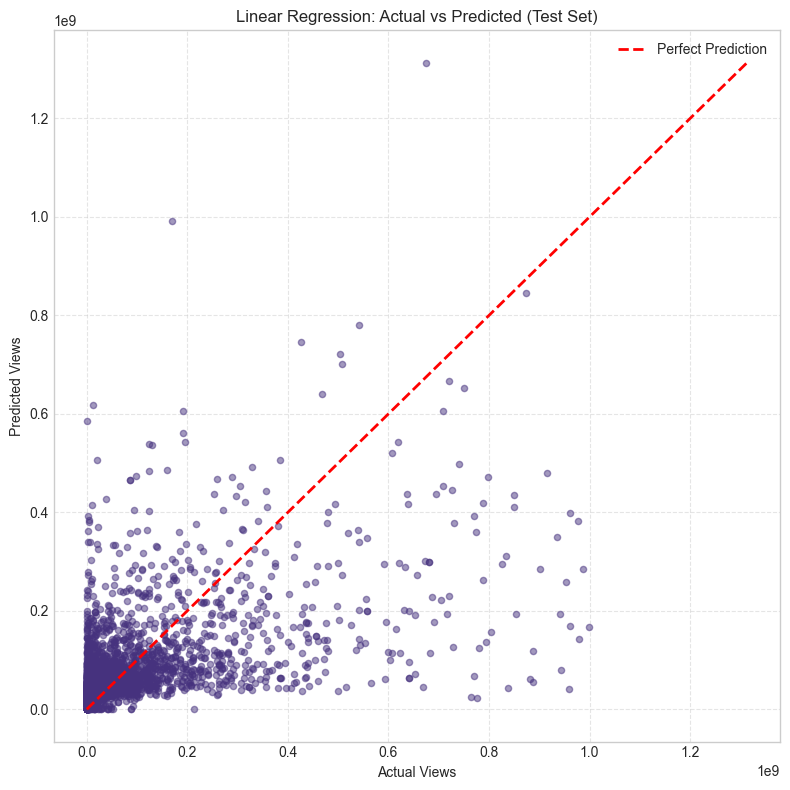

Residuals plot saved to results/linear_regression_residuals.png


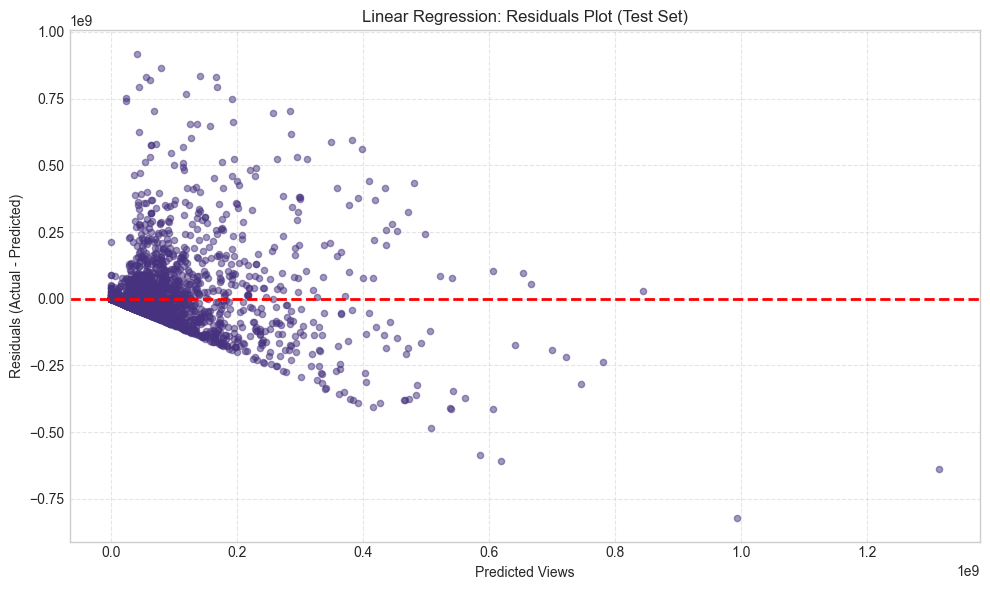

Log-transformed Actual vs Predicted plot saved to results/linear_regression_log_transformed.png


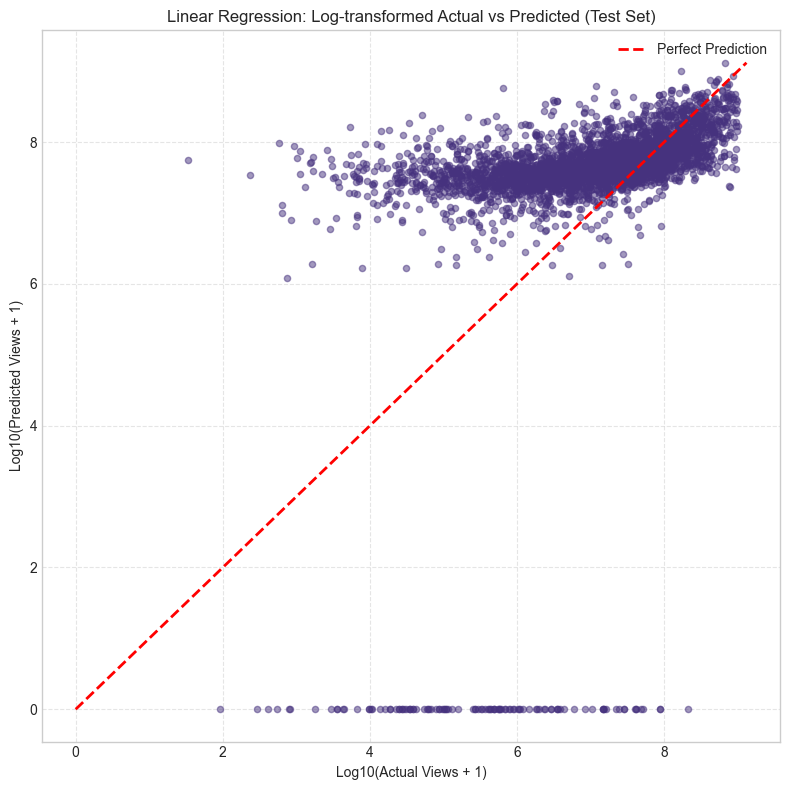


--- Basic Linear Regression Analysis Complete ---


In [49]:
print("\n--- 10: Basic Linear Regression Model ---")
lr_model = None
test_r2_lr = None # Initialize metrics to None
test_rmse_lr = None
test_mae_lr = None

if X_train is not None and y_train is not None and X_test is not None and y_test is not None:
    # Initialize and train the linear regression model
    print("Training a basic linear regression model on the train/test split...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions on both training and test sets
    y_train_pred_lr = lr_model.predict(X_train)
    y_test_pred_lr = lr_model.predict(X_test)
    # Ensure predictions are non-negative (views cannot be negative)
    y_test_pred_lr = np.maximum(0, y_test_pred_lr)

    # Evaluate model performance on the TEST set
    test_mse_lr = mean_squared_error(y_test, y_test_pred_lr)
    test_rmse_lr = math.sqrt(test_mse_lr)
    test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
    test_r2_lr = r2_score(y_test, y_test_pred_lr)

    # Evaluate performance on the TRAINING set (to check for overfitting)
    train_r2_lr = r2_score(y_train, y_train_pred_lr)

    # Print evaluation metrics
    print("\nLinear Regression Model Performance:")
    print(f"Training set R²: {train_r2_lr:.4f}")
    print(f"Test set R²:     {test_r2_lr:.4f}")
    print(f"Test set RMSE:   {test_rmse_lr:.2f}")
    print(f"Test set MAE:    {test_mae_lr:.2f}")


    # Check for feature importance (coefficients)
    try:
        feature_importance_lr = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': lr_model.coef_
        })
        feature_importance_lr['Abs_Coefficient'] = abs(feature_importance_lr['Coefficient'])
        feature_importance_lr = feature_importance_lr.sort_values('Abs_Coefficient', ascending=False)

        print("\nTop 10 features by absolute coefficient value:")
        print(feature_importance_lr.head(10))
    except Exception as e:
        print(f"Could not calculate feature importance: {e}")


    # Plot actual vs predicted values on test set
    plt.figure(figsize=(8, 8)) # Square plot
    plt.scatter(y_test, y_test_pred_lr, alpha=0.5, s=20)
    # Add 45-degree line (perfect prediction)
    min_val = min(y_test.min(), y_test_pred_lr.min())
    max_val = max(y_test.max(), y_test_pred_lr.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel(f'Actual {TARGET_COLUMN}')
    plt.ylabel(f'Predicted {TARGET_COLUMN}')
    plt.title('Linear Regression: Actual vs Predicted (Test Set)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    # Consider log scale if data is highly skewed
    # plt.xscale('log')
    # plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'linear_regression_actual_vs_predicted.png'))
    print(f"\nActual vs Predicted plot saved to {RESULTS_DIR}/linear_regression_actual_vs_predicted.png")
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    residuals_lr = y_test - y_test_pred_lr
    plt.scatter(y_test_pred_lr, residuals_lr, alpha=0.5, s=20)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel(f'Predicted {TARGET_COLUMN}')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title('Linear Regression: Residuals Plot (Test Set)')
    plt.grid(True, linestyle='--', alpha=0.5)
    # plt.xscale('log') # Optional log scale for predicted values if skewed
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'linear_regression_residuals.png'))
    print(f"Residuals plot saved to {RESULTS_DIR}/linear_regression_residuals.png")
    plt.show()

    # Plot log-transformed actual vs predicted for better visualization of skewed data
    # Add 1 to avoid log(0) or log of negative predictions
    y_test_log = np.log10(y_test + 1)
    y_test_pred_lr_log = np.log10(y_test_pred_lr + 1) # Already ensured non-negative

    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_log, y_test_pred_lr_log, alpha=0.5, s=20)
    min_log, max_log = min(y_test_log.min(), y_test_pred_lr_log.min()), max(y_test_log.max(), y_test_pred_lr_log.max())
    plt.plot([min_log, max_log], [min_log, max_log], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel(f'Log10(Actual {TARGET_COLUMN} + 1)')
    plt.ylabel(f'Log10(Predicted {TARGET_COLUMN} + 1)')
    plt.title('Linear Regression: Log-transformed Actual vs Predicted (Test Set)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'linear_regression_log_transformed.png'))
    print(f"Log-transformed Actual vs Predicted plot saved to {RESULTS_DIR}/linear_regression_log_transformed.png")
    plt.show()

else:
    print("Skipping Linear Regression as train/test data is not available.")

print("\n--- Basic Linear Regression Analysis Complete ---")


# ## Section 11: Classification by Binning View Counts (Helper Function & Distribution)
# - Define a function `categorize_views` to map continuous view counts into discrete categories based on predefined thresholds (<1M, 1M-10M, 10M-100M, 100M-1B).
# - Apply this function to the test set target (`y_test`) to create `y_test_binned`.
# - Visualize the distribution of these view categories in the test set.
# - **Note:** This section focuses on defining the binning logic and visualizing the resulting class distribution. A classifier (Random Forest) is trained on these bins *temporarily* in the next cell just to demonstrate classification metrics on the train/test split, but the primary classification evaluation uses cross-validation later.



--- 11: Defining View Categories and Checking Distribution ---
Converting train and test set target variables to 4 classification bins...
Created 'y_train_binned' with shape: (15098,)
Created 'y_test_binned' with shape: (3775,)

Distribution of View Categories in Test Set (4 Bins):
  <1M: 713 (18.9%)
  1M-10M: 920 (24.4%)
  10M-100M: 1450 (38.4%)
  100M-1B: 692 (18.3%)

View categories (4 bins) distribution plot saved to results/view_categories_test_distribution_4bins.png


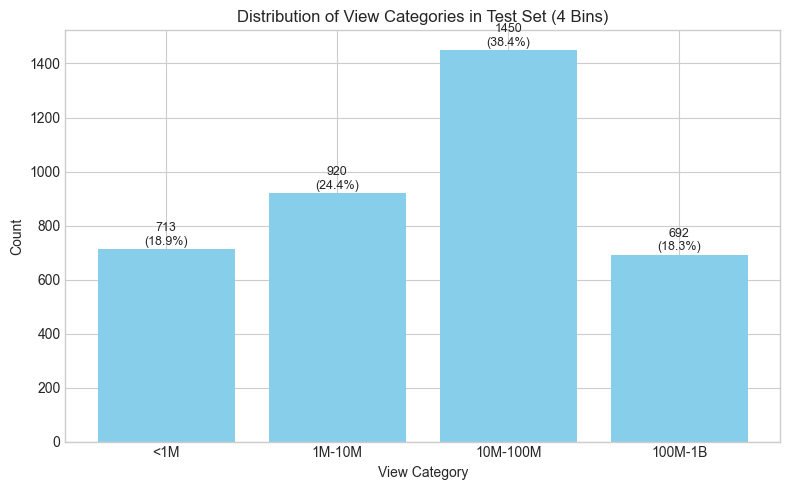

In [50]:
print("\n--- 11: Defining View Categories and Checking Distribution ---")

# Define view count bins based on project proposal (adjust thresholds if needed)
def categorize_views(views):
    """Categorize views into 4 groups based on magnitude."""
    if pd.isna(views): # Handle potential NaNs passed directly
        return -1 # Or some other indicator for missing/invalid
    elif views < 1_000_000:       # Less than 1 Million
        return 0
    elif views < 10_000_000:      # 1 Million - 10 Million
        return 1
    elif views < 100_000_000:     # 10 Million - 100 Million
        return 2
    # else: handles 100M to 1B (since >1B were removed)
    else:                         # 100 Million - 1 Billion
        return 3

# New function for SVM (2 categories)
def categorize_views_svm(views):
    """Categorize views into 2 groups for binary SVM Classification """
    if pd.isna(views):
        return -1 # Handle NaNs
    elif views < 10_000_000:  # Less than 10M
        return 0
    else: # 10M and above
        return 1

# Define category names for plotting/reporting (4 categories)
target_names = ['<1M', '1M-10M', '10M-100M', '100M-1B']
category_map = {i: name for i, name in enumerate(target_names)}
target_names_svm = ['<10M', '>=10M'] # For SVM

y_train_binned = None # Initialize
y_test_binned = None
if y_train is not None and y_test is not None:
    # Convert the train and test set targets to 4 classification bins
    print("Converting train and test set target variables to 4 classification bins...")
    y_train_binned = np.array([categorize_views(v) for v in y_train])
    y_test_binned = np.array([categorize_views(v) for v in y_test])
    print(f"Created 'y_train_binned' with shape: {y_train_binned.shape}")
    print(f"Created 'y_test_binned' with shape: {y_test_binned.shape}")

    # Display distribution of view categories in the test set
    unique_cats, counts = np.unique(y_test_binned, return_counts=True)
    category_counts_dict = dict(zip(unique_cats, counts))
    print("\nDistribution of View Categories in Test Set (4 Bins):")
    for i in range(len(target_names)):
        count = category_counts_dict.get(i, 0)
        percentage = (count / len(y_test_binned)) * 100 if len(y_test_binned) > 0 else 0
        print(f"  {target_names[i]}: {count} ({percentage:.1f}%)")

    plt.figure(figsize=(8, 5))
    bars = plt.bar(target_names, [category_counts_dict.get(i, 0) for i in range(len(target_names))], color='skyblue')
    plt.title('Distribution of View Categories in Test Set (4 Bins)')
    plt.xlabel('View Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    # Add count and percentage labels on bars
    for bar in bars:
        height = bar.get_height()
        count = int(height)
        percentage = (count / len(y_test_binned)) * 100 if len(y_test_binned) > 0 else 0
        plt.text(bar.get_x() + bar.get_width()/2., height + 5, # Adjusted y position slightly
                 f'{count}\n({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'view_categories_test_distribution_4bins.png')) # Updated filename
    print(f"\nView categories (4 bins) distribution plot saved to {RESULTS_DIR}/view_categories_test_distribution_4bins.png")
    plt.show()

else:
    print("Cannot create binned targets or visualize distribution because 'y_train' or 'y_test' is missing.")



# ## Section 11b: Example Classification on Binned Train/Test Split
# - Bin the training target (`y_train`) similarly to create `y_train_binned`.
# - **Scale** the training and testing features (`X_train`, `X_test`) using `StandardScaler`.
# - Train a `RandomForestClassifier` on the **scaled** training data and **binned** training target.
# - Evaluate the classifier on the **scaled** test data and **binned** test target using accuracy, precision, recall, F1-score, and a confusion matrix.
# - **Purpose:** This provides a baseline classification performance on the simple train/test split before moving to more robust cross-validation.



--- 11b: Example Classification on Binned Train/Test Split ---
Converting training set target variable to classification bins...
Created 'y_train_binned' with shape: (15098,)

Scaling features using StandardScaler...
Features scaled.

Training RandomForestClassifier on scaled train data and binned target...
Classifier trained.

Evaluating classifier on scaled test data and binned target...

Random Forest Classification Performance (Train/Test Split, Binned Target):
Accuracy:  0.5902
Precision: 0.5918 (weighted)
Recall:    0.5902 (weighted)
F1 Score:  0.5837 (weighted)

Detailed Classification Report (Train/Test Split, Binned Target):
              precision    recall  f1-score   support

         <1M       0.61      0.47      0.53       713
      1M-10M       0.50      0.42      0.46       920
    10M-100M       0.58      0.75      0.66      1450
     100M-1B       0.71      0.61      0.66       692

    accuracy                           0.59      3775
   macro avg       0.60      0.

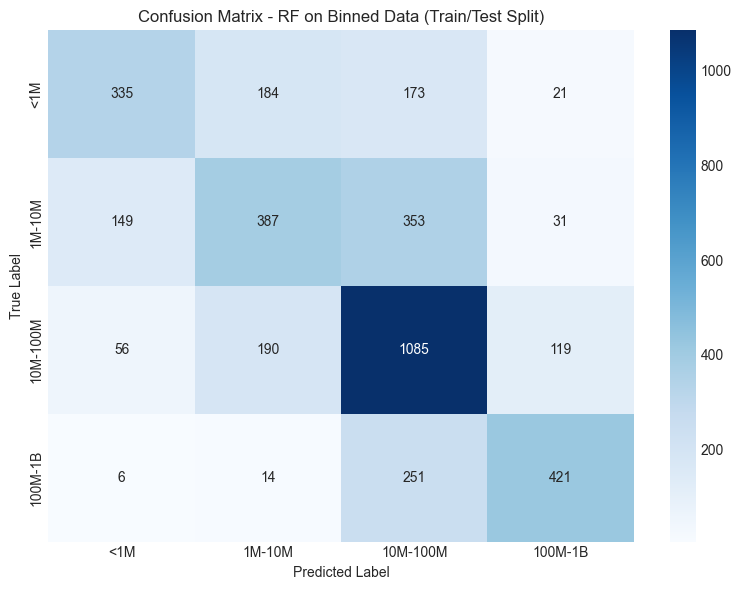


--- Example Classification Analysis Complete ---


In [51]:
print("\n--- 11b: Example Classification on Binned Train/Test Split ---")

y_train_binned = None
accuracy_rf_binned = None # Initialize metrics

if X_train is not None and y_train is not None and X_test is not None and y_test_binned is not None:
    # Bin the training target
    print("Converting training set target variable to classification bins...")
    y_train_binned = np.array([categorize_views(v) for v in y_train])
    print(f"Created 'y_train_binned' with shape: {y_train_binned.shape}")

    # Scale features for the classifier
    print("\nScaling features using StandardScaler...")
    scaler_clf_split = StandardScaler()
    X_train_scaled_clf = scaler_clf_split.fit_transform(X_train)
    X_test_scaled_clf = scaler_clf_split.transform(X_test)
    print("Features scaled.")

    # Fit a Random Forest classifier
    print("\nTraining RandomForestClassifier on scaled train data and binned target...")
    rf_classifier_binned_split = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_classifier_binned_split.fit(X_train_scaled_clf, y_train_binned)
    print("Classifier trained.")

    # Predictions and evaluation
    print("\nEvaluating classifier on scaled test data and binned target...")
    y_pred_binned_rf_split = rf_classifier_binned_split.predict(X_test_scaled_clf)

    # Calculate classification metrics
    accuracy_rf_binned = accuracy_score(y_test_binned, y_pred_binned_rf_split)
    precision_rf_binned = precision_score(y_test_binned, y_pred_binned_rf_split, average='weighted', zero_division=0)
    recall_rf_binned = recall_score(y_test_binned, y_pred_binned_rf_split, average='weighted', zero_division=0)
    f1_rf_binned = f1_score(y_test_binned, y_pred_binned_rf_split, average='weighted', zero_division=0)

    # Print classification metrics
    print("\nRandom Forest Classification Performance (Train/Test Split, Binned Target):")
    print(f"Accuracy:  {accuracy_rf_binned:.4f}")
    print(f"Precision: {precision_rf_binned:.4f} (weighted)")
    print(f"Recall:    {recall_rf_binned:.4f} (weighted)")
    print(f"F1 Score:  {f1_rf_binned:.4f} (weighted)")

    # Detailed classification report
    print("\nDetailed Classification Report (Train/Test Split, Binned Target):")
    # Use try-except for cases where some classes might not be predicted
    try:
        print(classification_report(y_test_binned, y_pred_binned_rf_split, target_names=target_names, zero_division=0))
    except ValueError as e:
        print(f"Could not generate full classification report: {e}")


    # Create confusion matrix
    cm_rf_binned_split = confusion_matrix(y_test_binned, y_pred_binned_rf_split, labels=range(len(target_names)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf_binned_split, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - RF on Binned Data (Train/Test Split)')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'rf_binned_train_test_confusion_matrix.png'))
    print(f"\nConfusion matrix saved to {RESULTS_DIR}/rf_binned_train_test_confusion_matrix.png")
    plt.show()

else:
    print("Skipping example classification as train/test data or binned targets are missing.")

print("\n--- Example Classification Analysis Complete ---")


# ## Section 12: Random Forest Regression with Cross-Validation
# - Define a pipeline containing `StandardScaler` and `RandomForestRegressor`.
# - Evaluate this pipeline using 5-fold cross-validation (`KFold`, `cross_val_predict`, `cross_val_score`) on the **entire dataset** (`X`, `y`).
# - Calculate cross-validated regression metrics (RMSE, MAE, R² mean & std).
# - **Bin** the cross-validated regression predictions and compare them to the binned true values to get cross-validated *classification* metrics derived from the regression model.
# - Visualize the R² scores across the folds.
# - Train the final pipeline on the entire dataset to extract and visualize feature importances.




--- 12: Random Forest Regression with 5-Fold Cross Validation ---
Initializing Random Forest regressor pipeline with StandardScaler...
Performing 5-fold cross-validation for regression...

Running cross-validation for regression metrics...

Random Forest Regression Performance (Cross-validated):
Cross-validated R²:   0.4780 (±0.0143)
Cross-validated RMSE: 100841432.84
Cross-validated MAE:  53425906.90

CV R² scores plot saved to results/rf_regression_cv_r2_scores.png


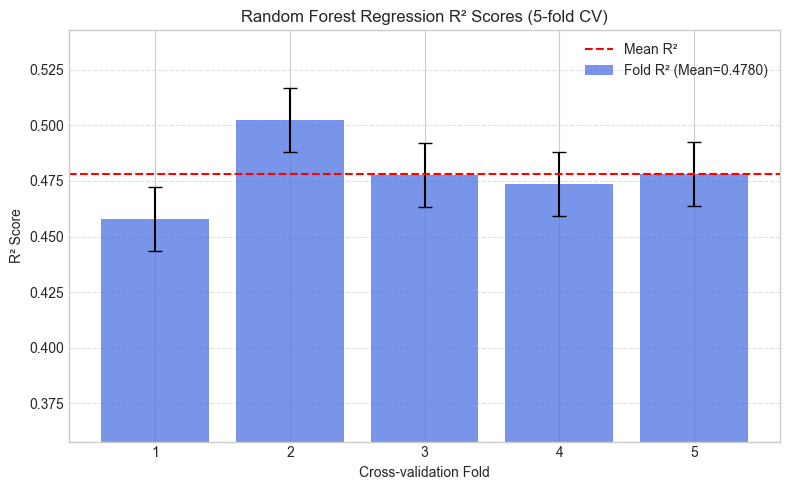


Converting cross-validated regression predictions to classification bins...
Evaluating classification metrics based on binned CV regression predictions...

RF Classification Performance (Derived from CV Regression Predictions):
Cross-validated Accuracy:  0.4903
Cross-validated Precision: 0.5512 (weighted)
Cross-validated Recall:    0.4903 (weighted)
Cross-validated F1 Score:  0.4283 (weighted)

Detailed Classification Report (Binned CV Regression Predictions):
              precision    recall  f1-score   support

         <1M       0.88      0.04      0.07      3607
      1M-10M       0.39      0.24      0.30      4706
    10M-100M       0.47      0.78      0.59      7027
     100M-1B       0.59      0.71      0.64      3533

    accuracy                           0.49     18873
   macro avg       0.58      0.44      0.40     18873
weighted avg       0.55      0.49      0.43     18873


Binned Regression CV confusion matrix saved to results/rf_binned_regression_cv_confusion_matrix.pn

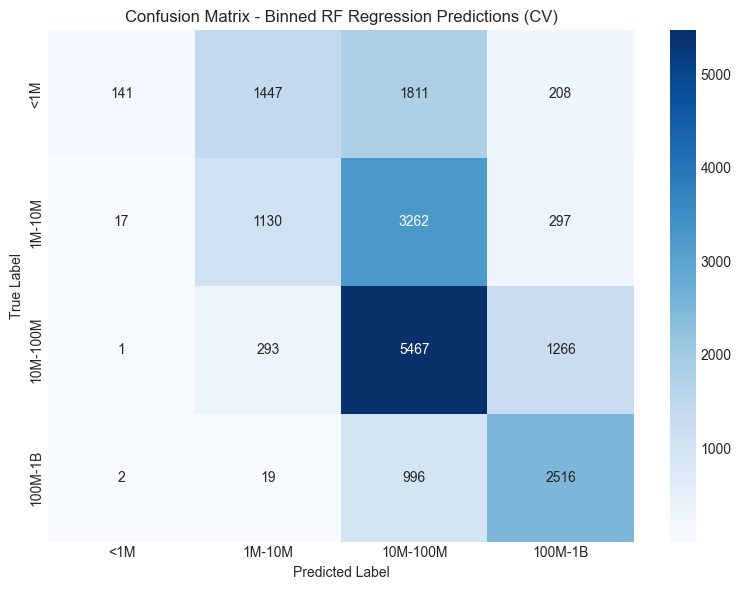


Training final RF Regression pipeline on entire dataset for feature importance...

Top 15 Features - Random Forest Regressor:
             Feature  Importance
16            Stream    0.383512
13       Duration_ms    0.076377
6           Loudness    0.066256
15           Channel    0.049983
3       Danceability    0.045408
12             Tempo    0.041590
8       Acousticness    0.040400
11           Valence    0.039473
10          Liveness    0.037124
1              Album    0.036220
7        Speechiness    0.034975
14             Title    0.034574
4             Energy    0.034527
0             Artist    0.026722
9   Instrumentalness    0.022056

Feature importance plot saved to results/rf_regression_feature_importance.png


/var/folders/2v/k3cldn7x0hq_bs2w355s8ggw0000gn/T/ipykernel_23919/714707072.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_rf_reg.head(15), palette='viridis')


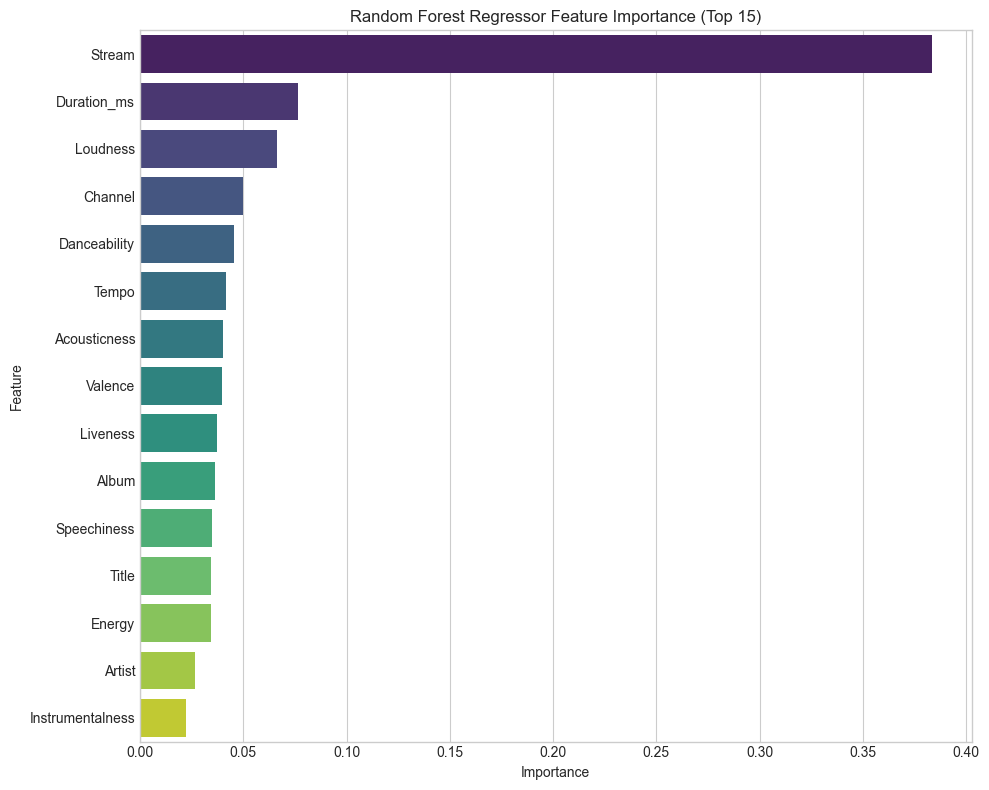


--- Random Forest Regression Analysis Complete ---


In [52]:
print("\n--- 12: Random Forest Regression with 5-Fold Cross Validation ---")

# Initialize metrics to None
r2_cv_rf, r2_cv_rf_std = None, None
rmse_cv_rf, mae_cv_rf = None, None
accuracy_cv_rf_from_reg = None
rf_pipeline_reg = None # Initialize pipeline

if X is not None and y is not None:
    # Initialize the Random Forest regressor pipeline
    print("Initializing Random Forest regressor pipeline with StandardScaler...")
    rf_pipeline_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators=100,     # Default, consider tuning
            random_state=RANDOM_STATE,
            n_jobs=-1             # Use all available cores
            # Consider adding other hyperparameters like max_depth, min_samples_leaf for tuning
        ))
    ])

    # Set up k-fold cross-validation
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)
    print(f"Performing {k_folds}-fold cross-validation for regression...")

    # --- Regression Evaluation ---
    print("\nRunning cross-validation for regression metrics...")
    # Get cross-validated predictions
    y_pred_cv_rf_reg = cross_val_predict(rf_pipeline_reg, X, y, cv=kf, n_jobs=-1)
    # Ensure predictions are non-negative
    y_pred_cv_rf_reg = np.maximum(0, y_pred_cv_rf_reg)

    # Calculate R² scores for each fold
    cv_r2_scores_rf = cross_val_score(rf_pipeline_reg, X, y, cv=kf, scoring='r2', n_jobs=-1)
    r2_cv_rf = cv_r2_scores_rf.mean()
    r2_cv_rf_std = cv_r2_scores_rf.std()

    # Calculate overall regression metrics from CV predictions
    rmse_cv_rf = np.sqrt(mean_squared_error(y, y_pred_cv_rf_reg))
    mae_cv_rf = mean_absolute_error(y, y_pred_cv_rf_reg)

    print("\nRandom Forest Regression Performance (Cross-validated):")
    print(f"Cross-validated R²:   {r2_cv_rf:.4f} (±{r2_cv_rf_std:.4f})")
    print(f"Cross-validated RMSE: {rmse_cv_rf:.2f}")
    print(f"Cross-validated MAE:  {mae_cv_rf:.2f}")

    # Plot R² scores across folds
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, k_folds + 1), cv_r2_scores_rf, yerr=r2_cv_rf_std, capsize=5, color='royalblue', alpha=0.7,
            label=f'Fold R² (Mean={r2_cv_rf:.4f})')
    plt.axhline(y=r2_cv_rf, color='red', linestyle='--', label=f'Mean R²')
    plt.xlabel('Cross-validation Fold')
    plt.ylabel('R² Score')
    plt.title('Random Forest Regression R² Scores (5-fold CV)')
    plt.ylim(bottom=max(-0.1, cv_r2_scores_rf.min() - 0.1)) # Adjust y-axis lower bound reasonably
    plt.xticks(range(1, k_folds + 1))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'rf_regression_cv_r2_scores.png'))
    print(f"\nCV R² scores plot saved to {RESULTS_DIR}/rf_regression_cv_r2_scores.png")
    plt.show()


    # --- Classification Evaluation (from Binned Regression Predictions) ---
    print("\nConverting cross-validated regression predictions to classification bins...")
    y_true_binned_cv = np.array([categorize_views(v) for v in y])
    y_pred_binned_cv_rf = np.array([categorize_views(v) for v in y_pred_cv_rf_reg]) # Already non-negative

    print("Evaluating classification metrics based on binned CV regression predictions...")
    # Calculate classification metrics
    accuracy_cv_rf_from_reg = accuracy_score(y_true_binned_cv, y_pred_binned_cv_rf)
    precision_cv_rf_from_reg = precision_score(y_true_binned_cv, y_pred_binned_cv_rf, average='weighted', zero_division=0)
    recall_cv_rf_from_reg = recall_score(y_true_binned_cv, y_pred_binned_cv_rf, average='weighted', zero_division=0)
    f1_cv_rf_from_reg = f1_score(y_true_binned_cv, y_pred_binned_cv_rf, average='weighted', zero_division=0)

    print("\nRF Classification Performance (Derived from CV Regression Predictions):")
    print(f"Cross-validated Accuracy:  {accuracy_cv_rf_from_reg:.4f}")
    print(f"Cross-validated Precision: {precision_cv_rf_from_reg:.4f} (weighted)")
    print(f"Cross-validated Recall:    {recall_cv_rf_from_reg:.4f} (weighted)")
    print(f"Cross-validated F1 Score:  {f1_cv_rf_from_reg:.4f} (weighted)")

    # Detailed classification report
    print("\nDetailed Classification Report (Binned CV Regression Predictions):")
    try:
        print(classification_report(y_true_binned_cv, y_pred_binned_cv_rf, target_names=target_names, zero_division=0))
    except ValueError as e:
        print(f"Could not generate full classification report: {e}")


    # Confusion matrix for binned CV regression predictions
    cm_rf_binned_reg_cv = confusion_matrix(y_true_binned_cv, y_pred_binned_cv_rf, labels=range(len(target_names)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf_binned_reg_cv, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Binned RF Regression Predictions (CV)')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'rf_binned_regression_cv_confusion_matrix.png'))
    print(f"\nBinned Regression CV confusion matrix saved to {RESULTS_DIR}/rf_binned_regression_cv_confusion_matrix.png")
    plt.show()

    # --- Feature Importance ---
    print("\nTraining final RF Regression pipeline on entire dataset for feature importance...")
    rf_pipeline_reg.fit(X, y)

    # Get feature importances
    try:
        importances = rf_pipeline_reg.named_steps['regressor'].feature_importances_
        feature_importance_rf_reg = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("\nTop 15 Features - Random Forest Regressor:")
        print(feature_importance_rf_reg.head(15))

        # Visualize feature importance
        plt.figure(figsize=(10, 8)) # Adjusted size
        sns.barplot(x='Importance', y='Feature', data=feature_importance_rf_reg.head(15), palette='viridis')
        plt.title('Random Forest Regressor Feature Importance (Top 15)')
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'rf_regression_feature_importance.png'))
        print(f"\nFeature importance plot saved to {RESULTS_DIR}/rf_regression_feature_importance.png")
        plt.show()
    except Exception as e:
        print(f"Could not extract or plot feature importances: {e}")

else:
    print("Skipping Random Forest Regression CV as features (X) or target (y) is missing.")

print("\n--- Random Forest Regression Analysis Complete ---")



# ## Section 14: Random Forest Classification Model with Cross-Validation
# - Bin the **entire** target variable `y` into `y_binned_full`.
# - Define a pipeline containing `StandardScaler` and `RandomForestClassifier`.
# - Evaluate this pipeline using 5-fold cross-validation directly on the full dataset (`X`, `y_binned_full`).
# - Calculate and report cross-validated classification metrics (Accuracy, Precision, Recall, F1 - mean & std).
# - Visualize the accuracy scores across folds and the confusion matrix based on cross-validated predictions.
# - Train the final classification pipeline on the entire dataset to extract and visualize feature importances specifically for the classification task.



--- 14: Random Forest Classification Model with Cross-Validation ---
Binning the full target variable 'y'...
Created 'y_binned_full' with shape: (18873,)

Initializing Random Forest classifier pipeline with StandardScaler...

Performing 5-fold cross-validation for classification...
Calculating CV accuracy...
  Mean accuracy: 0.5917 (±0.0089)
Calculating CV precision_weighted...
  Mean precision_weighted: 0.5984 (±0.0075)
Calculating CV recall_weighted...
  Mean recall_weighted: 0.5917 (±0.0089)
Calculating CV f1_weighted...
  Mean f1_weighted: 0.5858 (±0.0087)

Random Forest Classification Performance (Cross-validated):
Accuracy:  0.5917 (±0.0089)
Precision: 0.5984 (±0.0075) (weighted)
Recall:    0.5917 (±0.0089) (weighted)
F1 Score:  0.5858 (±0.0087) (weighted)

CV Accuracy scores plot saved to results/rf_classification_cv_accuracy_scores.png


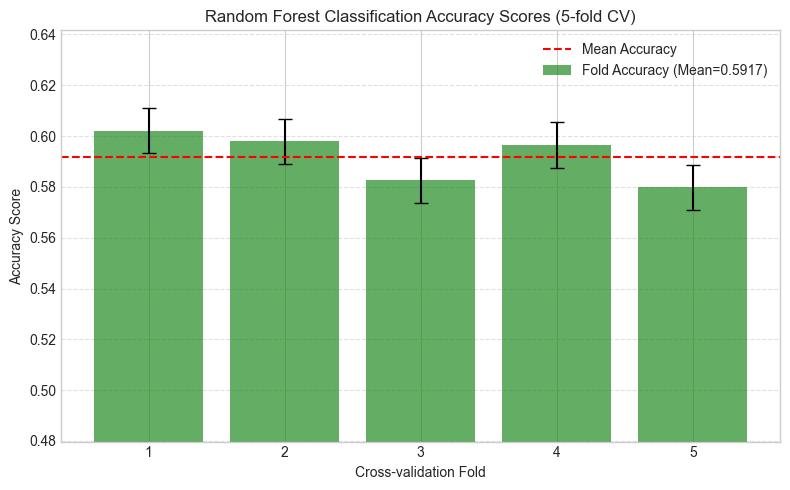


Getting cross-validated predictions for detailed report and confusion matrix...

Detailed Classification Report (Cross-validated Predictions):
              precision    recall  f1-score   support

         <1M       0.65      0.49      0.56      3607
      1M-10M       0.52      0.43      0.47      4706
    10M-100M       0.57      0.75      0.65      7027
     100M-1B       0.72      0.60      0.65      3533

    accuracy                           0.59     18873
   macro avg       0.61      0.57      0.58     18873
weighted avg       0.60      0.59      0.59     18873


CV Confusion matrix saved to results/rf_classification_cv_confusion_matrix.png


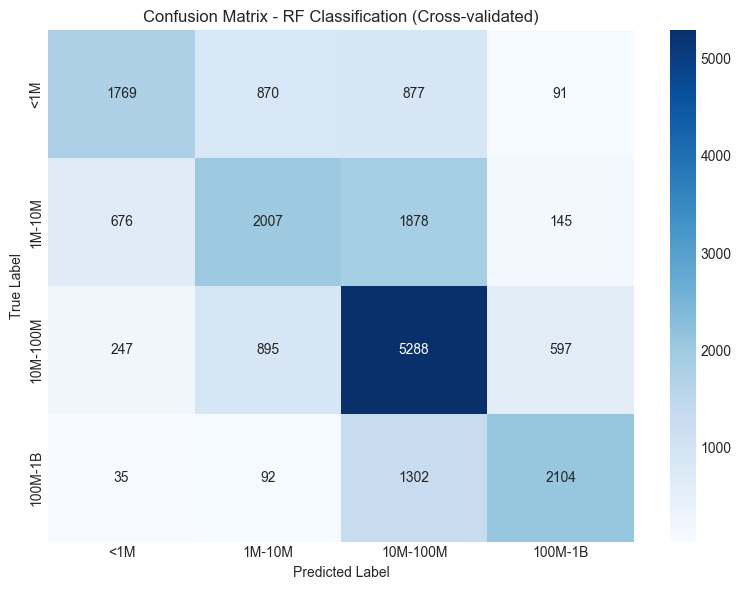


Training final RF Classification pipeline on entire dataset for feature importance...

Top 15 Features - Random Forest Classifier:
             Feature  Importance
16            Stream    0.195560
13       Duration_ms    0.068892
6           Loudness    0.066146
8       Acousticness    0.056504
15           Channel    0.055673
3       Danceability    0.054551
4             Energy    0.054375
7        Speechiness    0.054192
12             Tempo    0.053435
11           Valence    0.053043
10          Liveness    0.052982
14             Title    0.052291
1              Album    0.051339
0             Artist    0.047624
9   Instrumentalness    0.041955

Classification feature importance plot saved to results/rf_classification_feature_importance.png


/var/folders/2v/k3cldn7x0hq_bs2w355s8ggw0000gn/T/ipykernel_23919/2968867380.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_rf_clf.head(15), palette='viridis')


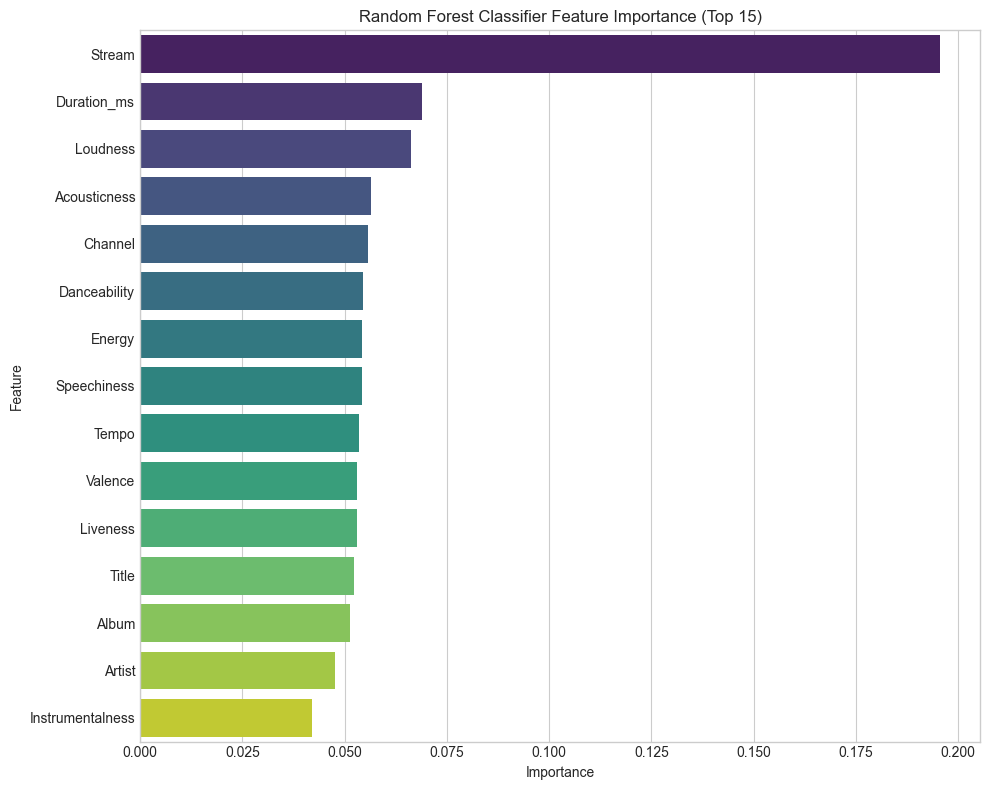


--- Random Forest Classification Analysis Complete ---


In [53]:
print("\n--- 14: Random Forest Classification Model with Cross-Validation ---")

# Initialize metrics to None
accuracy_mean_rf_clf, accuracy_std_rf_clf = None, None
precision_mean_rf_clf, precision_std_rf_clf = None, None
recall_mean_rf_clf, recall_std_rf_clf = None, None
f1_mean_rf_clf, f1_std_rf_clf = None, None
rf_pipeline_clf = None # Initialize pipeline

if X is not None and y is not None:
    # Prepare the binned target for the whole dataset
    print("Binning the full target variable 'y'...")
    y_binned_full = np.array([categorize_views(v) for v in y])
    print(f"Created 'y_binned_full' with shape: {y_binned_full.shape}")

    # Create classification pipeline
    print("\nInitializing Random Forest classifier pipeline with StandardScaler...")
    rf_pipeline_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
            # Consider adding class_weight='balanced' if classes are imbalanced
            # class_weight='balanced'
        ))
    ])

    # Use the same KFold setup as before
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)
    print(f"\nPerforming {k_folds}-fold cross-validation for classification...")

    # --- Classification Evaluation ---
    # Get scores with cross-validation using the pipeline
    # Use n_jobs=-1 for potentially faster execution
    scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    cv_scores_rf_clf = {}
    for metric in scoring_metrics:
        print(f"Calculating CV {metric}...")
        scores = cross_val_score(rf_pipeline_clf, X, y_binned_full, cv=kf, scoring=metric, n_jobs=-1)
        cv_scores_rf_clf[metric] = scores
        print(f"  Mean {metric}: {scores.mean():.4f} (±{scores.std():.4f})")


    # Calculate means and standard deviations
    accuracy_mean_rf_clf = cv_scores_rf_clf['accuracy'].mean()
    accuracy_std_rf_clf = cv_scores_rf_clf['accuracy'].std()
    precision_mean_rf_clf = cv_scores_rf_clf['precision_weighted'].mean()
    precision_std_rf_clf = cv_scores_rf_clf['precision_weighted'].std()
    recall_mean_rf_clf = cv_scores_rf_clf['recall_weighted'].mean()
    recall_std_rf_clf = cv_scores_rf_clf['recall_weighted'].std()
    f1_mean_rf_clf = cv_scores_rf_clf['f1_weighted'].mean()
    f1_std_rf_clf = cv_scores_rf_clf['f1_weighted'].std()

    print("\nRandom Forest Classification Performance (Cross-validated):")
    # Re-print summary metrics
    print(f"Accuracy:  {accuracy_mean_rf_clf:.4f} (±{accuracy_std_rf_clf:.4f})")
    print(f"Precision: {precision_mean_rf_clf:.4f} (±{precision_std_rf_clf:.4f}) (weighted)")
    print(f"Recall:    {recall_mean_rf_clf:.4f} (±{recall_std_rf_clf:.4f}) (weighted)")
    print(f"F1 Score:  {f1_mean_rf_clf:.4f} (±{f1_std_rf_clf:.4f}) (weighted)")


    # Plot accuracy scores across folds
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, k_folds + 1), cv_scores_rf_clf['accuracy'], yerr=accuracy_std_rf_clf, capsize=5, color='forestgreen', alpha=0.7,
            label=f'Fold Accuracy (Mean={accuracy_mean_rf_clf:.4f})')
    plt.axhline(y=accuracy_mean_rf_clf, color='red', linestyle='--', label=f'Mean Accuracy')
    plt.xlabel('Cross-validation Fold')
    plt.ylabel('Accuracy Score')
    plt.title('Random Forest Classification Accuracy Scores (5-fold CV)')
    plt.ylim(bottom=max(0, cv_scores_rf_clf['accuracy'].min() - 0.1)) # Ensure y-axis starts >= 0
    plt.xticks(range(1, k_folds + 1))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'rf_classification_cv_accuracy_scores.png'))
    print(f"\nCV Accuracy scores plot saved to {RESULTS_DIR}/rf_classification_cv_accuracy_scores.png")
    plt.show()

    # Get CV predictions for confusion matrix and detailed report
    print("\nGetting cross-validated predictions for detailed report and confusion matrix...")
    y_pred_cv_rf_clf = cross_val_predict(rf_pipeline_clf, X, y_binned_full, cv=kf, n_jobs=-1)

    # Detailed classification report from CV predictions
    print("\nDetailed Classification Report (Cross-validated Predictions):")
    try:
        print(classification_report(y_binned_full, y_pred_cv_rf_clf, target_names=target_names, zero_division=0))
    except ValueError as e:
        print(f"Could not generate full classification report: {e}")

    # Create confusion matrix from CV predictions
    cm_rf_clf_cv = confusion_matrix(y_binned_full, y_pred_cv_rf_clf, labels=range(len(target_names)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf_clf_cv, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - RF Classification (Cross-validated)')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'rf_classification_cv_confusion_matrix.png'))
    print(f"\nCV Confusion matrix saved to {RESULTS_DIR}/rf_classification_cv_confusion_matrix.png")
    plt.show()

    # --- Feature Importance ---
    print("\nTraining final RF Classification pipeline on entire dataset for feature importance...")
    rf_pipeline_clf.fit(X, y_binned_full)

    # Get and visualize feature importance
    try:
        importances_clf = rf_pipeline_clf.named_steps['classifier'].feature_importances_
        feature_importance_rf_clf = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances_clf
        }).sort_values('Importance', ascending=False)

        print("\nTop 15 Features - Random Forest Classifier:")
        print(feature_importance_rf_clf.head(15))

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_rf_clf.head(15), palette='viridis')
        plt.title('Random Forest Classifier Feature Importance (Top 15)')
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'rf_classification_feature_importance.png'))
        print(f"\nClassification feature importance plot saved to {RESULTS_DIR}/rf_classification_feature_importance.png")
        plt.show()
    except Exception as e:
        print(f"Could not extract or plot classification feature importances: {e}")

else:
    print("Skipping Random Forest Classification CV as features (X) or target (y) is missing.")

print("\n--- Random Forest Classification Analysis Complete ---")


# ## Section 15: Decision Tree Models with Cross-Validation
# - Evaluate simpler `DecisionTreeRegressor` and `DecisionTreeClassifier` models using the same 5-fold cross-validation setup as the Random Forests.
# - Define pipelines including `StandardScaler` for both regressor and classifier.
# - Report cross-validated regression (R², RMSE, MAE) and classification (Accuracy, Precision, Recall, F1) metrics.
# - Generate a detailed classification report and confusion matrix for the Decision Tree Classifier based on cross-validated predictions.



--- 15: Decision Tree Models with 5-Fold Cross Validation ---

Initializing Decision Tree regressor pipeline...
Performing cross-validation for Decision Tree Regressor...

Decision Tree Regression Performance (Cross-validated):
Cross-validated R²:   -0.0509 (±0.0565)
Cross-validated RMSE: 143067605.64
Cross-validated MAE:  67342666.94

Initializing Decision Tree classifier pipeline...

Performing cross-validation for Decision Tree Classifier...
Calculating CV accuracy...
  Mean accuracy: 0.4746 (±0.0084)
Calculating CV precision_weighted...
  Mean precision_weighted: 0.4753 (±0.0088)
Calculating CV recall_weighted...
  Mean recall_weighted: 0.4746 (±0.0084)
Calculating CV f1_weighted...
  Mean f1_weighted: 0.4748 (±0.0087)

Decision Tree Classification Performance (Cross-validated):
Accuracy:  0.4746 (±0.0084)
Precision: 0.4753 (±0.0088) (weighted)
Recall:    0.4746 (±0.0084) (weighted)
F1 Score:  0.4748 (±0.0087) (weighted)

Getting cross-validated predictions for DT Classifier...

D

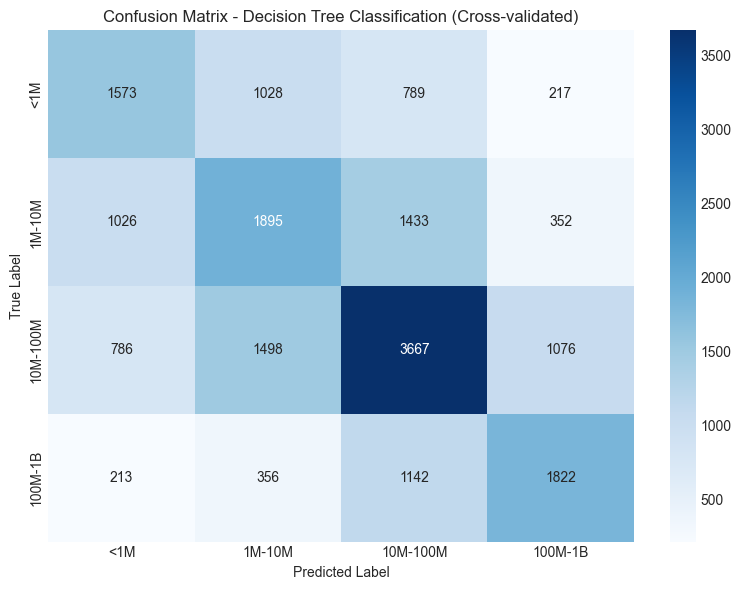


--- Decision Tree Analysis Complete ---


In [54]:
print("\n--- 15: Decision Tree Models with 5-Fold Cross Validation ---")

# Initialize metrics
r2_cv_dt, r2_cv_dt_std = None, None
rmse_cv_dt, mae_cv_dt = None, None
accuracy_mean_dt, accuracy_std_dt = None, None
precision_mean_dt, precision_std_dt = None, None
recall_mean_dt, recall_std_dt = None, None
f1_mean_dt, f1_std_dt = None, None
dt_pipeline_reg, dt_pipeline_clf = None, None # Initialize pipelines

if X is not None and y is not None:
    # Ensure binned target exists from previous step or create it
    if 'y_binned_full' not in locals() or y_binned_full is None:
        print("Binning the full target variable 'y' for Decision Tree...")
        y_binned_full = np.array([categorize_views(v) for v in y])
        print(f"Created 'y_binned_full' with shape: {y_binned_full.shape}")

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE) # Ensure kf exists

    # --- Decision Tree Regressor ---
    print("\nInitializing Decision Tree regressor pipeline...")
    dt_pipeline_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor(random_state=RANDOM_STATE)) # Default hyperparameters
    ])

    print("Performing cross-validation for Decision Tree Regressor...")
    # Get CV predictions
    y_pred_cv_dt_reg = cross_val_predict(dt_pipeline_reg, X, y, cv=kf, n_jobs=-1)
    y_pred_cv_dt_reg = np.maximum(0, y_pred_cv_dt_reg) # Ensure non-negative

    # Get R² scores
    cv_r2_scores_dt = cross_val_score(dt_pipeline_reg, X, y, cv=kf, scoring='r2', n_jobs=-1)
    r2_cv_dt = cv_r2_scores_dt.mean()
    r2_cv_dt_std = cv_r2_scores_dt.std()

    # Calculate other metrics from CV predictions
    rmse_cv_dt = np.sqrt(mean_squared_error(y, y_pred_cv_dt_reg))
    mae_cv_dt = mean_absolute_error(y, y_pred_cv_dt_reg)

    print("\nDecision Tree Regression Performance (Cross-validated):")
    print(f"Cross-validated R²:   {r2_cv_dt:.4f} (±{r2_cv_dt_std:.4f})")
    print(f"Cross-validated RMSE: {rmse_cv_dt:.2f}")
    print(f"Cross-validated MAE:  {mae_cv_dt:.2f}")


    # --- Decision Tree Classifier ---
    print("\nInitializing Decision Tree classifier pipeline...")
    dt_pipeline_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE)) # Default hyperparameters
         # Consider adding class_weight='balanced'
    ])

    print("\nPerforming cross-validation for Decision Tree Classifier...")
    # Calculate CV scores for classification metrics
    scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    cv_scores_dt_clf = {}
    for metric in scoring_metrics:
        print(f"Calculating CV {metric}...")
        scores = cross_val_score(dt_pipeline_clf, X, y_binned_full, cv=kf, scoring=metric, n_jobs=-1)
        cv_scores_dt_clf[metric] = scores
        print(f"  Mean {metric}: {scores.mean():.4f} (±{scores.std():.4f})")

    # Calculate means and standard deviations
    accuracy_mean_dt = cv_scores_dt_clf['accuracy'].mean()
    accuracy_std_dt = cv_scores_dt_clf['accuracy'].std()
    precision_mean_dt = cv_scores_dt_clf['precision_weighted'].mean()
    precision_std_dt = cv_scores_dt_clf['precision_weighted'].std()
    recall_mean_dt = cv_scores_dt_clf['recall_weighted'].mean()
    recall_std_dt = cv_scores_dt_clf['recall_weighted'].std()
    f1_mean_dt = cv_scores_dt_clf['f1_weighted'].mean()
    f1_std_dt = cv_scores_dt_clf['f1_weighted'].std()

    print("\nDecision Tree Classification Performance (Cross-validated):")
    # Re-print summary metrics
    print(f"Accuracy:  {accuracy_mean_dt:.4f} (±{accuracy_std_dt:.4f})")
    print(f"Precision: {precision_mean_dt:.4f} (±{precision_std_dt:.4f}) (weighted)")
    print(f"Recall:    {recall_mean_dt:.4f} (±{recall_std_dt:.4f}) (weighted)")
    print(f"F1 Score:  {f1_mean_dt:.4f} (±{f1_std_dt:.4f}) (weighted)")

    # Get CV predictions for detailed report and confusion matrix
    print("\nGetting cross-validated predictions for DT Classifier...")
    y_pred_cv_dt_clf = cross_val_predict(dt_pipeline_clf, X, y_binned_full, cv=kf, n_jobs=-1)

    # Detailed classification report
    print("\nDetailed Classification Report for Decision Tree (Cross-validated Predictions):")
    try:
        print(classification_report(y_binned_full, y_pred_cv_dt_clf, target_names=target_names, zero_division=0))
    except ValueError as e:
        print(f"Could not generate full classification report: {e}")

    # Create confusion matrix for Decision Tree Classifier
    cm_dt_clf_cv = confusion_matrix(y_binned_full, y_pred_cv_dt_clf, labels=range(len(target_names)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dt_clf_cv, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Decision Tree Classification (Cross-validated)')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'dt_classification_cv_confusion_matrix.png'))
    print(f"\nDecision Tree Classification CV confusion matrix saved to {RESULTS_DIR}/dt_classification_cv_confusion_matrix.png")
    plt.show()

else:
    print("Skipping Decision Tree CV as features (X) or target (y) is missing.")

print("\n--- Decision Tree Analysis Complete ---")


# ## Section 16: Evaluate Classifiers with SMOTE Resampling
# - Address the potential class imbalance observed in the binned target variable by incorporating SMOTE (Synthetic Minority Over-sampling Technique) into the classification pipelines.
# - Create new pipelines using `ImbPipeline` from `imblearn` that include `StandardScaler`, `SMOTE`, and the classifier (`RandomForestClassifier` or `DecisionTreeClassifier`).
# - Evaluate these SMOTE-enhanced pipelines using 5-fold cross-validation.
# - Report the cross-validated classification metrics (Accuracy, Precision, Recall, F1) for both RF and DT with SMOTE.
# - Generate detailed classification reports based on cross-validated predictions from the SMOTE pipelines.


In [55]:
print("\n--- 16: Evaluating Classifiers with SMOTE Oversampling --- ")

# Initialize metrics for SMOTE models
accuracy_mean_rf_smote, accuracy_std_rf_smote = None, None
precision_mean_rf_smote, precision_std_rf_smote = None, None
recall_mean_rf_smote, recall_std_rf_smote = None, None
f1_mean_rf_smote, f1_std_rf_smote = None, None

accuracy_mean_dt_smote, accuracy_std_dt_smote = None, None
precision_mean_dt_smote, precision_std_dt_smote = None, None
recall_mean_dt_smote, recall_std_dt_smote = None, None
f1_mean_dt_smote, f1_std_dt_smote = None, None

rf_pipeline_clf_smote, dt_pipeline_clf_smote = None, None # Initialize pipelines

if X is not None and y is not None:
    # Ensure binned target exists
    if 'y_binned_full' not in locals() or y_binned_full is None:
        print("Binning the full target variable 'y' for SMOTE evaluation...")
        y_binned_full = np.array([categorize_views(v) for v in y])
        print(f"Created 'y_binned_full' with shape: {y_binned_full.shape}")

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE) # Ensure kf exists

    # --- Random Forest Classifier with SMOTE ---
    print("\nInitializing Random Forest classifier pipeline with SMOTE...")
    # Use ImbPipeline to correctly handle SMOTE during cross-validation
    rf_pipeline_clf_smote = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=5)), # Default k_neighbors=5, adjust if needed based on minority class size
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
            # class_weight='balanced' might be less necessary with SMOTE, but could be tested
        ))
    ])

    print("Performing cross-validation for RF Classifier with SMOTE...")
    # Calculate CV scores
    scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    cv_scores_rf_smote = {}
    for metric in scoring_metrics:
        print(f"Calculating CV {metric} (RF + SMOTE)...")
        try:
            # SMOTE can sometimes fail if a fold has too few samples of a minority class for k_neighbors
            scores = cross_val_score(rf_pipeline_clf_smote, X, y_binned_full, cv=kf, scoring=metric, n_jobs=-1, error_score='raise')
            cv_scores_rf_smote[metric] = scores
            print(f"  Mean {metric}: {scores.mean():.4f} (±{scores.std():.4f})")
        except ValueError as e:
            print(f"  ERROR calculating {metric} with SMOTE: {e}. Setting score to NaN.")
            cv_scores_rf_smote[metric] = np.array([np.nan] * k_folds) # Store NaNs if calculation fails

    # Calculate means and standard deviations (handling potential NaNs)
    accuracy_mean_rf_smote = np.nanmean(cv_scores_rf_smote.get('accuracy', [np.nan]))
    accuracy_std_rf_smote = np.nanstd(cv_scores_rf_smote.get('accuracy', [np.nan]))
    precision_mean_rf_smote = np.nanmean(cv_scores_rf_smote.get('precision_weighted', [np.nan]))
    precision_std_rf_smote = np.nanstd(cv_scores_rf_smote.get('precision_weighted', [np.nan]))
    recall_mean_rf_smote = np.nanmean(cv_scores_rf_smote.get('recall_weighted', [np.nan]))
    recall_std_rf_smote = np.nanstd(cv_scores_rf_smote.get('recall_weighted', [np.nan]))
    f1_mean_rf_smote = np.nanmean(cv_scores_rf_smote.get('f1_weighted', [np.nan]))
    f1_std_rf_smote = np.nanstd(cv_scores_rf_smote.get('f1_weighted', [np.nan]))

    print("\nRandom Forest Classification Performance (SMOTE, Cross-validated):")
    # Re-print summary metrics
    print(f"Accuracy:  {accuracy_mean_rf_smote:.4f} (±{accuracy_std_rf_smote:.4f})")
    print(f"Precision: {precision_mean_rf_smote:.4f} (±{precision_std_rf_smote:.4f}) (weighted)")
    print(f"Recall:    {recall_mean_rf_smote:.4f} (±{recall_std_rf_smote:.4f}) (weighted)")
    print(f"F1 Score:  {f1_mean_rf_smote:.4f} (±{f1_std_rf_smote:.4f}) (weighted)")


    # Get CV predictions for detailed report
    print("\nGetting cross-validated predictions for RF (SMOTE)...")
    try:
        y_pred_cv_rf_smote = cross_val_predict(rf_pipeline_clf_smote, X, y_binned_full, cv=kf, n_jobs=-1)
        print("\nDetailed Classification Report for Random Forest (SMOTE, CV Predictions):")
        print(classification_report(y_binned_full, y_pred_cv_rf_smote, target_names=target_names, zero_division=0))
    except ValueError as e:
        print(f"Could not get CV predictions or generate report for RF with SMOTE: {e}")


    # --- Decision Tree Classifier with SMOTE ---
    print("\nInitializing Decision Tree classifier pipeline with SMOTE...")
    dt_pipeline_clf_smote = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
        ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
        # Consider adding class_weight='balanced' here too? Test effect.
    ])

    print("Performing cross-validation for DT Classifier with SMOTE...")
    # Calculate CV scores
    cv_scores_dt_smote = {}
    for metric in scoring_metrics:
        print(f"Calculating CV {metric} (DT + SMOTE)...")
        try:
            scores = cross_val_score(dt_pipeline_clf_smote, X, y_binned_full, cv=kf, scoring=metric, n_jobs=-1, error_score='raise')
            cv_scores_dt_smote[metric] = scores
            print(f"  Mean {metric}: {scores.mean():.4f} (±{scores.std():.4f})")
        except ValueError as e:
            print(f"  ERROR calculating {metric} with SMOTE: {e}. Setting score to NaN.")
            cv_scores_dt_smote[metric] = np.array([np.nan] * k_folds)

    # Calculate means and standard deviations (handling potential NaNs)
    accuracy_mean_dt_smote = np.nanmean(cv_scores_dt_smote.get('accuracy', [np.nan]))
    accuracy_std_dt_smote = np.nanstd(cv_scores_dt_smote.get('accuracy', [np.nan]))
    precision_mean_dt_smote = np.nanmean(cv_scores_dt_smote.get('precision_weighted', [np.nan]))
    precision_std_dt_smote = np.nanstd(cv_scores_dt_smote.get('precision_weighted', [np.nan]))
    recall_mean_dt_smote = np.nanmean(cv_scores_dt_smote.get('recall_weighted', [np.nan]))
    recall_std_dt_smote = np.nanstd(cv_scores_dt_smote.get('recall_weighted', [np.nan]))
    f1_mean_dt_smote = np.nanmean(cv_scores_dt_smote.get('f1_weighted', [np.nan]))
    f1_std_dt_smote = np.nanstd(cv_scores_dt_smote.get('f1_weighted', [np.nan]))

    print("\nDecision Tree Classification Performance (SMOTE, Cross-validated):")
    # Re-print summary metrics
    print(f"Accuracy:  {accuracy_mean_dt_smote:.4f} (±{accuracy_std_dt_smote:.4f})")
    print(f"Precision: {precision_mean_dt_smote:.4f} (±{precision_std_dt_smote:.4f}) (weighted)")
    print(f"Recall:    {recall_mean_dt_smote:.4f} (±{recall_std_dt_smote:.4f}) (weighted)")
    print(f"F1 Score:  {f1_mean_dt_smote:.4f} (±{f1_std_dt_smote:.4f}) (weighted)")

    # Get CV predictions for detailed report
    print("\nGetting cross-validated predictions for DT (SMOTE)...")
    try:
        y_pred_cv_dt_smote = cross_val_predict(dt_pipeline_clf_smote, X, y_binned_full, cv=kf, n_jobs=-1)
        print("\nDetailed Classification Report for Decision Tree (SMOTE, CV Predictions):")
        print(classification_report(y_binned_full, y_pred_cv_dt_smote, target_names=target_names, zero_division=0))
    except ValueError as e:
        print(f"Could not get CV predictions or generate report for DT with SMOTE: {e}")

else:
    print("Skipping SMOTE evaluation as features (X) or target (y) is missing.")

print("\n--- SMOTE Evaluation Complete ---")



--- 16: Evaluating Classifiers with SMOTE Oversampling --- 

Initializing Random Forest classifier pipeline with SMOTE...
Performing cross-validation for RF Classifier with SMOTE...
Calculating CV accuracy (RF + SMOTE)...
  Mean accuracy: 0.5693 (±0.0076)
Calculating CV precision_weighted (RF + SMOTE)...
  Mean precision_weighted: 0.5669 (±0.0078)
Calculating CV recall_weighted (RF + SMOTE)...
  Mean recall_weighted: 0.5693 (±0.0076)
Calculating CV f1_weighted (RF + SMOTE)...
  Mean f1_weighted: 0.5675 (±0.0076)

Random Forest Classification Performance (SMOTE, Cross-validated):
Accuracy:  0.5693 (±0.0076)
Precision: 0.5669 (±0.0078) (weighted)
Recall:    0.5693 (±0.0076) (weighted)
F1 Score:  0.5675 (±0.0076) (weighted)

Getting cross-validated predictions for RF (SMOTE)...

Detailed Classification Report for Random Forest (SMOTE, CV Predictions):
              precision    recall  f1-score   support

         <1M       0.56      0.56      0.56      3607
      1M-10M       0.47      

# ## Section 16.5: Stacking Classifier (kNN + Decision Tree)
# - Define  bins for view counts 
# - Apply binning to `y_train` and `y_test`.
# - Train a `StackingClassifier` using `KNeighborsClassifier` and `DecisionTreeClassifier` as base estimators and `LogisticRegression` as the final estimator on **scaled** data.
# - Evaluate the model on the train and test sets using standard classification metrics and confusion matrices.


In [56]:
print("\n--- 16.5: Stacking Classifier (kNN + Decision Tree) ---")
# Imports specific to this section (consider moving to top if running as a single script)
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is imported if not already global
import matplotlib.pyplot as plt # Ensure plt is imported if not already global
import os # Ensure os is imported

# Define bins and labels (4 categories)
knn_bins = [0, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000]
knn_labels = [1, 2, 3, 4] # Using numerical labels for pd.cut

knn_test_accuracy = None # Initialize metric for saving

# Check if train/test data exists from the main script part
if 'X_train' in locals() and 'y_train' in locals() and 'X_test' in locals() and 'y_test' in locals() and X_train is not None:
    # Adjust training and testing values using pandas.cut
    # Important: Ensure y_train/y_test are pandas Series for .cut
    if not isinstance(y_train, pd.Series): y_train_series = pd.Series(y_train)
    else: y_train_series = y_train
    if not isinstance(y_test, pd.Series): y_test_series = pd.Series(y_test)
    else: y_test_series = y_test

    print("Applying 4-category binning to target variable...")
    # Handle potential NaN values resulting from edge cases in pd.cut if necessary
    # include_lowest=True ensures the 0 lower bound is included.
    knn_y_train = pd.cut(y_train_series, bins=knn_bins, labels=knn_labels, right=False, include_lowest=True)
    knn_y_test = pd.cut(y_test_series, bins=knn_bins, labels=knn_labels, right=False, include_lowest=True)

    # --- Scaling Features ---
    # Stacking benefits from scaled features for base estimators like kNN
    print("Scaling features for Stacking Classifier...")
    scaler_stacking = StandardScaler() # Use a new scaler instance
    X_train_scaled_stack = scaler_stacking.fit_transform(X_train)
    X_test_scaled_stack = scaler_stacking.transform(X_test)
    print("Features scaled.")

    # Drop rows where binning might have resulted in NaN (if any)
    # Align X and y by dropping NaNs from the binned targets first
    train_nan_indices = knn_y_train.isna()
    test_nan_indices = knn_y_test.isna()

    if train_nan_indices.any() or test_nan_indices.any():
        print("Warning: NaN values found after binning. Dropping corresponding rows.")
        X_train_scaled_stack = X_train_scaled_stack[~train_nan_indices]
        knn_y_train = knn_y_train.dropna()
        X_test_scaled_stack = X_test_scaled_stack[~test_nan_indices]
        knn_y_test = knn_y_test.dropna()
        print("Rows with NaN target dropped.")


    # Initialize and train the Stacking Classifier Model
    # Base estimators: Decision Tree and kNN
    # Final estimator: Logistic Regression
    print("Initializing and training Stacking Classifier model (DT + kNN -> LogReg)...")
    estimators = [
        ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
        ('knn', KNeighborsClassifier()) # Default n_neighbors=5
    ]
    stack_model = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        cv=5 # Use cross-validation within stacking for base predictions
    )

    # Fit the model on SCALED training data and valid binned target
    stack_model.fit(X_train_scaled_stack, knn_y_train)
    print("Stacking Classifier trained.")

    # Predictions on SCALED training and test data
    print("Making predictions...")
    knn_train_pred = stack_model.predict(X_train_scaled_stack)
    knn_test_pred = stack_model.predict(X_test_scaled_stack)

    # Evaluate model performance (using the already cleaned knn_y_train/test)
    print("Evaluating model performance...")
    knn_train_confusion = confusion_matrix(knn_y_train, knn_train_pred, labels=knn_labels)
    knn_test_confusion = confusion_matrix(knn_y_test, knn_test_pred, labels=knn_labels)
    knn_train_cm_disp = ConfusionMatrixDisplay(confusion_matrix=knn_train_confusion, display_labels=knn_labels)
    knn_test_cm_disp = ConfusionMatrixDisplay(confusion_matrix=knn_test_confusion, display_labels=knn_labels)

    knn_train_accuracy = accuracy_score(knn_y_train, knn_train_pred)
    knn_test_accuracy = accuracy_score(knn_y_test, knn_test_pred)
    knn_train_precision = precision_score(knn_y_train, knn_train_pred, average='weighted', zero_division=0)
    knn_test_precision = precision_score(knn_y_test, knn_test_pred, average='weighted', zero_division=0)
    knn_train_recall = recall_score(knn_y_train, knn_train_pred, average='weighted', zero_division=0)
    knn_test_recall = recall_score(knn_y_test, knn_test_pred, average='weighted', zero_division=0)
    knn_train_f1 = f1_score(knn_y_train, knn_train_pred, average='weighted', zero_division=0)
    knn_test_f1 = f1_score(knn_y_test, knn_test_pred, average='weighted', zero_division=0)

    # Print Evaluations
    print("\nStacking Classification (DT+kNN->LogReg) Model Performance (4 Bins):")
    print(f"  Training set accuracy:  {knn_train_accuracy:.4f}")
    print(f"  Testing set accuracy:   {knn_test_accuracy:.4f}")
    print(f"  Training set precision: {knn_train_precision:.4f} (weighted)")
    print(f"  Testing set precision:  {knn_test_precision:.4f} (weighted)")
    print(f"  Training set recall:    {knn_train_recall:.4f} (weighted)")
    print(f"  Testing set recall:     {knn_test_recall:.4f} (weighted)")
    print(f"  Training set F1-Score:  {knn_train_f1:.4f} (weighted)")
    print(f"  Testing set F1-Score:   {knn_test_f1:.4f} (weighted)")

    # Plotting Confusion Matrices
    # Training CM
    fig_train_cm, ax_train_cm = plt.subplots(figsize=(7, 6))
    knn_train_cm_disp.plot(ax=ax_train_cm, cmap='Blues')
    plt.title("Stacking Classifier Confusion Matrix (Training Set)")
    plt.tight_layout()
    train_cm_path = os.path.join(RESULTS_DIR, 'stacking_knn_train_confusion_matrix.png')
    plt.savefig(train_cm_path)
    plt.close(fig_train_cm) # Close the specific figure
    print(f"\nTraining confusion matrix saved to: {train_cm_path}")

    # Testing CM
    fig_test_cm, ax_test_cm = plt.subplots(figsize=(7, 6))
    knn_test_cm_disp.plot(ax=ax_test_cm, cmap='Blues')
    plt.title("Stacking Classifier Confusion Matrix (Testing Set)")
    plt.tight_layout()
    test_cm_path = os.path.join(RESULTS_DIR, 'stacking_knn_test_confusion_matrix.png')
    plt.savefig(test_cm_path)
    plt.close(fig_test_cm) # Close the specific figure
    print(f"Testing confusion matrix saved to: {test_cm_path}")

    # Print classification report for test set
    print("\nStacking Classifier Detailed Report (Testing Set):\n",
          classification_report(knn_y_test, knn_test_pred, labels=knn_labels, target_names=[str(l) for l in knn_labels], zero_division=0))

    # Add metrics to the main dictionary (if it exists and Section 19 is reached)
    # Note: This assumes Section 19 initializes 'model_metrics_structured'
    if 'model_metrics_structured' in locals():
        print("Adding Stacking Classifier metrics to results dictionary...")
        model_metrics_structured['Stacking_kNN_DT_LogReg_5Bins'] = {
            'Test_Accuracy': knn_test_accuracy,
            'Test_Precision_Weighted': knn_test_precision,
            'Test_Recall_Weighted': knn_test_recall,
            'Test_F1_Weighted': knn_test_f1
        }
    else:
        print("Warning: 'model_metrics_structured' dictionary not found. Cannot save Stacking metrics.")

else:
    print("Skipping Stacking Classifier section because training/testing data is missing.")

print("\n--- Stacking Classifier (kNN + DT) Analysis Complete ---")


--- 16.5: Stacking Classifier (kNN + Decision Tree) ---
Applying 4-category binning to target variable...
Scaling features for Stacking Classifier...
Features scaled.
Initializing and training Stacking Classifier model (DT + kNN -> LogReg)...
Stacking Classifier trained.
Making predictions...
Evaluating model performance...

Stacking Classification (DT+kNN->LogReg) Model Performance (4 Bins):
  Training set accuracy:  0.9327
  Testing set accuracy:   0.5015
  Training set precision: 0.9381 (weighted)
  Testing set precision:  0.4986 (weighted)
  Training set recall:    0.9327 (weighted)
  Testing set recall:     0.5015 (weighted)
  Training set F1-Score:  0.9320 (weighted)
  Testing set F1-Score:   0.4920 (weighted)

Training confusion matrix saved to: results/stacking_knn_train_confusion_matrix.png
Testing confusion matrix saved to: results/stacking_knn_test_confusion_matrix.png

Stacking Classifier Detailed Report (Testing Set):
               precision    recall  f1-score   support

# ## Section 17: Model Comparison Visualization (Regression R²)
# Create a bar chart comparing the mean cross-validated R² scores of the Random Forest and Decision Tree **regression** models evaluated in Sections 12 and 15. Include error bars representing the standard deviation across the folds.



--- 17: Generating Comparison Plot for Regression Models (R²) ---
Regression model R² comparison plot saved to results/regression_model_r2_comparison.png


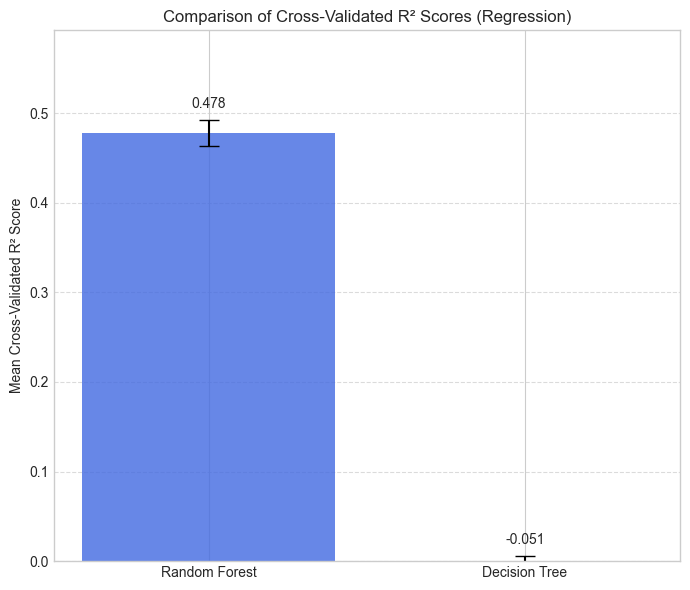

In [57]:
print("\n--- 17: Generating Comparison Plot for Regression Models (R²) ---")

# Check if the necessary R² metrics exist from previous sections
if 'r2_cv_rf' in locals() and r2_cv_rf is not None and \
   'r2_cv_dt' in locals() and r2_cv_dt is not None and \
   'r2_cv_rf_std' in locals() and r2_cv_rf_std is not None and \
   'r2_cv_dt_std' in locals() and r2_cv_dt_std is not None:

    # Data for the plot
    model_names_reg = ['Random Forest', 'Decision Tree']
    r2_means = [r2_cv_rf, r2_cv_dt]
    r2_stds = [r2_cv_rf_std, r2_cv_dt_std]

    plt.figure(figsize=(7, 6)) # Slightly smaller width
    x_pos = np.arange(len(model_names_reg))

    bars = plt.bar(x_pos, r2_means, yerr=r2_stds, capsize=7, color=['royalblue', 'forestgreen'], alpha=0.8)

    plt.ylabel('Mean Cross-Validated R² Score')
    plt.title('Comparison of Cross-Validated R² Scores (Regression)')
    plt.xticks(x_pos, model_names_reg)
    # Adjust y-limits dynamically based on values
    min_val = min([m - s for m, s in zip(r2_means, r2_stds)])
    max_val = max([m + s for m, s in zip(r2_means, r2_stds)])
    plt.ylim(bottom=max(0, min_val - 0.1), top=min(1.0, max_val + 0.1)) # Ensure y-axis starts >= 0 and ends <= 1 reasonably
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels for mean values slightly above the error bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height + r2_stds[i] + 0.01, # Position above error bar
                 f"{r2_means[i]:.3f}",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    comparison_plot_file_reg = os.path.join(RESULTS_DIR, 'regression_model_r2_comparison.png')
    plt.savefig(comparison_plot_file_reg)
    print(f"Regression model R² comparison plot saved to {comparison_plot_file_reg}")
    plt.show()
else:
    print("Skipping regression comparison plot as required R² metrics (r2_cv_rf, r2_cv_dt, etc.) are missing.")



# ## Section 18: Model Comparison Visualization (Classification Accuracy)
# Create a bar chart comparing the mean cross-validated **Accuracy** scores of the Random Forest and Decision Tree **classification** models evaluated in Sections 14 and 15 (the versions *without* SMOTE are typically used for the primary comparison). Include error bars representing the standard deviation.



--- 18: Generating Comparison Plot for Classification Models (Accuracy) ---
Classification model accuracy comparison plot saved to results/classification_model_accuracy_comparison.png


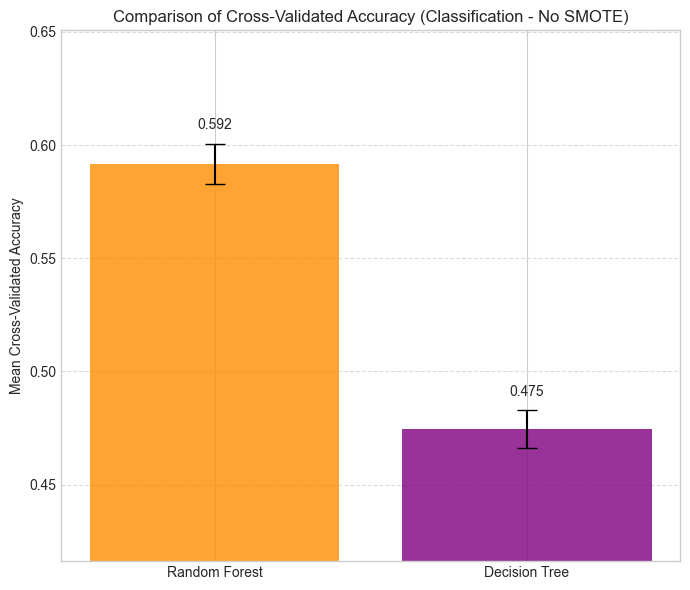

In [58]:
print("\n--- 18: Generating Comparison Plot for Classification Models (Accuracy) ---")

# Check if the necessary Accuracy metrics exist from previous sections (using non-SMOTE results)
if 'accuracy_mean_rf_clf' in locals() and accuracy_mean_rf_clf is not None and \
   'accuracy_mean_dt' in locals() and accuracy_mean_dt is not None and \
   'accuracy_std_rf_clf' in locals() and accuracy_std_rf_clf is not None and \
   'accuracy_std_dt' in locals() and accuracy_std_dt is not None:

    # Data for the plot (using non-SMOTE results for primary comparison)
    model_names_clf = ['Random Forest', 'Decision Tree']
    accuracy_means = [accuracy_mean_rf_clf, accuracy_mean_dt]
    accuracy_stds = [accuracy_std_rf_clf, accuracy_std_dt]

    plt.figure(figsize=(7, 6)) # Slightly smaller width
    x_pos = np.arange(len(model_names_clf))

    bars = plt.bar(x_pos, accuracy_means, yerr=accuracy_stds, capsize=7, color=['darkorange', 'purple'], alpha=0.8)

    plt.ylabel('Mean Cross-Validated Accuracy')
    plt.title('Comparison of Cross-Validated Accuracy (Classification - No SMOTE)')
    plt.xticks(x_pos, model_names_clf)
    # Adjust y-limits dynamically
    min_val = min([m - s for m, s in zip(accuracy_means, accuracy_stds)])
    max_val = max([m + s for m, s in zip(accuracy_means, accuracy_stds)])
    plt.ylim(bottom=max(0, min_val - 0.05), top=min(1.0, max_val + 0.05)) # Ensure y-axis starts >= 0 and ends <= 1 reasonably
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels for mean values
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height + accuracy_stds[i] + 0.005, # Position above error bar
                 f"{accuracy_means[i]:.3f}",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    clf_comparison_plot_file = os.path.join(RESULTS_DIR, 'classification_model_accuracy_comparison.png')
    plt.savefig(clf_comparison_plot_file)
    print(f"Classification model accuracy comparison plot saved to {clf_comparison_plot_file}")
    plt.show()
else:
    print("Skipping classification comparison plot as required Accuracy metrics (accuracy_mean_rf_clf, accuracy_mean_dt, etc.) are missing.")



# ## Section 19: Save Metrics for Reporting
# Consolidate all calculated model evaluation metrics (from train/test splits and cross-validation, including SMOTE results) into a nested dictionary. Remove any entries where the metric calculation failed (value is `None`). Save this dictionary to a JSON file (`model_metrics.json`) in the `results` directory for easy access and reporting.


In [59]:
print("\n--- 19: Saving Metrics for Reporting ---")

# Update the existing dictionary with results from other sections
# Using locals().get() to safely access variables
# Initialize with None if the variable might not exist

print("Updating metrics dictionary with results from all models...")
# Linear Regression Results (Section 10)
model_metrics_structured['LinearRegression_TrainTest'] = {
    'Test_R2': locals().get('test_r2_lr'),
    'Test_RMSE': locals().get('test_rmse_lr'),
    'Test_MAE': locals().get('test_mae_lr')
}

# Random Forest Regression Results (Section 12)
model_metrics_structured['RF_Regression_CV'] = {
    'CV_R2_Mean': locals().get('r2_cv_rf'), 'CV_R2_Std': locals().get('r2_cv_rf_std'),
    'CV_RMSE': locals().get('rmse_cv_rf'), 'CV_MAE': locals().get('mae_cv_rf'),
    'ClassifAccuracy_from_BinnedReg': locals().get('accuracy_cv_rf_from_reg')
}

# Random Forest Classification Results (Section 14)
model_metrics_structured['RF_Classification_CV'] = {
    'CV_Accuracy_Mean': locals().get('accuracy_mean_rf_clf'), 'CV_Accuracy_Std': locals().get('accuracy_std_rf_clf'),
    'CV_Precision_Weighted_Mean': locals().get('precision_mean_rf_clf'), 'CV_Precision_Weighted_Std': locals().get('precision_std_rf_clf'),
    'CV_Recall_Weighted_Mean': locals().get('recall_mean_rf_clf'), 'CV_Recall_Std': locals().get('recall_std_rf_clf'),
    'CV_F1_Weighted_Mean': locals().get('f1_mean_rf_clf'), 'CV_F1_Std': locals().get('f1_std_rf_clf')
}

# Decision Tree Regression Results (Section 15)
model_metrics_structured['DT_Regression_CV'] = {
     'CV_R2_Mean': locals().get('r2_cv_dt'), 'CV_R2_Std': locals().get('r2_cv_dt_std'),
     'CV_RMSE': locals().get('rmse_cv_dt'), 'CV_MAE': locals().get('mae_cv_dt')
}

# Decision Tree Classification Results (Section 15)
model_metrics_structured['DT_Classification_CV'] = {
    'CV_Accuracy_Mean': locals().get('accuracy_mean_dt'), 'CV_Accuracy_Std': locals().get('accuracy_std_dt'),
    'CV_Precision_Weighted_Mean': locals().get('precision_mean_dt'), 'CV_Precision_Weighted_Std': locals().get('precision_std_dt'),
    'CV_Recall_Weighted_Mean': locals().get('recall_mean_dt'), 'CV_Recall_Std': locals().get('recall_std_dt'),
    'CV_F1_Weighted_Mean': locals().get('f1_mean_dt'), 'CV_F1_Std': locals().get('f1_std_dt')
}

# Random Forest Classification SMOTE Results (Section 16)
model_metrics_structured['RF_Classification_SMOTE_CV'] = {
    'CV_Accuracy_Mean': locals().get('accuracy_mean_rf_smote'), 'CV_Accuracy_Std': locals().get('accuracy_std_rf_smote'),
    'CV_Precision_Weighted_Mean': locals().get('precision_mean_rf_smote'), 'CV_Precision_Weighted_Std': locals().get('precision_std_rf_smote'),
    'CV_Recall_Weighted_Mean': locals().get('recall_mean_rf_smote'), 'CV_Recall_Std': locals().get('recall_std_rf_smote'),
    'CV_F1_Weighted_Mean': locals().get('f1_mean_rf_smote'), 'CV_F1_Std': locals().get('f1_std_rf_smote')
}

# Decision Tree Classification SMOTE Results (Section 16)
model_metrics_structured['DT_Classification_SMOTE_CV'] = {
    'CV_Accuracy_Mean': locals().get('accuracy_mean_dt_smote'), 'CV_Accuracy_Std': locals().get('accuracy_std_dt_smote'),
    'CV_Precision_Weighted_Mean': locals().get('precision_mean_dt_smote'), 'CV_Precision_Std': locals().get('precision_std_dt_smote'),
    'CV_Recall_Weighted_Mean': locals().get('recall_mean_dt_smote'), 'CV_Recall_Std': locals().get('recall_std_dt_smote'),
    'CV_F1_Weighted_Mean': locals().get('f1_mean_dt_smote'), 'CV_F1_Std': locals().get('f1_std_dt_smote')
}

# (Stacking classifier metrics were added in Section 16.5)

# Function to recursively remove None values from the dictionary
def remove_none_values(item):
    if isinstance(item, dict):
        return {k: remove_none_values(v) for k, v in item.items() if v is not None and remove_none_values(v) is not None}
    elif isinstance(item, list):
        cleaned_list = [remove_none_values(v) for v in item if v is not None]
        return cleaned_list if cleaned_list else None
    else:
        # Specifically check for np.nan as well
        return item if pd.notna(item) else None

model_metrics_cleaned = remove_none_values(model_metrics_structured)

# Save cleaned metrics to a JSON file
metrics_file = os.path.join(RESULTS_DIR, 'model_metrics.json')
try:
    with open(metrics_file, 'w') as f:
        json.dump(model_metrics_cleaned, f, indent=4, default=lambda x: None if pd.isna(x) else x) # Handle potential remaining NaN
    print(f"\nCleaned model metrics saved to {metrics_file}")

    # Optional: Print the saved metrics nicely
    import pprint
    print("\nSaved Metrics:")
    pprint.pprint(model_metrics_cleaned)

except TypeError as e:
     print(f"Error saving metrics to JSON (likely due to non-serializable type): {e}")
     print("Problematic data:", model_metrics_cleaned)
except Exception as e:
    print(f"An error occurred while saving metrics: {e}")


print("\n--- Metrics Saving Complete ---")



--- 19: Saving Metrics for Reporting ---
Updating metrics dictionary with results from all models...

Cleaned model metrics saved to results/model_metrics.json

Saved Metrics:
{'DT_Classification_CV': {'CV_Accuracy_Mean': np.float64(0.47459393479962236),
                          'CV_Accuracy_Std': np.float64(0.00840062901205784),
                          'CV_F1_Std': np.float64(0.008672171342992032),
                          'CV_F1_Weighted_Mean': np.float64(0.4748015453853873),
                          'CV_Precision_Weighted_Mean': np.float64(0.47531015162182816),
                          'CV_Precision_Weighted_Std': np.float64(0.008811017689109555),
                          'CV_Recall_Std': np.float64(0.00840062901205784),
                          'CV_Recall_Weighted_Mean': np.float64(0.47459393479962236)},
 'DT_Classification_SMOTE_CV': {'CV_Accuracy_Mean': np.float64(0.46219489922333706),
                                'CV_Accuracy_Std': np.float64(0.008245310493333888),
 

# ## Section 20: Visualizing a Decision Tree (Example)
# - To understand how the Decision Tree models make predictions, train shallow versions (e.g., `max_depth=3`) on the original **unscaled** train/test split data.
# - Visualize the structure of both the classification tree (predicting view categories) and the regression tree (predicting raw view counts).
# - **Note:** These visualized trees are *not* the cross-validated models used for performance evaluation but are simpler examples for interpretability. Using unscaled data might make the split points easier to interpret directly.



--- 20: Visualizing a Shallow Decision Tree (Example) ---

Training and visualizing shallow Classification Tree (max_depth=3)...
Example Classification Decision Tree visualization saved to results/decision_tree_clf_visualization.png


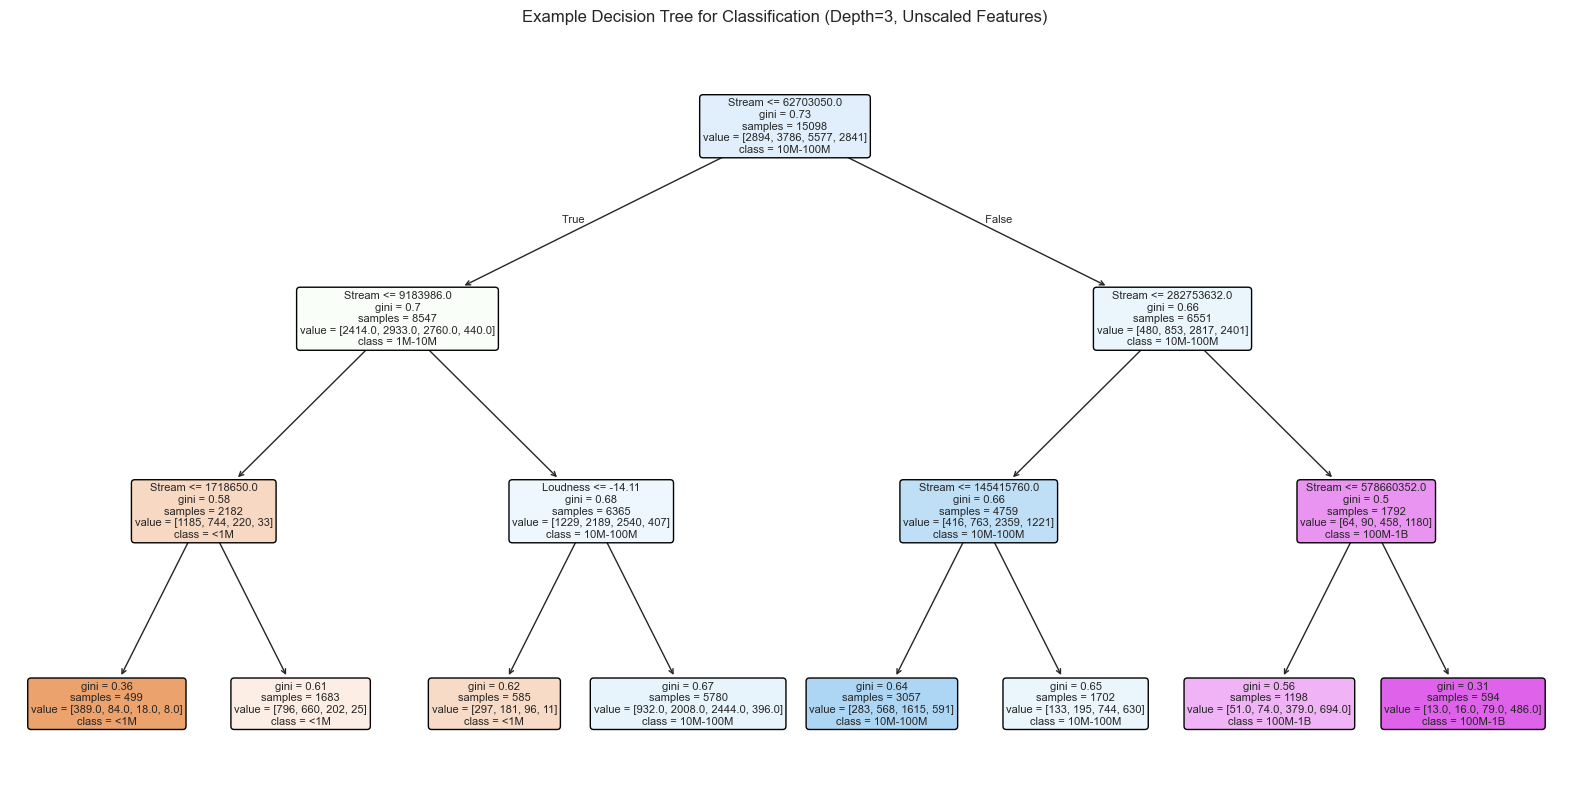


Training and visualizing shallow Regression Tree (max_depth=3)...
Example Regression Decision Tree visualization saved to results/decision_tree_reg_visualization.png


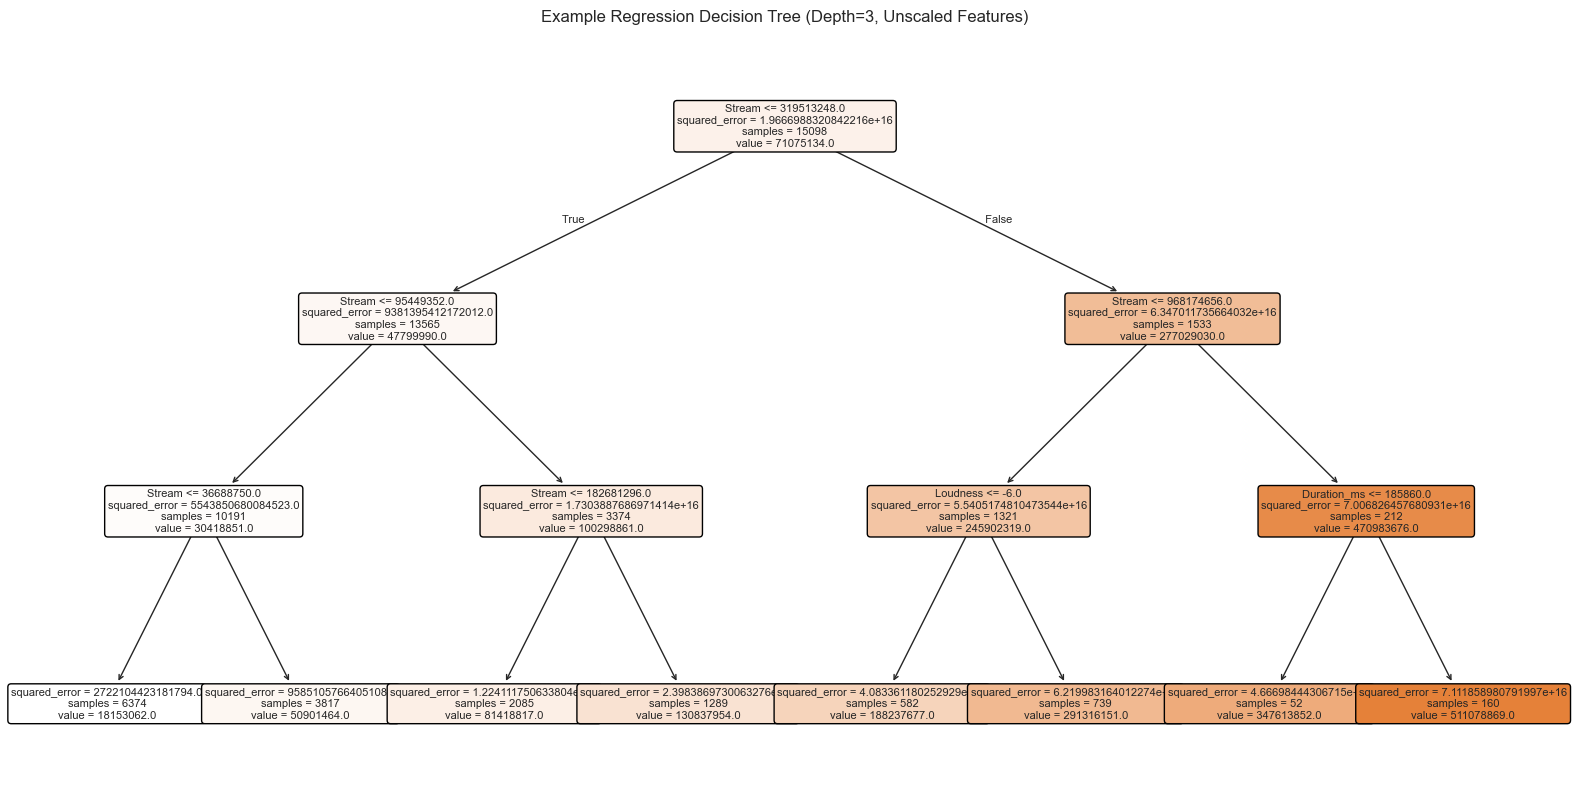


--- Decision Tree Visualization Complete ---


In [60]:
print("\n--- 20: Visualizing a Shallow Decision Tree (Example) ---")

# Check if necessary data exists (original train split, binned train target)
if X_train is not None and y_train is not None and 'y_train_binned' in locals() and y_train_binned is not None:

    # --- Classification Tree Visualization ---
    print("\nTraining and visualizing shallow Classification Tree (max_depth=3)...")
    # Use original X_train (unscaled) and y_train_binned
    dt_classifier_viz = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
    dt_classifier_viz.fit(X_train, y_train_binned)

    plt.figure(figsize=(20, 10)) # Wide figure for tree
    plot_tree(dt_classifier_viz,
              filled=True,
              feature_names=X.columns.tolist(),
              class_names=target_names, # Use names defined earlier
              rounded=True,
              precision=2, # Show decimals for thresholds
              fontsize=8)  # Adjust fontsize as needed
    plt.title('Example Decision Tree for Classification (Depth=3, Unscaled Features)')
    # plt.tight_layout() # Sometimes causes issues with plot_tree, try adjusting figsize first
    dt_viz_clf_file = os.path.join(RESULTS_DIR, 'decision_tree_clf_visualization.png')
    try:
        plt.savefig(dt_viz_clf_file, bbox_inches='tight') # Use bbox_inches='tight'
        print(f"Example Classification Decision Tree visualization saved to {dt_viz_clf_file}")
    except Exception as e:
        print(f"Could not save classification tree plot: {e}")
    plt.show()


    # --- Regression Tree Visualization ---
    print("\nTraining and visualizing shallow Regression Tree (max_depth=3)...")
     # Use original X_train (unscaled) and y_train
    dt_regressor_viz = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)
    dt_regressor_viz.fit(X_train, y_train)

    plt.figure(figsize=(20, 10)) # Wide figure
    plot_tree(dt_regressor_viz,
              filled=True,
              feature_names=X.columns.tolist(),
              rounded=True,
              precision=0, # Display node values (predicted views) as integers
              fontsize=8)
    plt.title('Example Regression Decision Tree (Depth=3, Unscaled Features)')
    # plt.tight_layout()
    dt_viz_reg_file = os.path.join(RESULTS_DIR, 'decision_tree_reg_visualization.png')
    try:
        plt.savefig(dt_viz_reg_file, bbox_inches='tight')
        print(f"Example Regression Decision Tree visualization saved to {dt_viz_reg_file}")
    except Exception as e:
        print(f"Could not save regression tree plot: {e}")
    plt.show()

else:
    print("Skipping Decision Tree visualization as required training data (X_train, y_train, y_train_binned) is missing.")

print("\n--- Decision Tree Visualization Complete ---")


# ## Section 21: AdaBoost Models (Regressor and Classifier)
# - Train and evaluate an AdaBoost Regressor.
# - Train and evaluate an AdaBoost Classifier on the 4-bin target.


In [61]:
print("\n--- 21: AdaBoost Models (Regressor and Classifier) ---")

# Initialize metrics for saving
ab_reg_r2, ab_reg_rmse, ab_reg_mae = None, None, None
ab_clf_accuracy, ab_clf_precision, ab_clf_recall, ab_clf_f1 = None, None, None, None

if X_train is not None and y_train is not None and X_test is not None and y_test is not None and y_train_binned is not None and y_test_binned is not None:

    # --- AdaBoost Regressor ---
    print("\nTraining AdaBoost Regressor...")
    abregr = AdaBoostRegressor(n_estimators=100, random_state=RANDOM_STATE)
    abregr.fit(X_train, y_train)
    y_pred_ab_reg = abregr.predict(X_test)
    y_pred_ab_reg = np.maximum(0, y_pred_ab_reg) # Ensure non-negative

    ab_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ab_reg))
    ab_reg_mae = mean_absolute_error(y_test, y_pred_ab_reg)
    ab_reg_r2 = r2_score(y_test, y_pred_ab_reg)

    print("\n--- AdaBoost Regressor Evaluation ---")
    print(f"Test R²: {ab_reg_r2:.4f}")
    print(f"Test RMSE: {ab_reg_rmse:,.2f}")
    print(f"Test MAE: {ab_reg_mae:,.2f}")

    # --- AdaBoost Classifier ---
    print("\nTraining AdaBoost Classifier...")
    abclas = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE)
    abclas.fit(X_train, y_train_binned)
    y_pred_ab_clf = abclas.predict(X_test)

    ab_clf_accuracy = accuracy_score(y_test_binned, y_pred_ab_clf)
    ab_clf_precision = precision_score(y_test_binned, y_pred_ab_clf, average='weighted', zero_division=0)
    ab_clf_recall = recall_score(y_test_binned, y_pred_ab_clf, average='weighted', zero_division=0)
    ab_clf_f1 = f1_score(y_test_binned, y_pred_ab_clf, average='weighted', zero_division=0)

    print("\n--- AdaBoost Classifier Evaluation (4 Bins) ---")
    print(f"Accuracy: {ab_clf_accuracy:.4f}")
    print(f"Precision (Weighted): {ab_clf_precision:.4f}")
    print(f"Recall (Weighted): {ab_clf_recall:.4f}")
    print(f"F1-Score (Weighted): {ab_clf_f1:.4f}")

    print("\nClassification Report (AdaBoost Classifier):")
    print(classification_report(y_test_binned, y_pred_ab_clf, target_names=target_names, zero_division=0))

    # Confusion Matrix for AdaBoostClassifier
    print("Generating Confusion Matrix for AdaBoost Classifier...")
    cm_ab_clf = confusion_matrix(y_test_binned, y_pred_ab_clf, labels=range(len(target_names)))
    disp_ab_clf = ConfusionMatrixDisplay(confusion_matrix=cm_ab_clf, display_labels=target_names)

    plt.figure()
    disp_ab_clf.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - AdaBoost Classifier (4 Bins)")
    ab_cm_path = os.path.join(RESULTS_DIR, 'adaboost_classifier_confusion_matrix.png')
    plt.savefig(ab_cm_path)
    print(f"AdaBoost Classifier confusion matrix saved to {ab_cm_path}")
    plt.close()

else:
    print("Skipping AdaBoost models as required data (X_train, y_train, etc.) is missing.")

print("\n--- AdaBoost Models Analysis Complete ---")



--- 21: AdaBoost Models (Regressor and Classifier) ---

Training AdaBoost Regressor...

--- AdaBoost Regressor Evaluation ---
Test R²: 0.0160
Test RMSE: 135,989,009.72
Test MAE: 99,903,560.74

Training AdaBoost Classifier...

--- AdaBoost Classifier Evaluation (4 Bins) ---
Accuracy: 0.5248
Precision (Weighted): 0.5188
Recall (Weighted): 0.5248
F1-Score (Weighted): 0.5153

Classification Report (AdaBoost Classifier):
              precision    recall  f1-score   support

         <1M       0.54      0.44      0.49       713
      1M-10M       0.44      0.32      0.37       920
    10M-100M       0.53      0.67      0.59      1450
     100M-1B       0.57      0.58      0.58       692

    accuracy                           0.52      3775
   macro avg       0.52      0.50      0.51      3775
weighted avg       0.52      0.52      0.52      3775

Generating Confusion Matrix for AdaBoost Classifier...
AdaBoost Classifier confusion matrix saved to results/adaboost_classifier_confusion_matri

<Figure size 640x480 with 0 Axes>

# ## Section 22: k-Nearest Neighbors Regressor with Grid Search
# - Perform Grid Search to find the best hyperparameters for kNN Regressor.
# - Evaluate the best kNN Regressor model.


In [62]:
print("\n--- 22: kNN Regressor with Grid Search ---")

gs_knn_best_params = None
gs_knn_r2, gs_knn_rmse, gs_knn_mae = None, None, None

if X_train is not None and y_train is not None and X_test is not None and y_test is not None:
    print("Performing Grid Search for kNN Regressor...")
    knn = KNeighborsRegressor()

    param_grid_knn = {
        'n_neighbors': [3, 5, 7, 10, 15], # Expanded range slightly
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1: Manhattan, 2: Euclidean
    }
    grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='r2', n_jobs=-1) # Use R2 scoring
    grid_search_knn.fit(X_train, y_train)

    gs_knn_best_params = grid_search_knn.best_params_
    print(f"Best parameters found for kNN Regressor: {gs_knn_best_params}")

    # Evaluate the best model found by Grid Search
    best_knn = grid_search_knn.best_estimator_
    y_pred_gs_knn = best_knn.predict(X_test)
    y_pred_gs_knn = np.maximum(0, y_pred_gs_knn) # Ensure non-negative

    gs_knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gs_knn))
    gs_knn_mae = mean_absolute_error(y_test, y_pred_gs_knn)
    gs_knn_r2 = r2_score(y_test, y_pred_gs_knn)

    print("\n--- Grid Search kNN Regressor Evaluation ---")
    print(f"Best Model Test R²: {gs_knn_r2:.4f}")
    print(f"Best Model Test RMSE: {gs_knn_rmse:,.2f}")
    print(f"Best Model Test MAE: {gs_knn_mae:,.2f}")
else:
    print("Skipping kNN Grid Search as required data (X_train, y_train, etc.) is missing.")

print("\n--- kNN Regressor Grid Search Complete ---")



--- 22: kNN Regressor with Grid Search ---
Performing Grid Search for kNN Regressor...
Best parameters found for kNN Regressor: {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}

--- Grid Search kNN Regressor Evaluation ---
Best Model Test R²: 0.3584
Best Model Test RMSE: 109,808,066.36
Best Model Test MAE: 55,630,108.17

--- kNN Regressor Grid Search Complete ---


# ## Section 23: Support Vector Machine (SVM) Classifier with Grid Search
# - Define a binary target variable (e.g., <10M views vs >=10M views).
# - Perform Grid Search for SVM hyperparameters.
# - Evaluate the best SVM model.


In [63]:
print("\n--- 23: SVM Classifier with Grid Search (Binary Target) ---")

# Initialize metrics
gs_svm_best_params = None
gs_svm_accuracy, gs_svm_precision, gs_svm_recall, gs_svm_f1 = None, None, None, None

# Generate binary target variables for SVM
y_train_svm, y_test_svm = None, None
if y_train is not None and y_test is not None:
    print("Generating binary target variables (<10M vs >=10M) for SVM...")
    y_train_svm = np.array([categorize_views_svm(v) for v in y_train])
    y_test_svm = np.array([categorize_views_svm(v) for v in y_test])
    print(f"Created 'y_train_svm' ({len(y_train_svm)}) and 'y_test_svm' ({len(y_test_svm)}) shapes.")

    # Check distribution
    unique_svm, counts_svm = np.unique(y_test_svm, return_counts=True)
    print("Binary Target Distribution (Test Set):")
    for label, count in zip(unique_svm, counts_svm):
        print(f"  Class {target_names_svm[label]}: {count}")

if X_train is not None and y_train_svm is not None and X_test is not None and y_test_svm is not None:
    print("\nPerforming Grid Search for SVM Classifier...")
    # Note: SVM can be computationally expensive, especially with large C values or complex kernels
    parameters_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']} # Example parameters
    svc = svm.SVC(probability=True, random_state=RANDOM_STATE) # probability=True useful but slower
    clf_svm_gs = GridSearchCV(svc, parameters_svm, cv=3, scoring='accuracy', n_jobs=-1) # Use fewer CV folds if slow

    # Consider scaling features for SVM if not already done in a pipeline
    # If using raw X_train/X_test, scaling is highly recommended for SVM
    print("Scaling features for SVM GridSearch...")
    scaler_svm = StandardScaler()
    X_train_scaled_svm = scaler_svm.fit_transform(X_train)
    X_test_scaled_svm = scaler_svm.transform(X_test)
    print("Features scaled.")

    clf_svm_gs.fit(X_train_scaled_svm, y_train_svm)

    gs_svm_best_params = clf_svm_gs.best_params_
    print(f"Best parameters found for SVM: {gs_svm_best_params}")

    # Evaluate the best model found by Grid Search
    best_svm = clf_svm_gs.best_estimator_
    y_pred_gs_svm = best_svm.predict(X_test_scaled_svm)

    gs_svm_accuracy = accuracy_score(y_test_svm, y_pred_gs_svm)
    gs_svm_precision = precision_score(y_test_svm, y_pred_gs_svm, average='weighted', zero_division=0)
    gs_svm_recall = recall_score(y_test_svm, y_pred_gs_svm, average='weighted', zero_division=0)
    gs_svm_f1 = f1_score(y_test_svm, y_pred_gs_svm, average='weighted', zero_division=0)

    print("\n--- Grid Search SVM Classifier Evaluation (Binary Target) ---")
    print(f"Best Model Accuracy: {gs_svm_accuracy:.4f}")
    print(f"Best Model Precision (Weighted): {gs_svm_precision:.4f}")
    print(f"Best Model Recall (Weighted): {gs_svm_recall:.4f}")
    print(f"Best Model F1-Score (Weighted): {gs_svm_f1:.4f}")

    print("\nClassification Report (Grid Search SVM Classifier):")
    print(classification_report(y_test_svm, y_pred_gs_svm, target_names=target_names_svm, zero_division=0))

    # Confusion Matrix for GridSearchSVM
    print("Generating Confusion Matrix for Grid Search SVM Classifier...")
    cm_gs_svm = confusion_matrix(y_test_svm, y_pred_gs_svm, labels=range(len(target_names_svm)))
    disp_gs_svm = ConfusionMatrixDisplay(confusion_matrix=cm_gs_svm, display_labels=target_names_svm)

    plt.figure()
    disp_gs_svm.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Grid Search SVM (Binary)")
    svm_cm_path = os.path.join(RESULTS_DIR, 'gridsearch_svm_confusion_matrix.png')
    plt.savefig(svm_cm_path)
    print(f"Grid Search SVM confusion matrix saved to {svm_cm_path}")
    plt.close()

else:
    print("Skipping SVM Grid Search as required data or binary targets are missing.")

print("\n--- SVM Classifier Grid Search Complete ---")




--- 23: SVM Classifier with Grid Search (Binary Target) ---
Generating binary target variables (<10M vs >=10M) for SVM...
Created 'y_train_svm' (15098) and 'y_test_svm' (3775) shapes.
Binary Target Distribution (Test Set):
  Class <10M: 1633
  Class >=10M: 2142

Performing Grid Search for SVM Classifier...
Scaling features for SVM GridSearch...
Features scaled.
Best parameters found for SVM: {'C': 1, 'kernel': 'rbf'}

--- Grid Search SVM Classifier Evaluation (Binary Target) ---
Best Model Accuracy: 0.7396
Best Model Precision (Weighted): 0.7394
Best Model Recall (Weighted): 0.7396
Best Model F1-Score (Weighted): 0.7395

Classification Report (Grid Search SVM Classifier):
              precision    recall  f1-score   support

        <10M       0.70      0.70      0.70      1633
       >=10M       0.77      0.77      0.77      2142

    accuracy                           0.74      3775
   macro avg       0.73      0.73      0.73      3775
weighted avg       0.74      0.74      0.74   

<Figure size 640x480 with 0 Axes>

# ## Section 24: Neural Network Classifier (TensorFlow - Example)
# - This section contains commented-out code for a basic TensorFlow/Keras neural network.
# - Note: Requires target to be appropriately formatted (e.g., one-hot encoded for CategoricalCrossentropy).



--- 24: Neural Network Classifier (TensorFlow - Example, Commented Out) ---
Preparing data for TensorFlow...
Building and compiling TensorFlow model...


/opt/anaconda3/envs/CIS4930/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,820 (42.27 KB)

 Trainable params: 10,820 (42.27 KB)

 Non-trainable params: 0 (0.00 B)

None

Training TensorFlow model...
Epoch 1/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.4040 - loss: 1.2737 - val_accuracy: 0.4904 - val_loss: 1.1447
Epoch 2/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.4758 - loss: 1.1501 - val_accuracy: 0.5003 - val_loss: 1.1104
Epoch 3/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.4877 - loss: 1.1217 - val_accuracy: 0.5033 - val_loss: 1.0940
Epoch 4/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.5068 - loss: 1.0961 - val_accuracy: 0.5086 - val_loss: 1.0834
Epoch 5/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.5069 - loss: 1.0847 - val_accuracy: 0.5199 - val_loss: 1.0759
Epoch 6/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.5157 - loss: 1.0769 - val_accuracy: 0.5162 - val_loss: 1.0752
Epoch 7/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.5141 - loss: 1.0757 - val_accuracy: 0.5175 - val_loss: 1.0718
Epoch 8/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step -

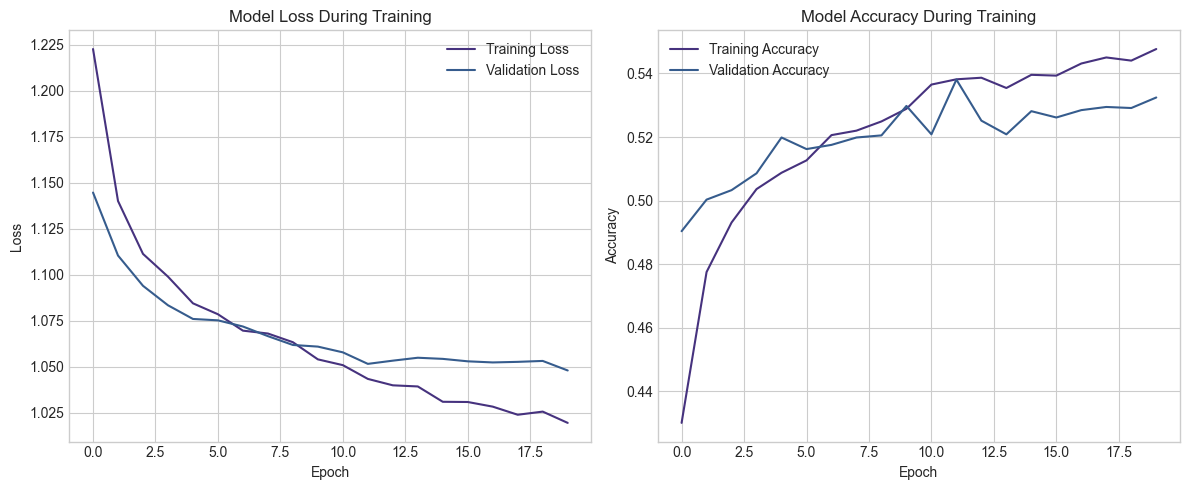


--- TensorFlow Example Section Complete ---


In [64]:
print("\n--- 24: Neural Network Classifier (TensorFlow - Example, Commented Out) ---")

# Ensure TensorFlow is installed: pip install tensorflow
import tensorflow as tf
# Ensure y_train_binned and y_test_binned exist and are suitable

if 'X_train' in locals() and X_train is not None and 'y_train_binned' in locals() and y_train_binned is not None:
    print("Preparing data for TensorFlow...")
    # Scale features if not already done (NNs benefit from scaled data)
    scaler_tf = StandardScaler()
    X_train_scaled_tf = scaler_tf.fit_transform(X_train)
    X_test_scaled_tf = scaler_tf.transform(X_test)

    # Convert to tensors
    X_train_tensor = tf.convert_to_tensor(X_train_scaled_tf, dtype=tf.float32)
    X_test_tensor = tf.convert_to_tensor(X_test_scaled_tf, dtype=tf.float32)

    # Convert labels to one-hot encoding for CategoricalCrossentropy
    num_classes = len(target_names) # Should be 4
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_binned, num_classes=num_classes)
    y_test_one_hot = tf.keras.utils.to_categorical(y_test_binned, num_classes=num_classes)
    y_train_tensor_one_hot = tf.convert_to_tensor(y_train_one_hot, dtype=tf.float32)
    y_test_tensor_one_hot = tf.convert_to_tensor(y_test_one_hot, dtype=tf.float32)

    num_features = X_train_tensor.shape[1]

    print("Building and compiling TensorFlow model...")
    # Define a simple sequential model
    tf_model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(num_features,)), # Input layer
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax') # Output layer with softmax for multiclass
    ])

    # Compile the model
    tf_model.compile(optimizer='adam',
                  # Use CategoricalCrossentropy for one-hot encoded labels
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    print(tf_model.summary())

    # Train the model
    print("\nTraining TensorFlow model...")
    # Increase epochs for potentially better results, add validation split
    history = tf_model.fit(X_train_tensor,
                           y_train_tensor_one_hot,
                           epochs=20, # Adjust epochs as needed
                           batch_size=32, # Adjust batch size
                           validation_split=0.2, # Use part of training data for validation during training
                           verbose=1)

    # Evaluate the model on the test set
    print("\nEvaluating TensorFlow model on test data...")
    test_loss, test_acc = tf_model.evaluate(X_test_tensor, y_test_tensor_one_hot, verbose=2)
    print(f'\nTest Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    # Plot training history (Loss)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training history (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    tf_history_path = os.path.join(RESULTS_DIR, 'tensorflow_training_history.png')
    plt.savefig(tf_history_path)
    print(f"\nTensorFlow training history plot saved to {tf_history_path}")
    plt.show()

else:
     print("Skipping TensorFlow example as required data (X_train, y_train_binned) is missing or TensorFlow not intended.")

print("\n--- TensorFlow Example Section Complete ---")


# ## Section 26: Keras Neural Network Regression
# - Train three different NN architectures (shallow, medium, deep) for regression.
# - Use EarlyStopping to prevent overfitting.
# - Evaluate models using RMSE, MAE, R².
# - Save plots and results to `results/neural_network`.

In [65]:
print("\n--- 26: Keras Neural Network Regression ---")

# Set results path for NN
NN_RESULTS_DIR = os.path.join(RESULTS_DIR, "neural_network")
os.makedirs(NN_RESULTS_DIR, exist_ok=True)
print(f"Neural Network results will be saved to: {NN_RESULTS_DIR}")

keras_results = {}

# Check if data exists
if X_train is not None and y_train is not None and X_test is not None and y_test is not None:

    # --- Scaling Features for NN --- (Important!)
    print("Scaling features for Keras Neural Networks...")
    scaler_nn = StandardScaler()
    X_train_scaled_nn = scaler_nn.fit_transform(X_train)
    X_test_scaled_nn = scaler_nn.transform(X_test)
    print("Features scaled.")

    # Define neural network architectures
    architectures = {
        "shallow": [64],
        "medium": [128, 64],
        "deep": [256, 128, 64]
    }

    # Store history for potential later plotting if needed
    histories = {}

    for name, layers in architectures.items():
        print(f"\n--- Training {name.upper()} Neural Network ---")
        model = Sequential(name=f"NN_{name}") # Give model a name
        # Input layer
        model.add(Dense(layers[0], input_dim=X_train_scaled_nn.shape[1], activation='relu'))
        # Hidden layers
        for units in layers[1:]:
            model.add(Dense(units, activation='relu'))
        # Output layer (1 neuron for regression, linear activation)
        model.add(Dense(1, activation='linear'))

        # Compile the model - Use Mean Squared Error for regression
        model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()]) # Add MAE metric
        print(model.summary())

        # Early stopping callback
        early_stop = EarlyStopping(monitor='val_loss', patience=10, # Increased patience slightly
                                   restore_best_weights=True, verbose=1)

        # Train the model
        print(f"Fitting {name} model...")
        history = model.fit(
            X_train_scaled_nn, y_train,
            validation_split=0.2, # Use 20% of training data for validation
            epochs=150,           # Increased epochs, early stopping will handle it
            batch_size=64,        # Adjusted batch size
            callbacks=[early_stop],
            verbose=0 # Set to 0 to reduce console output, set to 1 for progress bars
        )
        histories[name] = history
        print(f"Training complete for {name} model.")

        # Make predictions on the scaled test set
        print("Making predictions...")
        y_pred_nn = model.predict(X_test_scaled_nn).flatten() # Flatten output
        y_pred_nn = np.maximum(0, y_pred_nn) # Ensure non-negative predictions

        # Evaluate model performance
        rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
        mae_nn = mean_absolute_error(y_test, y_pred_nn)
        r2_nn = r2_score(y_test, y_pred_nn)

        keras_results[name] = {"RMSE": rmse_nn, "MAE": mae_nn, "R2": r2_nn}
        print(f"{name.title()} Network Results - RMSE: {rmse_nn:,.2f}, MAE: {mae_nn:,.2f}, R²: {r2_nn:.4f}")

        # --- Plot Actual vs Predicted --- 
        print(f"Plotting Actual vs Predicted for {name} network...")
        plt.figure(figsize=(8, 8))
        plt.scatter(y_test, y_pred_nn, alpha=0.5, s=20)
        min_val = min(y_test.min(), y_pred_nn.min())
        max_val = max(y_test.max(), y_pred_nn.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        plt.xlabel(f"Actual {TARGET_COLUMN}")
        plt.ylabel(f"Predicted {TARGET_COLUMN}")
        plt.title(f"{name.title()} Neural Network: Actual vs Predicted")
        plt.grid(True, linestyle='--', alpha=0.5)
        # Consider log scale if needed
        # plt.xscale('log')
        # plt.yscale('log')
        plt.tight_layout()
        plot_path = os.path.join(NN_RESULTS_DIR, f"{name}_actual_vs_predicted.png")
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")
        plt.close() # Close the figure to free memory

        # --- Plot Training History (Loss) --- 
        print(f"Plotting Loss History for {name} network...")
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name.title()} Network: Model Loss')
        plt.ylabel('Loss (MSE)')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        loss_plot_path = os.path.join(NN_RESULTS_DIR, f"{name}_loss_history.png")
        plt.savefig(loss_plot_path)
        print(f"Loss history plot saved to {loss_plot_path}")
        plt.close()


    # Save summary results to a text file
    summary_file = os.path.join(NN_RESULTS_DIR, "nn_regression_summary.txt")
    print(f"\nSaving Keras NN results summary to {summary_file}")
    try:
        with open(summary_file, "w") as f:
            f.write("Keras Neural Network Regression Results\n")
            f.write("========================================\n\n")
            for name, metrics in keras_results.items():
                f.write(f"--- {name.title()} Network ---\n")
                f.write(f"  RMSE: {metrics['RMSE']:,.2f}\n")
                f.write(f"  MAE:  {metrics['MAE']:,.2f}\n")
                f.write(f"  R²:   {metrics['R2']:.4f}\n\n")
        print("Summary saved.")
    except Exception as e:
        print(f"Error saving NN summary: {e}")

else:
    print("Skipping Keras Neural Network Regression as required data is missing.")

print("\n--- Keras Neural Network Regression Complete ---")



--- 26: Keras Neural Network Regression ---
Neural Network results will be saved to: results/neural_network
Scaling features for Keras Neural Networks...
Features scaled.

--- Training SHALLOW Neural Network ---


/opt/anaconda3/envs/CIS4930/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "NN_shallow"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Fitting shallow model...
Restoring model weights from the end of the best epoch: 150.
Training complete for shallow model.
Making predictions...
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
Shallow Network Results - RMSE: 153,543,381.57, MAE: 69,227,913.54, R²: -0.2544
Plotting Actual vs Predicted for shallow network...
Plot saved to results/neural_network/shallow_actual_vs_predicted.png
Plotting Loss History for shallow network...
Loss history plot saved to results/neural_network/shallow_loss_history.png

--- Training MEDIUM Neural Network ---


/opt/anaconda3/envs/CIS4930/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "NN_medium"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Fitting medium model...
Restoring model weights from the end of the best epoch: 150.
Training complete for medium model.
Making predictions...
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
Medium Network Results - RMSE: 115,295,368.02, MAE: 63,975,992.59, R²: 0.2927
Plotting Actual vs Predicted for medium network...
Plot saved to results/neural_network/medium_actual_vs_predicted.png
Plotting Loss History for medium network...
Loss history plot saved to results/neural_network/medium_loss_history.png

--- Training DEEP Neural Network ---


/opt/anaconda3/envs/CIS4930/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "NN_deep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,825 (179.00 KB)

 Trainable params: 45,825 (179.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Fitting deep model...
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 69.
Training complete for deep model.
Making predictions...
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
Deep Network Results - RMSE: 114,532,532.92, MAE: 61,674,475.81, R²: 0.3020
Plotting Actual vs Predicted for deep network...
Plot saved to results/neural_network/deep_actual_vs_predicted.png
Plotting Loss History for deep network...
Loss history plot saved to results/neural_network/deep_loss_history.png

Saving Keras NN results summary to results/neural_network/nn_regression_summary.txt
Summary saved.

--- Keras Neural Network Regression Complete ---


# ## Section 27: Gradient Boosting Regression
# - Train a Gradient Boosting Regressor model.
# - Evaluate its performance using RMSE, MAE, R².
# - Visualize Actual vs Predicted, Residuals, and Feature Importance.


In [66]:
print("\n--- 27: Gradient Boosting Regression ---")

# Set matplotlib backend to Agg for this section if needed (prevents plt.show())
# import matplotlib
# matplotlib.use('Agg')

gb_r2, gb_rmse, gb_mae = None, None, None # Initialize metrics

if X_train is not None and y_train is not None and X_test is not None and y_test is not None:

    print("Training Gradient Boosting Regressor...")
    # Using hyperparameters from the user snippet, consider tuning these
    gb_model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE,
        loss='squared_error' # Default, explicit is good
    )
    gb_model.fit(X_train, y_train) # Fit on original (unscaled) data usually fine for GBDT

    # Make predictions
    print("Making predictions with Gradient Boosting model...")
    y_pred_gb = gb_model.predict(X_test)
    y_pred_gb = np.maximum(0, y_pred_gb) # Ensure non-negative

    # Evaluate the model
    gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
    gb_mae = mean_absolute_error(y_test, y_pred_gb)
    gb_r2 = r2_score(y_test, y_pred_gb)

    print("\n--- Gradient Boosting Regressor Evaluation ---")
    print(f"Test R²: {gb_r2:.4f}")
    print(f"Test RMSE: {gb_rmse:,.2f}")
    print(f"Test MAE: {gb_mae:,.2f}")

    # --- Plot: Actual vs Predicted --- 
    print("Plotting Actual vs Predicted for Gradient Boosting...")
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_gb, alpha=0.5, s=20)
    min_val = min(y_test.min(), y_pred_gb.min())
    max_val = max(y_test.max(), y_pred_gb.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel(f"Actual {TARGET_COLUMN}")
    plt.ylabel(f"Predicted {TARGET_COLUMN}")
    plt.title("Gradient Boosting: Actual vs Predicted")
    plt.grid(True, linestyle='--', alpha=0.5)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.tight_layout()
    gb_avp_path = os.path.join(RESULTS_DIR, 'gradient_boosting_actual_vs_predicted.png')
    plt.savefig(gb_avp_path)
    print(f"Actual vs Predicted plot saved to {gb_avp_path}")
    plt.close()

    # --- Plot: Residuals --- 
    print("Plotting Residuals for Gradient Boosting...")
    residuals_gb = y_test - y_pred_gb
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_gb, residuals_gb, alpha=0.5, s=20)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel(f"Predicted {TARGET_COLUMN}")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Gradient Boosting: Residuals Plot")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    gb_res_path = os.path.join(RESULTS_DIR, 'gradient_boosting_residuals.png')
    plt.savefig(gb_res_path)
    print(f"Residuals plot saved to {gb_res_path}")
    plt.close()

    # --- Plot: Feature Importances --- 
    print("Plotting Feature Importance for Gradient Boosting...")
    # Use feature names from X_train
    if 'X_train' in locals() and hasattr(X_train, 'columns'):
        feature_names = X_train.columns.tolist()
        feature_importance_gb = pd.Series(gb_model.feature_importances_, index=feature_names).sort_values(ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(x=feature_importance_gb.values[:15], y=feature_importance_gb.index[:15], palette='viridis')
        plt.title("Gradient Boosting: Top 15 Feature Importances")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        gb_fi_path = os.path.join(RESULTS_DIR, 'gradient_boosting_feature_importance.png')
        plt.savefig(gb_fi_path)
        print(f"Feature importance plot saved to {gb_fi_path}")
        plt.close()
    else:
        print("Could not plot feature importance: Feature names not found.")

else:
    print("Skipping Gradient Boosting Regression as required data is missing.")

print("\n--- Gradient Boosting Regression Complete ---")



--- 27: Gradient Boosting Regression ---
Training Gradient Boosting Regressor...
Making predictions with Gradient Boosting model...

--- Gradient Boosting Regressor Evaluation ---
Test R²: 0.4593
Test RMSE: 100,806,875.33
Test MAE: 52,857,456.75
Plotting Actual vs Predicted for Gradient Boosting...
Actual vs Predicted plot saved to results/gradient_boosting_actual_vs_predicted.png
Plotting Residuals for Gradient Boosting...
Residuals plot saved to results/gradient_boosting_residuals.png
Plotting Feature Importance for Gradient Boosting...
Feature importance plot saved to results/gradient_boosting_feature_importance.png

--- Gradient Boosting Regression Complete ---


/var/folders/2v/k3cldn7x0hq_bs2w355s8ggw0000gn/T/ipykernel_23919/1053507412.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_gb.values[:15], y=feature_importance_gb.index[:15], palette='viridis')


# # ## Section 28: KNN Classifier (Standalone Implementation)
# # - Implement a standalone KNN Classifier (not part of a stacking ensemble).
# # - Use 4 categories for view count bins.
# # - Evaluate on both training and testing sets.
# # - Generate confusion matrices for both sets.

In [73]:
print("\n--- 28: KNN Classifier (Standalone Implementation) ---")

# Import KNeighborsClassifier if not already imported
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Initialize variables
knn_standalone_test_accuracy = None

if X_train is not None and y_train is not None and X_test is not None and y_test is not None:
    # Apply binning to target variable (using our 4 categories from previous update)
    print("Binning target variable into 4 categories...")
    # Define the bins and labels (ensure these match our updated 4-category bins)
    # Using same bins as defined earlier in the stacking section
    knn_bins = [0, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000]
    knn_labels = [1, 2, 3, 4]  # 4 categories only
    
    # Convert to series for binning
    if not isinstance(y_train, pd.Series): y_train_series = pd.Series(y_train)
    else: y_train_series = y_train
    if not isinstance(y_test, pd.Series): y_test_series = pd.Series(y_test)
    else: y_test_series = y_test
    
    # Bin the target variables
    knn_y_train = pd.cut(y_train_series, bins=knn_bins, labels=knn_labels, right=False, include_lowest=True)
    knn_y_test = pd.cut(y_test_series, bins=knn_bins, labels=knn_labels, right=False, include_lowest=True)
    
    # Scale the features (KNN is distance-based, so scaling is important)
    print("Scaling features for KNN Classifier...")
    scaler_knn = StandardScaler()
    X_train_scaled_knn = scaler_knn.fit_transform(X_train)
    X_test_scaled_knn = scaler_knn.transform(X_test)
    
    # Handle any potential NaN values from binning
    train_nan_indices = knn_y_train.isna()
    test_nan_indices = knn_y_test.isna()
    
    if train_nan_indices.any() or test_nan_indices.any():
        print("Warning: NaN values found after binning. Dropping corresponding rows.")
        X_train_scaled_knn = X_train_scaled_knn[~train_nan_indices]
        knn_y_train = knn_y_train.dropna()
        X_test_scaled_knn = X_test_scaled_knn[~test_nan_indices]
        knn_y_test = knn_y_test.dropna()
        print(f"Rows dropped: {train_nan_indices.sum()} from training, {test_nan_indices.sum()} from testing.")
    
    # Initialize the KNN Classifier with a suitable n_neighbors value
    print("Initializing KNN Classifier...")
    # n_neighbors=5 is default, but we can customize based on the data
    knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=-1)
    
    # Train the KNN model
    print("Training KNN Classifier...")
    knn_classifier.fit(X_train_scaled_knn, knn_y_train)
    
    # Make predictions on both training and test sets
    print("Making predictions...")
    knn_train_pred = knn_classifier.predict(X_train_scaled_knn)
    knn_test_pred = knn_classifier.predict(X_test_scaled_knn)
    
    # Calculate performance metrics
    knn_train_accuracy = accuracy_score(knn_y_train, knn_train_pred)
    knn_test_accuracy = accuracy_score(knn_y_test, knn_test_pred)
    knn_train_precision = precision_score(knn_y_train, knn_train_pred, average='weighted', zero_division=0)
    knn_test_precision = precision_score(knn_y_test, knn_test_pred, average='weighted', zero_division=0)
    knn_train_recall = recall_score(knn_y_train, knn_train_pred, average='weighted', zero_division=0)
    knn_test_recall = recall_score(knn_y_test, knn_test_pred, average='weighted', zero_division=0)
    knn_train_f1 = f1_score(knn_y_train, knn_train_pred, average='weighted', zero_division=0)
    knn_test_f1 = f1_score(knn_y_test, knn_test_pred, average='weighted', zero_division=0)
    
    # Save for later use in metrics collection
    knn_standalone_test_accuracy = knn_test_accuracy
    
    # Generate confusion matrices
    knn_train_cm = confusion_matrix(knn_y_train, knn_train_pred, labels=knn_labels)
    knn_test_cm = confusion_matrix(knn_y_test, knn_test_pred, labels=knn_labels)
    
    # Plot training confusion matrix
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(knn_train_cm, annot=True, fmt='d', cmap='Blues', 
                     xticklabels=knn_labels, yticklabels=knn_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('KNN Classification on Training Set')
    
    # # Add metrics text to the bottom of the training plot
    # plt.figtext(0.5, 0.01, 
    #     f'Training set accuracy: {knn_train_accuracy:.4f}\n'
    #     f'Training set precision: {knn_train_precision:.4f}\n'
    #     f'Training set recall: {knn_train_recall:.4f}\n'
    #     f'Training set F1-Score: {knn_train_f1:.4f}',
    #     ha='center', fontsize=10)
    
    plt.tight_layout()
    # Save the training confusion matrix
    train_cm_path = os.path.join(RESULTS_DIR, 'knn_standalone_train_confusion_matrix.png')
    plt.savefig(train_cm_path)
    plt.close()
    print(f"Training confusion matrix saved to: {train_cm_path}")
    
    # Plot testing confusion matrix
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(knn_test_cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=knn_labels, yticklabels=knn_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('KNN Classification on Testing Set')
    
    # # Add metrics text to the bottom of the testing plot
    # plt.figtext(0.5, 0.01, 
    #     f'Testing set accuracy: {knn_test_accuracy:.4f}\n'
    #     f'Testing set precision: {knn_test_precision:.4f}\n'
    #     f'Testing set recall: {knn_test_recall:.4f}\n'
    #     f'Testing set F1-Score: {knn_test_f1:.4f}',
    #     ha='center', fontsize=10)
    
    plt.tight_layout()
    # Save the testing confusion matrix
    test_cm_path = os.path.join(RESULTS_DIR, 'knn_standalone_test_confusion_matrix.png')
    plt.savefig(test_cm_path)
    plt.close()
    print(f"Testing confusion matrix saved to: {test_cm_path}")
    
    # Print the metrics to console
    print("\nKNN Classifier Performance (4 Bins):")
    print(f"  Training set accuracy:  {knn_train_accuracy:.4f}")
    print(f"  Testing set accuracy:   {knn_test_accuracy:.4f}")
    print(f"  Training set precision: {knn_train_precision:.4f} (weighted)")
    print(f"  Testing set precision:  {knn_test_precision:.4f} (weighted)")
    print(f"  Training set recall:    {knn_train_recall:.4f} (weighted)")
    print(f"  Testing set recall:     {knn_test_recall:.4f} (weighted)")
    print(f"  Training set F1-Score:  {knn_train_f1:.4f} (weighted)")
    print(f"  Testing set F1-Score:   {knn_test_f1:.4f} (weighted)")
    
    # Print classification report
    print("\nClassification Report (Testing Set):")
    print(classification_report(knn_y_test, knn_test_pred, labels=knn_labels, 
                             target_names=[f'Class {l}' for l in knn_labels], zero_division=0))
    
    # Add these metrics to the model_metrics_structured dictionary if it exists
    if 'model_metrics_structured' in locals():
        print("Adding KNN Classifier metrics to results dictionary...")
        model_metrics_structured['KNN_Classifier_Standalone'] = {
            'Test_Accuracy': knn_test_accuracy,
            'Test_Precision_Weighted': knn_test_precision,
            'Test_Recall_Weighted': knn_test_recall,
            'Test_F1_Weighted': knn_test_f1
        }
    
else:
    print("Skipping KNN Classifier section because training/test data is missing.")

print("\n--- KNN Classifier Implementation Complete ---")


--- 28: KNN Classifier (Standalone Implementation) ---
Binning target variable into 4 categories...
Scaling features for KNN Classifier...
Initializing KNN Classifier...
Training KNN Classifier...
Making predictions...
Training confusion matrix saved to: results/knn_standalone_train_confusion_matrix.png
Testing confusion matrix saved to: results/knn_standalone_test_confusion_matrix.png

KNN Classifier Performance (4 Bins):
  Training set accuracy:  0.6156
  Testing set accuracy:   0.4159
  Training set precision: 0.6277 (weighted)
  Testing set precision:  0.4301 (weighted)
  Training set recall:    0.6156 (weighted)
  Testing set recall:     0.4159 (weighted)
  Training set F1-Score:  0.6163 (weighted)
  Testing set F1-Score:   0.4176 (weighted)

Classification Report (Testing Set):
              precision    recall  f1-score   support

     Class 1       0.36      0.37      0.37       713
     Class 2       0.30      0.34      0.32       920
     Class 3       0.46      0.51      0.

# ## Section 28.5: Helper Functions for SVM (Multi-Kernel) and Stacking Models
# Define functions to encapsulate training and evaluation for:
# - SVM with multiple kernels (classification)
# - Stacking Classifier
# - Stacking Regressor


In [68]:
print("\n--- 28: Defining Helper Functions for SVM/Stacking ---")

# (Ensure categorize_views is defined earlier in the script)

def check_accuracy(y_test_binned, predictions_dict):
    """Calculates and prints accuracy/report for different SVM kernel predictions."""
    results = {}
    print("\n--- SVM Kernel Accuracy Check ---")
    for kernel, y_pred in predictions_dict.items():
        accuracy = accuracy_score(y_test_binned, y_pred)
        print(f"  {kernel.title()} SVM Accuracy: {accuracy:.4f}")
        try:
            # Use y_pred (predictions) not accuracy (float) in classification_report
            print(f"  Classification Report ({kernel.title()} SVM):")
            print(classification_report(y_test_binned, y_pred, target_names=target_names, zero_division=0))
            # Store accuracy and potentially weighted F1 for reporting
            f1 = f1_score(y_test_binned, y_pred, average='weighted', zero_division=0)
            results[kernel] = {'Accuracy': accuracy, 'F1_Weighted': f1}
        except Exception as e:
            print(f"    Could not generate classification report for {kernel}: {e}")
            results[kernel] = {'Accuracy': accuracy, 'F1_Weighted': None}
        print("---")
    return results

def svm_classification(X_train, y_train, X_test, y_test):
    """Trains SVM with multiple kernels and evaluates them."""
    print("\n--- Training SVM with Multiple Kernels (4 Bins) ---")
    # Scale data specifically for SVM if not done globally
    print("Scaling data for SVMs...")
    scaler_svm_multi = StandardScaler()
    X_train_scaled = scaler_svm_multi.fit_transform(X_train)
    X_test_scaled = scaler_svm_multi.transform(X_test)

    # Bin targets (4 categories)
    y_train_binned = np.array([categorize_views(v) for v in y_train])
    y_test_binned = np.array([categorize_views(v) for v in y_test])

    predictions = {}
    kernels_to_test = ['linear', 'rbf', 'poly', 'sigmoid']
    svm_models = {}

    for kernel in kernels_to_test:
        print(f"Training SVM with {kernel} kernel...")
        # Using C=1, gamma='scale' as defaults from snippet
        svm_model = svm.SVC(kernel=kernel, C=1, gamma='scale', random_state=RANDOM_STATE)
        try:
            svm_model.fit(X_train_scaled, y_train_binned)
            y_pred = svm_model.predict(X_test_scaled)
            predictions[kernel] = y_pred
            svm_models[kernel] = svm_model # Store trained model if needed
            print(f"{kernel.title()} SVM trained.")
        except Exception as e:
            print(f"ERROR training {kernel} SVM: {e}")
            predictions[kernel] = None # Indicate failure

    # Evaluate predictions
    valid_predictions = {k: v for k, v in predictions.items() if v is not None}
    if valid_predictions:
        svm_results = check_accuracy(y_test_binned, valid_predictions)
    else:
        print("No SVM models trained successfully.")
        svm_results = {}

    print("--- Multi-Kernel SVM Training Complete ---")
    return svm_results

def stacking_classification(X_train, y_train, X_test, y_test):
    """Trains and evaluates a Stacking Classifier (RF, DT, Ada -> LogReg)."""
    print("\n--- Training Stacking Classifier (RF+DT+Ada -> LogReg) --- ")
    # Scale data
    print("Scaling data for Stacking Classifier...")
    scaler_stack_clf = StandardScaler()
    X_train_scaled = scaler_stack_clf.fit_transform(X_train)
    X_test_scaled = scaler_stack_clf.transform(X_test)

    # Bin targets
    y_train_binned = np.array([categorize_views(v) for v in y_train])
    y_test_binned = np.array([categorize_views(v) for v in y_test])

    # Define base estimators (using parameters from snippet)
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)),
        ('dt', DecisionTreeClassifier(max_depth=7, random_state=RANDOM_STATE)),
        ('ada', AdaBoostClassifier(random_state=RANDOM_STATE)) # Default n_estimators=50
    ]

    # Define Stacking Classifier with Logistic Regression as final estimator
    stack_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        cv=5 # Use cross-validation for base model predictions
    )

    print("Fitting Stacking Classifier...")
    stack_clf.fit(X_train_scaled, y_train_binned)
    print("Stacking Classifier trained.")

    # Predictions and evaluation
    print("Evaluating Stacking Classifier...")
    y_pred_stack_clf = stack_clf.predict(X_test_scaled)

    accuracy = accuracy_score(y_test_binned, y_pred_stack_clf)
    precision = precision_score(y_test_binned, y_pred_stack_clf, average='weighted', zero_division=0)
    recall = recall_score(y_test_binned, y_pred_stack_clf, average='weighted', zero_division=0)
    f1 = f1_score(y_test_binned, y_pred_stack_clf, average='weighted', zero_division=0)

    print(f"Stacking Classifier Accuracy: {accuracy:.4f}")
    print(f"Stacking Classifier F1 (Weighted): {f1:.4f}")
    print("\nClassification Report (Stacking Classifier):")
    print(classification_report(y_test_binned, y_pred_stack_clf, target_names=target_names, zero_division=0))

    # Confusion Matrix
    print("Generating Confusion Matrix for Stacking Classifier...")
    cm_stack_clf = confusion_matrix(y_test_binned, y_pred_stack_clf, labels=range(len(target_names)))
    disp_stack_clf = ConfusionMatrixDisplay(confusion_matrix=cm_stack_clf, display_labels=target_names)
    plt.figure()
    disp_stack_clf.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Stacking Classifier")
    stack_cm_path = os.path.join(RESULTS_DIR, 'stacking_classifier_confusion_matrix.png')
    plt.savefig(stack_cm_path)
    print(f"Stacking Classifier confusion matrix saved to {stack_cm_path}")
    plt.close()

    print("--- Stacking Classifier Evaluation Complete ---")
    # Return metrics
    return {
        'Test_Accuracy': accuracy,
        'Test_Precision_Weighted': precision,
        'Test_Recall_Weighted': recall,
        'Test_F1_Weighted': f1
    }

def stacking_regressor(X_train, y_train, X_test, y_test):
    """Trains and evaluates a Stacking Regressor (LR, SVR, Ridge -> SVR)."""
    print("\n--- Training Stacking Regressor (LR+SVR+Ridge -> SVR) --- ")
    # Scale data
    print("Scaling data for Stacking Regressor...")
    scaler_stack_reg = StandardScaler()
    X_train_scaled = scaler_stack_reg.fit_transform(X_train)
    X_test_scaled = scaler_stack_reg.transform(X_test)

    # Define base estimators
    estimators = [
        ('lr', LinearRegression()),
        ('svr_lin', SVR(kernel='linear', C=1.0)), # Linear SVR, maybe tune C
        ('ridge', Ridge(random_state=RANDOM_STATE))
    ]

    # Define Stacking Regressor with SVR(rbf) as final estimator
    # Note: SVR can be sensitive to scaling and hyperparameters (C, gamma)
    stack_reg = StackingRegressor(
        estimators=estimators,
        final_estimator=SVR(kernel='rbf', C=1.0, gamma='scale'),
        cv=5 # Use cross-validation for base model predictions
    )

    print("Fitting Stacking Regressor...")
    stack_reg.fit(X_train_scaled, y_train)
    print("Stacking Regressor trained.")

    # Predictions and evaluation
    print("Evaluating Stacking Regressor...")
    y_pred_stack_reg = stack_reg.predict(X_test_scaled)
    y_pred_stack_reg = np.maximum(0, y_pred_stack_reg) # Ensure non-negative

    # Calculate Regression Metrics (FIXED)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack_reg))
    mae = mean_absolute_error(y_test, y_pred_stack_reg)
    r2 = r2_score(y_test, y_pred_stack_reg)

    print("\n--- Stacking Regressor Evaluation ---")
    print(f"Test R²: {r2:.4f}")
    print(f"Test RMSE: {rmse:,.2f}")
    print(f"Test MAE: {mae:,.2f}")

    # Plot Actual vs Predicted
    print("Plotting Actual vs Predicted for Stacking Regressor...")
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_stack_reg, alpha=0.5, s=20)
    min_val = min(y_test.min(), y_pred_stack_reg.min())
    max_val = max(y_test.max(), y_pred_stack_reg.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel(f"Actual {TARGET_COLUMN}")
    plt.ylabel(f"Predicted {TARGET_COLUMN}")
    plt.title("Stacking Regressor: Actual vs Predicted")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    stack_reg_avp_path = os.path.join(RESULTS_DIR, 'stacking_regressor_actual_vs_predicted.png')
    plt.savefig(stack_reg_avp_path)
    print(f"Actual vs Predicted plot saved to {stack_reg_avp_path}")
    plt.close()

    print("--- Stacking Regressor Evaluation Complete ---")
    # Return metrics
    return {
        'Test_R2': r2,
        'Test_RMSE': rmse,
        'Test_MAE': mae
    }

print("--- Helper Functions Defined ---")




--- 28: Defining Helper Functions for SVM/Stacking ---
--- Helper Functions Defined ---


# ## Section 29: SVM Classification (All Kernels Evaluation)
# Execute the multi-kernel SVM classification function.


In [69]:
print("\n--- 29: Executing Multi-Kernel SVM Classification ---")

svm_multi_kernel_results = None
if X_train is not None and y_train is not None and X_test is not None and y_test is not None:
    svm_multi_kernel_results = svm_classification(X_train, y_train, X_test, y_test)
    print("\nMulti-Kernel SVM Results Summary:")
    pprint.pprint(svm_multi_kernel_results) # Pretty print the results
else:
    print("Skipping Multi-Kernel SVM execution due to missing data.")

print("\n--- Multi-Kernel SVM Section Complete ---")



--- 29: Executing Multi-Kernel SVM Classification ---

--- Training SVM with Multiple Kernels (4 Bins) ---
Scaling data for SVMs...
Training SVM with linear kernel...
Linear SVM trained.
Training SVM with rbf kernel...
Rbf SVM trained.
Training SVM with poly kernel...
Poly SVM trained.
Training SVM with sigmoid kernel...
Sigmoid SVM trained.

--- SVM Kernel Accuracy Check ---
  Linear SVM Accuracy: 0.4501
  Classification Report (Linear SVM):
              precision    recall  f1-score   support

         <1M       0.53      0.15      0.24       713
      1M-10M       0.12      0.00      0.01       920
    10M-100M       0.42      0.91      0.57      1450
     100M-1B       0.67      0.39      0.50       692

    accuracy                           0.45      3775
   macro avg       0.44      0.36      0.33      3775
weighted avg       0.41      0.45      0.36      3775

---
  Rbf SVM Accuracy: 0.4983
  Classification Report (Rbf SVM):
              precision    recall  f1-score   suppo

# ## Section 30: Stacking Classifier Evaluation
# Execute the Stacking Classifier function.


In [70]:
print("\n--- 30: Executing Stacking Classifier ---")

stacking_clf_results = None
if X_train is not None and y_train is not None and X_test is not None and y_test is not None:
    stacking_clf_results = stacking_classification(X_train, y_train, X_test, y_test)
else:
    print("Skipping Stacking Classifier execution due to missing data.")

print("\n--- Stacking Classifier Section Complete ---")



--- 30: Executing Stacking Classifier ---

--- Training Stacking Classifier (RF+DT+Ada -> LogReg) --- 
Scaling data for Stacking Classifier...
Fitting Stacking Classifier...
Stacking Classifier trained.
Evaluating Stacking Classifier...
Stacking Classifier Accuracy: 0.5656
Stacking Classifier F1 (Weighted): 0.5579

Classification Report (Stacking Classifier):
              precision    recall  f1-score   support

         <1M       0.60      0.45      0.52       713
      1M-10M       0.48      0.39      0.43       920
    10M-100M       0.56      0.73      0.63      1450
     100M-1B       0.67      0.57      0.61       692

    accuracy                           0.57      3775
   macro avg       0.58      0.53      0.55      3775
weighted avg       0.57      0.57      0.56      3775

Generating Confusion Matrix for Stacking Classifier...
Stacking Classifier confusion matrix saved to results/stacking_classifier_confusion_matrix.png
--- Stacking Classifier Evaluation Complete ---

---

<Figure size 640x480 with 0 Axes>

# ## Section 31: Stacking Regressor Evaluation
# Execute the Stacking Regressor function.

In [71]:
print("\n--- 31: Executing Stacking Regressor ---")

stacking_reg_results = None
if X_train is not None and y_train is not None and X_test is not None and y_test is not None:
    stacking_reg_results = stacking_regressor(X_train, y_train, X_test, y_test)
else:
    print("Skipping Stacking Regressor execution due to missing data.")

print("\n--- Stacking Regressor Section Complete ---")


--- 31: Executing Stacking Regressor ---

--- Training Stacking Regressor (LR+SVR+Ridge -> SVR) --- 
Scaling data for Stacking Regressor...
Fitting Stacking Regressor...
Stacking Regressor trained.
Evaluating Stacking Regressor...

--- Stacking Regressor Evaluation ---
Test R²: -0.1588
Test RMSE: 147,574,095.02
Test MAE: 65,375,170.01
Plotting Actual vs Predicted for Stacking Regressor...
Actual vs Predicted plot saved to results/stacking_regressor_actual_vs_predicted.png
--- Stacking Regressor Evaluation Complete ---

--- Stacking Regressor Section Complete ---


# ## Section 32: Save All Metrics for Reporting
# Consolidate all calculated model evaluation metrics into a nested dictionary. Remove any entries where the metric calculation failed (value is `None` or `NaN`). Save this dictionary to a JSON file (`model_metrics_all.json`) in the `results` directory.


In [72]:
# ## Section 32: Save All Metrics for Reporting
# Consolidate all calculated model evaluation metrics into a nested dictionary. Remove any entries where the metric calculation failed (value is `None` or `NaN`). Save this dictionary to a JSON file (`model_metrics_all.json`) in the `results` directory.

# %%
print("\n--- 32: Saving All Metrics for Reporting ---") # Updated Section Number

# Initialize or ensure the dictionary exists
if 'model_metrics_structured' not in locals():
    model_metrics_structured = {}

print("Gathering metrics from all models into the results dictionary...")

# --- Add metrics from previous sections --- 
model_metrics_structured['LinearRegression_TrainTest'] = {
    'Test_R2': locals().get('test_r2_lr'),
    'Test_RMSE': locals().get('test_rmse_lr'),
    'Test_MAE': locals().get('test_mae_lr')
}
model_metrics_structured['RF_Regression_CV'] = {
    'CV_R2_Mean': locals().get('r2_cv_rf'), 'CV_R2_Std': locals().get('r2_cv_rf_std'),
    'CV_RMSE': locals().get('rmse_cv_rf'), 'CV_MAE': locals().get('mae_cv_rf'),
    'ClassifAccuracy_from_BinnedReg': locals().get('accuracy_cv_rf_from_reg')
}
model_metrics_structured['RF_Classification_CV'] = {
    'CV_Accuracy_Mean': locals().get('accuracy_mean_rf_clf'), 'CV_Accuracy_Std': locals().get('accuracy_std_rf_clf'),
    'CV_Precision_Weighted_Mean': locals().get('precision_mean_rf_clf'), 'CV_Precision_Weighted_Std': locals().get('precision_std_rf_clf'),
    'CV_Recall_Weighted_Mean': locals().get('recall_mean_rf_clf'), 'CV_Recall_Std': locals().get('recall_std_rf_clf'),
    'CV_F1_Weighted_Mean': locals().get('f1_mean_rf_clf'), 'CV_F1_Std': locals().get('f1_std_rf_clf')
}
model_metrics_structured['DT_Regression_CV'] = {
     'CV_R2_Mean': locals().get('r2_cv_dt'), 'CV_R2_Std': locals().get('r2_cv_dt_std'),
     'CV_RMSE': locals().get('rmse_cv_dt'), 'CV_MAE': locals().get('mae_cv_dt')
}
model_metrics_structured['DT_Classification_CV'] = {
    'CV_Accuracy_Mean': locals().get('accuracy_mean_dt'), 'CV_Accuracy_Std': locals().get('accuracy_std_dt'),
    'CV_Precision_Weighted_Mean': locals().get('precision_mean_dt'), 'CV_Precision_Weighted_Std': locals().get('precision_std_dt'),
    'CV_Recall_Weighted_Mean': locals().get('recall_mean_dt'), 'CV_Recall_Std': locals().get('recall_std_dt'),
    'CV_F1_Weighted_Mean': locals().get('f1_mean_dt'), 'CV_F1_Std': locals().get('f1_std_dt')
}
model_metrics_structured['RF_Classification_SMOTE_CV'] = {
    'CV_Accuracy_Mean': locals().get('accuracy_mean_rf_smote'), 'CV_Accuracy_Std': locals().get('accuracy_std_rf_smote'),
    'CV_Precision_Weighted_Mean': locals().get('precision_mean_rf_smote'), 'CV_Precision_Weighted_Std': locals().get('precision_std_rf_smote'),
    'CV_Recall_Weighted_Mean': locals().get('recall_mean_rf_smote'), 'CV_Recall_Std': locals().get('recall_std_rf_smote'),
    'CV_F1_Weighted_Mean': locals().get('f1_mean_rf_smote'), 'CV_F1_Std': locals().get('f1_std_rf_smote')
}
model_metrics_structured['DT_Classification_SMOTE_CV'] = {
    'CV_Accuracy_Mean': locals().get('accuracy_mean_dt_smote'), 'CV_Accuracy_Std': locals().get('accuracy_std_dt_smote'),
    'CV_Precision_Weighted_Mean': locals().get('precision_mean_dt_smote'), 'CV_Precision_Std': locals().get('precision_std_dt_smote'),
    'CV_Recall_Weighted_Mean': locals().get('recall_mean_dt_smote'), 'CV_Recall_Std': locals().get('recall_std_dt_smote'),
    'CV_F1_Weighted_Mean': locals().get('f1_mean_dt_smote'), 'CV_F1_Std': locals().get('f1_std_dt_smote')
}
# Stacking Classifier (kNN + DT) - Section 16.5
if 'knn_test_accuracy' in locals() and locals().get('knn_test_accuracy') is not None:
    model_metrics_structured['Stacking_kNN_DT_LogReg_4Bins'] = {
        'Test_Accuracy': locals().get('knn_test_accuracy'),
        'Test_Precision_Weighted': locals().get('knn_test_precision'),
        'Test_Recall_Weighted': locals().get('knn_test_recall'),
        'Test_F1_Weighted': locals().get('knn_test_f1')
    }
model_metrics_structured['AdaBoost_Regressor_TrainTest'] = {
    'Test_R2': locals().get('ab_reg_r2'),
    'Test_RMSE': locals().get('ab_reg_rmse'),
    'Test_MAE': locals().get('ab_reg_mae')
}
model_metrics_structured['AdaBoost_Classifier_TrainTest'] = {
    'Test_Accuracy': locals().get('ab_clf_accuracy'),
    'Test_Precision_Weighted': locals().get('ab_clf_precision'),
    'Test_Recall_Weighted': locals().get('ab_clf_recall'),
    'Test_F1_Weighted': locals().get('ab_clf_f1')
}
model_metrics_structured['kNN_Regressor_GridSearch_TrainTest'] = {
    'Best_Params': locals().get('gs_knn_best_params'),
    'Test_R2': locals().get('gs_knn_r2'),
    'Test_RMSE': locals().get('gs_knn_rmse'),
    'Test_MAE': locals().get('gs_knn_mae')
}
model_metrics_structured['SVM_Classifier_GridSearch_TrainTest'] = {
    'Best_Params': locals().get('gs_svm_best_params'),
    'Test_Accuracy': locals().get('gs_svm_accuracy'),
    'Test_Precision_Weighted': locals().get('gs_svm_precision'),
    'Test_Recall_Weighted': locals().get('gs_svm_recall'),
    'Test_F1_Weighted': locals().get('gs_svm_f1')
}
if 'keras_results' in locals() and keras_results:
     model_metrics_structured['Keras_NN_Regression_TrainTest'] = keras_results
model_metrics_structured['GradientBoosting_Regressor_TrainTest'] = {
    'Test_R2': locals().get('gb_r2'),
    'Test_RMSE': locals().get('gb_rmse'),
    'Test_MAE': locals().get('gb_mae')
}

# --- NEW: Add results from Sections 29, 30, 31 ---
if 'svm_multi_kernel_results' in locals() and svm_multi_kernel_results:
    model_metrics_structured['SVM_MultiKernel_Classification_TrainTest'] = svm_multi_kernel_results

if 'stacking_clf_results' in locals() and stacking_clf_results:
    model_metrics_structured['Stacking_Classifier_TrainTest'] = stacking_clf_results

if 'stacking_reg_results' in locals() and stacking_reg_results:
    model_metrics_structured['Stacking_Regressor_TrainTest'] = stacking_reg_results


# (Add TensorFlow results here if uncommented and run)
model_metrics_structured['TensorFlow_Classifier_TrainTest'] = {
    'Test_Accuracy': locals().get('test_acc'),
    'Test_Loss': locals().get('test_loss')
}

# Function to recursively remove None/NaN values from the dictionary
# (Using the corrected version from previous step)
def remove_none_values(item):
    if isinstance(item, dict):
        cleaned_dict = {k: remove_none_values(v) for k, v in item.items()}
        return {k: v for k, v in cleaned_dict.items() if pd.notna(v) and v is not None}
    elif isinstance(item, list):
        cleaned_list = [remove_none_values(v) for v in item if pd.notna(v) and v is not None]
        return cleaned_list if cleaned_list else None
    elif isinstance(item, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
        return int(item)
    elif isinstance(item, (np.float16, np.float32, np.float64)):
        return float(item) if np.isfinite(item) else None
    elif isinstance(item, np.bool_):
        return bool(item)
    elif isinstance(item, np.ndarray):
         return remove_none_values(item.tolist())
    else:
        return item if pd.notna(item) else None

print("Cleaning the final metrics dictionary (removing None/NaN values)...")
import copy
model_metrics_to_clean = copy.deepcopy(model_metrics_structured)
model_metrics_cleaned = remove_none_values(model_metrics_to_clean)

# Save cleaned metrics to a JSON file
metrics_file = os.path.join(RESULTS_DIR, 'model_metrics_all.json')
try:
    # Need pprint for printing later
    import pprint

    with open(metrics_file, 'w') as f:
        json.dump(model_metrics_cleaned, f, indent=4)
    print(f"\nCleaned model metrics saved to {metrics_file}")

    print("\nFinal Saved Metrics Structure:")
    pprint.pprint(model_metrics_cleaned)

except TypeError as e:
     print(f"Error saving metrics to JSON: {e}")
     print("Data causing error:", model_metrics_cleaned)
except Exception as e:
    print(f"An error occurred while saving metrics: {e}")


print("\n--- All Metrics Saving Complete ---")




--- 32: Saving All Metrics for Reporting ---
Gathering metrics from all models into the results dictionary...
Cleaning the final metrics dictionary (removing None/NaN values)...

Cleaned model metrics saved to results/model_metrics_all.json

Final Saved Metrics Structure:
{'AdaBoost_Classifier_TrainTest': {'Test_Accuracy': 0.5247682119205298,
                                   'Test_F1_Weighted': 0.5152616803317264,
                                   'Test_Precision_Weighted': 0.5187840600947184,
                                   'Test_Recall_Weighted': 0.5247682119205298},
 'AdaBoost_Regressor_TrainTest': {'Test_MAE': 99903560.74331166,
                                  'Test_R2': 0.016028111466389272,
                                  'Test_RMSE': 135989009.72372898},
 'DT_Classification_CV': {'CV_Accuracy_Mean': 0.47459393479962236,
                          'CV_Accuracy_Std': 0.00840062901205784,
                          'CV_F1_Std': 0.008672171342992032,
                       